In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
#from __future__ import print_function

## 2.2.2 Example: Bayesian A/B Testing

A/B testing is a statistical design pattern for determining the difference of effectiveness between two different treatments. For example, a pharmaceutical company is interested in the effectiveness of drug A versus drug B. The company will test drug A on some percentage of a patient group, and drug B on the rest (this split is often 50-50, but we will relax this assumption). After performing enough trials, the in-house statisticians measure the effectiveness to determine which drug yielded results.

Similarly, front-end Web developers are interested in which design of their Web site yields more _conversions_, where a conversion could be a visitor signing up, purchasing something, or taking some other action. They will route some fraction of visitors to site A, and the other fraction to site B (which has an alternate design), and record if the visit yielded a conversion or not. The assignments and conversions are recorded and analyzed afterward.

The key value of A/B tests is that there is only a single difference between groups. Thus, any significant change in the metrics (like drug effectiveness or conversions) can be directly attributed to the difference.

Often, the post-experiment analysis is done using something called a "hypothesis test" ike a _difference of means test_ or _difference of proportions test_. This involves often misunderstood quantities like a "Z-score" and even more confusing "p-values" (please don't ask). If you have taken a statistics course, you have probably been taught this technique (although not necessarily _learned_ this technique). And if you were like me, you may have felt uncomfortable with their derivatoin. If so, good. The Bayesian approach to this problem is more natural.



## 2.2.3 A Simple Case

As this is a _hacker_ book, we'll continue with the web-development example. For the moment, we will focus on the analysis of site A first. Assume that there is some probability, $p_A$, that users who are shown site A eventually convert. This is the true effectiveness of site A. Currently, this quantity is unknown to us.

Suppose site A was shown to $N$ people, and $n$ people converted. One might conlcude hastily that $p_A = \frac{n}{N}$.
Unfortunately, the _observed frequency_ $\frac{n}{N}$ does not necessarily equal $p_A$; there is a difference between the _observed frequency_ and the _true frequency_ of an event. The true frequency can be interpreted as the probability of an event occurring, and this does not necessarily equal the observed frequency. For example, the true frequency of rolling a 1 on a six-sided die is $\frac{1}{6}$, but if we roll the dice six times we may not see a 1 show up at all (the observed frequency)! We must commonly determine the true frequency of events like:

* The fraction of users who make purchases
* The proportion of some characteristic in a population
* The percentage of Internet users with cats
* Or the probability that it will rain tomorrow

Unfortunately, noise and complexities hide the true frequency from us and we must _infer_ it from observed data. We use Bayesian statistics to infer probable values of the true frequency using an apprpriate prior and observed data. With respect to our conversion example, we are interested in using what we know, $N$ (the total visitors) and $n$ (the number of conversions), to estimate what $p_A$, the true frequency of conversion, might be.

To set up a Bayesian model, we need to assign prior distributions to our unknown quantities. _A priori_, what do you think $p_A$ might be? For this example, we have no strong conviction about $p_A$, so for now, let's assume $p_A$ is uniform over [0,1]:

In [2]:
import pymc as pm

# The parameters are bounds of the Uniform
p = pm.Uniform('p', lower=0, upper=1)

For this example, suppose $p_A = 0.05$, and $N = 1500$ users shown site A, and we will simulate whether the user made a purchase or not. To simulate this from N trials, we will use a **Bernoulli distribution**. A Bernoulli distribution is a binary random variable (0 or 1 only), and as our observations are binary (not convert or convert), it is appropriate here. More formally, if 
$X \sim \mbox{Ber}(p)$, then $X$ is 1 with probability $p$ and 0 with probability $1-p$. 
Of course, in practice we do not know $p_A$, but we will use it here to simulate artificial data.

In [4]:
# set constants
p_true = 0.05 # remember, this is unknown in real life
N = 1500

# Sample N Bernoulli random variables from Ber(0.05)
# Each random variable has a 0.05 chance of being a 1
# This is the data-generation step

occurrences = pm.rbernoulli(p_true, N)

print occurrences
# Remeber: Python treats True == 1, and False == 0
print occurences.sum()

[False False False ..., False False False]
60


In [5]:
# Occurrences.mean() is equal to n/N

print "What is the observed frequency in Group A? %.4f " % occurences.mean()

What is the observed frequency in Group A? 0.0400 


In [6]:
# Include the observatoins, which are Bernoulli

obs = pm.Bernoulli("obs", p, value=occurrences, observed = True)

mcmc = pm.MCMC([p, obs])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 0.8 sec

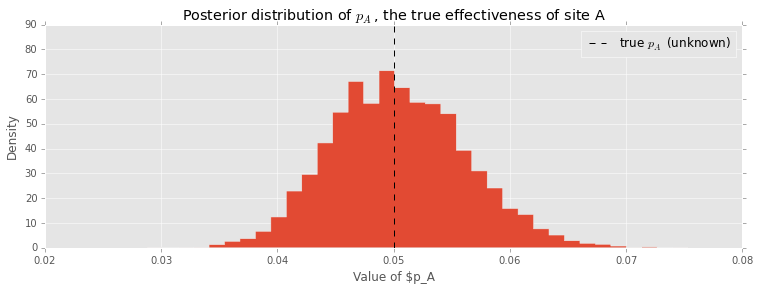

In [9]:
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plot

figsize(12.5, 4)
plt.title("Posterior distribution of $p_A$, the true effectiveness of site A")
plt.vlines(p_true, 0, 90, linestyle="--",
          label="true $p_A$ (unknown)")
plt.hist(mcmc.trace("p")[:], bins=35, histtype="stepfilled", normed=True)
plt.xlabel("Value of $p_A")
plt.ylabel("Density")
plt.legend()

Our posterior distrubtion puts weight near what our data suggests is the true value of $p_A$: the higher the distribution, the more likely it is there. Try changing the number of observations, $N$, and observe how the posterior distribution changes.

In [10]:
apost = mcmc.trace("p")[:]

In [11]:
apost

array([ 0.05431838,  0.05431838,  0.05431838, ...,  0.05290064,
        0.05290064,  0.05290064])

In [12]:
apostseries = pd.Series(apost)

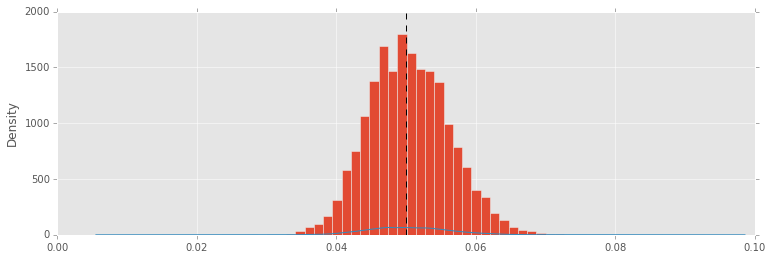

In [16]:
apostseries.plot(kind='hist',bins=35)
plt.vlines(p_true, 0, 2000, linestyle="--",
          label="true $p_A$ (unknown)")
apostseries.plot(kind='kde')

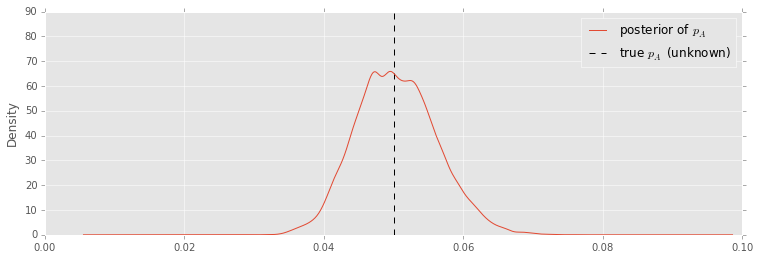

In [19]:
apostseries.plot(kind='kde', label="posterior of $p_A$")
plt.vlines(p_true, 0, 90, linestyle="--",
          label="true $p_A$ (unknown)")
plt.legend()

## 2.2.4 A and B Together

A similar analysis can be done for site B's response data to determine a posterior for $p_B$. What we are really interested in is the _difference_ between $p_A$ and $p_B$. Let's infer $p_A, p_B$, and delta = $p_A - p_B$, all at once.
We can do this using PyMC's deterministic variables. We'll assume for this exercise that $p_B = 0.04$ (though we don't know this), so delta = 0.01, $N_B = 750$ (only half of $N_A$) and we will simulate site B's data like we did for site A's data.

In [20]:
import pymc as pm
figsize(12,4)

# These two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

# Notice the unequal sample sizes - no problem in Bayesian analysis
N_A = 1500
N_B = 750

# Generate some observations
observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)
print "Obs from Site A: ", observations_A[:30].astype(int), "..."
print "Obs from Site B: ", observations_B[:30].astype(int), "..."

Obs from Site A:  [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [21]:
print observations_A.mean()
print observations_B.mean()

0.052
0.0293333333333


In [52]:
len(observations_A)

1500

In [53]:
observations_A.sum()

78

In [57]:
print len(observations_B)
print observations_B.sum()

750
22


In [22]:
# Set up the PyMC model. Again assume Uniform priors for p_A and p_B
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)

# Define the deterministic delta function. This is our unknown of interest

@pm.deterministic
def delta(p_A = p_A, p_B = p_B):
    return p_A - p_B

# Set of observations; in this case, we hvae two observation datasets

obs_A = pm.Bernoulli("obs_A", p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=observations_B, observed=True)

# to be explained later
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(25000, 5000)

 [-----------------100%-----------------] 25000 of 25000 complete in 1.6 sec

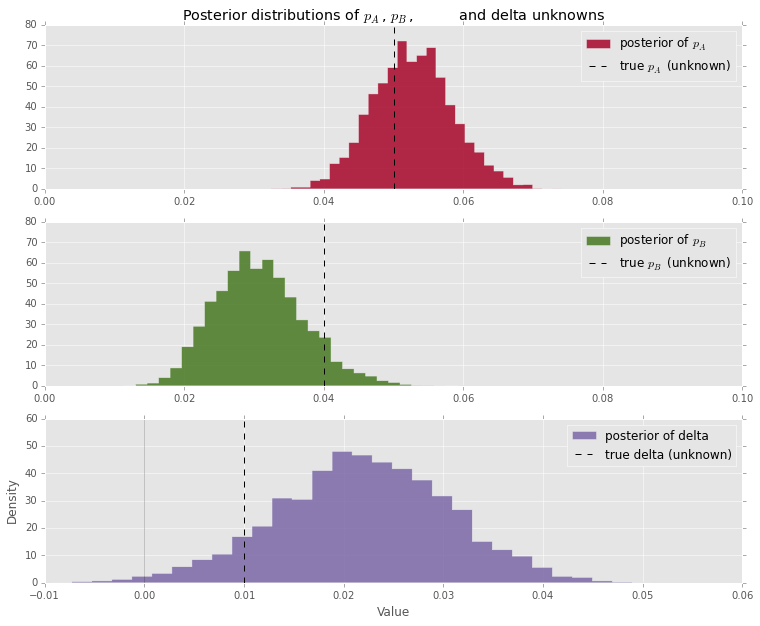

In [23]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

figsize(12.5, 10)

# histogram of posteriors 

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(true_p_A, 0, 80, linestyle="--",
           label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$,\
          and delta unknowns")
plt.ylim(0,80)

ax = plt.subplot(312)
plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(true_p_B, 0, 80, linestyle="--",
           label="true $p_B$ (unknown)")
plt.legend(loc="upper right")
plt.ylim(0,80)

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend(loc="upper right")

Notice that as a result of $N_B < N_A$ - that is, we have less data from site B - our posterior distribution for $p_B$ is fatter, implying we are less certain about the true value of $p_B$ than we are of $p_A$. This is easier to see if we plot thetwo posteriors on the same figure:

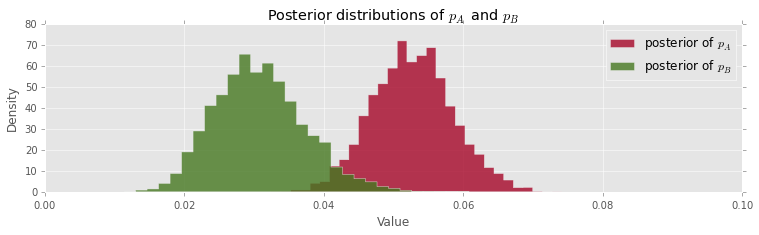

In [24]:
figsize(12.5, 3)

# histogram of posteriors 

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=30, alpha=0.80,
         label="posterior of $p_A$", color="#A60628", normed=True)

plt.hist(p_B_samples, histtype='stepfilled', bins=30, alpha=0.80,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.legend(loc="upper right")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Posterior distributions of $p_A$ and $p_B$")
plt.ylim(0,80);

With respect to the posterior distribution of delta, we can see in Figure 2.2.6 that the majority of the distribution is above delta = 0, implying that site A’s response is likely better than site B’s response. The probability that this inference is incorrect is easily computable:

In [25]:
# Count the number of samples less than 0, i.e., the area under the curve 
# before 0, representing the probability that site A is worse than site B. 
print "Probability site A is WORSE than site B: %.3f " % \
    (delta_samples < 0).mean()

print "Probability site A is BETTER than site B: %.3f " % \
    (delta_samples > 0).mean()

Probability site A is WORSE than site B: 0.008 
Probability site A is BETTER than site B: 0.992 


In [26]:
df = pd.DataFrame({'$p_A$': p_A_samples,
                  '$p_B$': p_B_samples,
                  '$\Delta$': delta_samples})

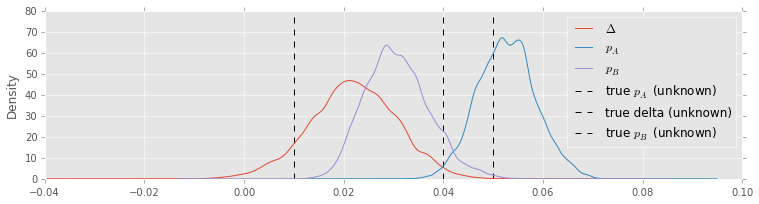

In [29]:
df.plot(kind='kde')
plt.vlines(true_p_A, 0, 80, linestyle="--",
           label="true $p_A$ (unknown)")
plt.vlines(true_p_A - true_p_B, 0, 80, linestyle="--",
           label="true delta (unknown)")
plt.vlines(true_p_B, 0, 80, linestyle="--",
           label="true $p_B$ (unknown)")
plt.legend()

can get the raw values of the kde from scipy:
http://stackoverflow.com/questions/24153278/how-to-get-output-of-pandas-plotkind-kde



If this probability is too high for cmopfortgable decision-making, we can perform more trials on site B (as site B has less samples to begin with, each additional data point for site B contributes more inferential "power" than each additional data point for site A).

Try playing with the parameters ```true_p_A, true_p_B, N_A```, and ```N_B``` to see what the posterior of delta looks like. Notice that in all this, the difference in sample sizes between site A and site B was never mentioned; it naturally fits into Bayesian analysis.

I hope the readers feel that this style of A/B testing is more natural than hypothesis testing, which has probably confused more than helped practioners. In Chapter 5, we will see two extensions of this model: the first to help dynamically adjust for good sites, and the second to improve the speed of this computation by reducing the analysis to a single equation (Conjugate priors).

## 6.2 Subjective versus Objective Priors


Bayesian priors can be classified into two classes. The first are **objective priors**, which aim to allow the data to influence the posterior the most. The second class are **subjective priors**, which allow the practitioner to express his or views in the prior.

### 6.2.1 Objective Priors

What is an example of an objective prior? We have seen some already, including the **flat prior**, which is a uniform distribution over the entire range of the unknown. Using a flat prior implies that we give each possible value an equal weighting. Choosing this type of prior is invoking what is called the **Principle of Indifference**: We have no prior reason to favor one value over another. Calling a flat prior over a restricted space an objective prior is not correct, though it seems similar. If we know $p$ in a binomial model is greater than 0.5, then Uniform(0.5, 1) is not an objective prior (since we have used external knowledge) even though that distribution is indeed "flat" over [0.5, 1]. The flat prior must be flat over the entire range of possibilities, including 0 to 0.5.

Aside from the flat prior, other examples of objective priors are less obvious, but they contain important characteristics that reflect objectivity. For now, it should be said that rarely is an objective prior _truly_ objective. We will see this later.


### 6.2.2 Subjective Priors

On the other, if we add more probability mass to certain areas of the prior, and less elsewhere, we are biasing our inference toward the parameters existing in the areas with more probability mass. This is known as a subjective, or _informative_ prior.

In the figure below, the subjective prior describes a belief that the unknown likely lives around 0.5, and not around the extremes. The objective prior is insensitive to this.


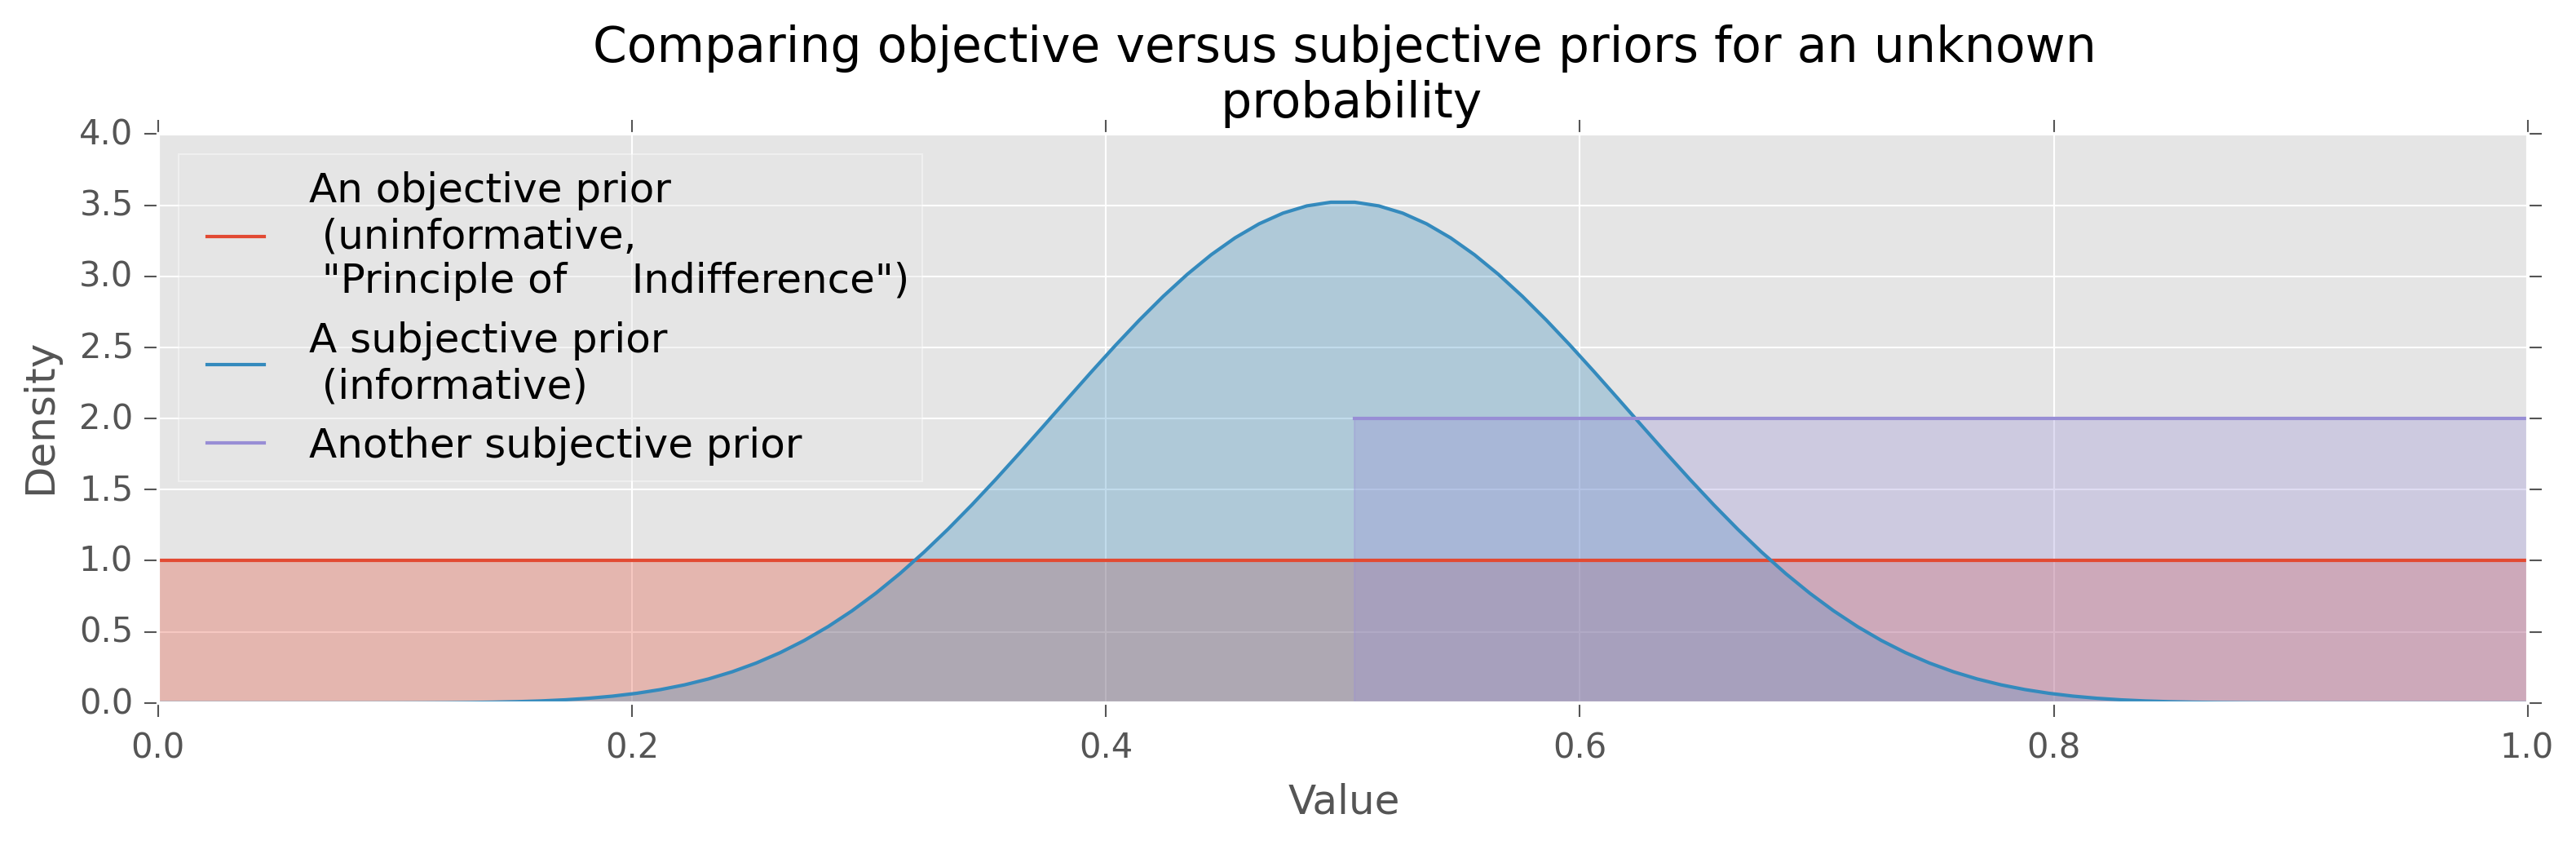

In [40]:
%matplotlib inline
import numpy as np 
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt 
import scipy.stats as stats 
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

figsize(12.5,3)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

x = np.linspace(0,1,100)
y1, y2 = stats.beta.pdf(x, 1, 1), stats.beta.pdf(x, 10, 10)

p = plt.plot(x, y1,
    label='An objective prior \n (uninformative, \n "Principle of\
     Indifference")')
plt.fill_between(x, 0, y1, color=p[0].get_color(), alpha=0.3)


p = plt.plot(x, y2,
     label='A subjective prior \n (informative)')
plt.fill_between(x, 0, y2, color=p[0].get_color(), alpha=0.3)


p = plt.plot(x[50:], 2*np.ones(50), label="Another subjective prior")
plt.fill_between(x[50:], 0, 2, color=p[0].get_color(), alpha=0.3)


plt.ylim(0, 4)

plt.ylim(0, 4)
leg = plt.legend(loc="upper left")
leg.get_frame().set_alpha(0.4)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Comparing objective versus subjective priors for an unknown \n probability");

The choice of a subjective prior does not always imply that we are using the practitioner's subjective opinion; more often, the subjective prior was once a posterior to a previous problem, and now the practitioner is updating this posterior with new data. A subjective prior can also beused ot inject domain knowledge of the problem into the model. We will see examples of these two situations later.

### 6.2.3 Decisions, Decisions ...

The choice of an objective or subjective prior mostly depends on the problem being solved, but there are a few cases where one is preferred over the other. In instances of scientific research, the choice of an objective prior is obvious, as this eliminates any biases in the results. It should be the case that two researchers with differing beliefs about the topic of research still feel that an objective prior is "fair."

Consider a more extreme situation: Suppose a tobacco company publishes a report with a Bayesian methodology that challenges sixty years of medical research on tobacco use. Would you believe the results? Unlikley. The researchers probably chose a subjective prior that too strongly biased results in their favor.

Unfortunately, choosing an objective prior is not as simple as selecting a flat prior, and even today, the problem is still not completely solved. The problem with naively choosing the uniform prior is that pathological issues can arise. Some of these issues are pendantic, but we will later see an exmple of when this can be an issue.

WE must remember that choosing a pior, whether subjective or objective, is still part of the modeling process. To quote Gelman:

```
[A]fter the model has been fit, one should look at the posterior distribution and see if it makes sense. If the posterior distribution does not make sense, this implies that additional prior knowledge is available that has not been included in the model, and that contradicts the assumptions of the prior distribution that has been used. It is then appropriate to go back and alter the prior distribution to be more consistent with this external knowledge.
```

If the posterior does not make sense to you, then clearly you had an idea of what the posterior _should_ look like (not t be confused with what one _hopes_ it will look like), implying that the current prior does not contain all the prior information and should be updated. At this point, we can discard the current prior and choose one more reflective of _all_ our prior information.

Gelman[2] suggests that using a uniform distribution with large bounds is often a good choice for objective priors. However, one should be wary about using uniform objective priors with large bounds, as they can assign too large of a prior probability to points that are extremely unintuitive. Ask yourself: Do you really think the unknown could be incredibly large? Often, quantities are naturally biased toward 0. A Normal random variable with large variance (small precision) might be a better choice, or an exponential variable with a fat tail in the strictly positive (or negative) case.




## 6.3 Useful Priors to Know About

In the following, we'll go over some distributions that are common in Bayesian analysis and methods

### 6.3.1 The Gamma Distribution

A Gamma random variable, denoted $X \sim \mbox{Gamma}(\alpha, \beta)$ is a random variable over the positve real numbers. It is infact a generalization of the Exponential random variable, that is, 

$
\mbox{Exp}(\beta) \sim \mbox{Gamma}(1, \beta)
$

This additional parameter allows the probability density function to have more flexibility, hence allowing the practitioner to express his or her subjective priors more accurately. The density function for a Gamma($\alpha, \beta$) random variable is:

$
f(x | \alpha, \beta) = \frac{ \beta^{\alpha} x^{\alpha -1} e^{-\beta x}}{\Gamma(\alpha)}
$

where $\Gamma(\alpha)$ is the gamma function.

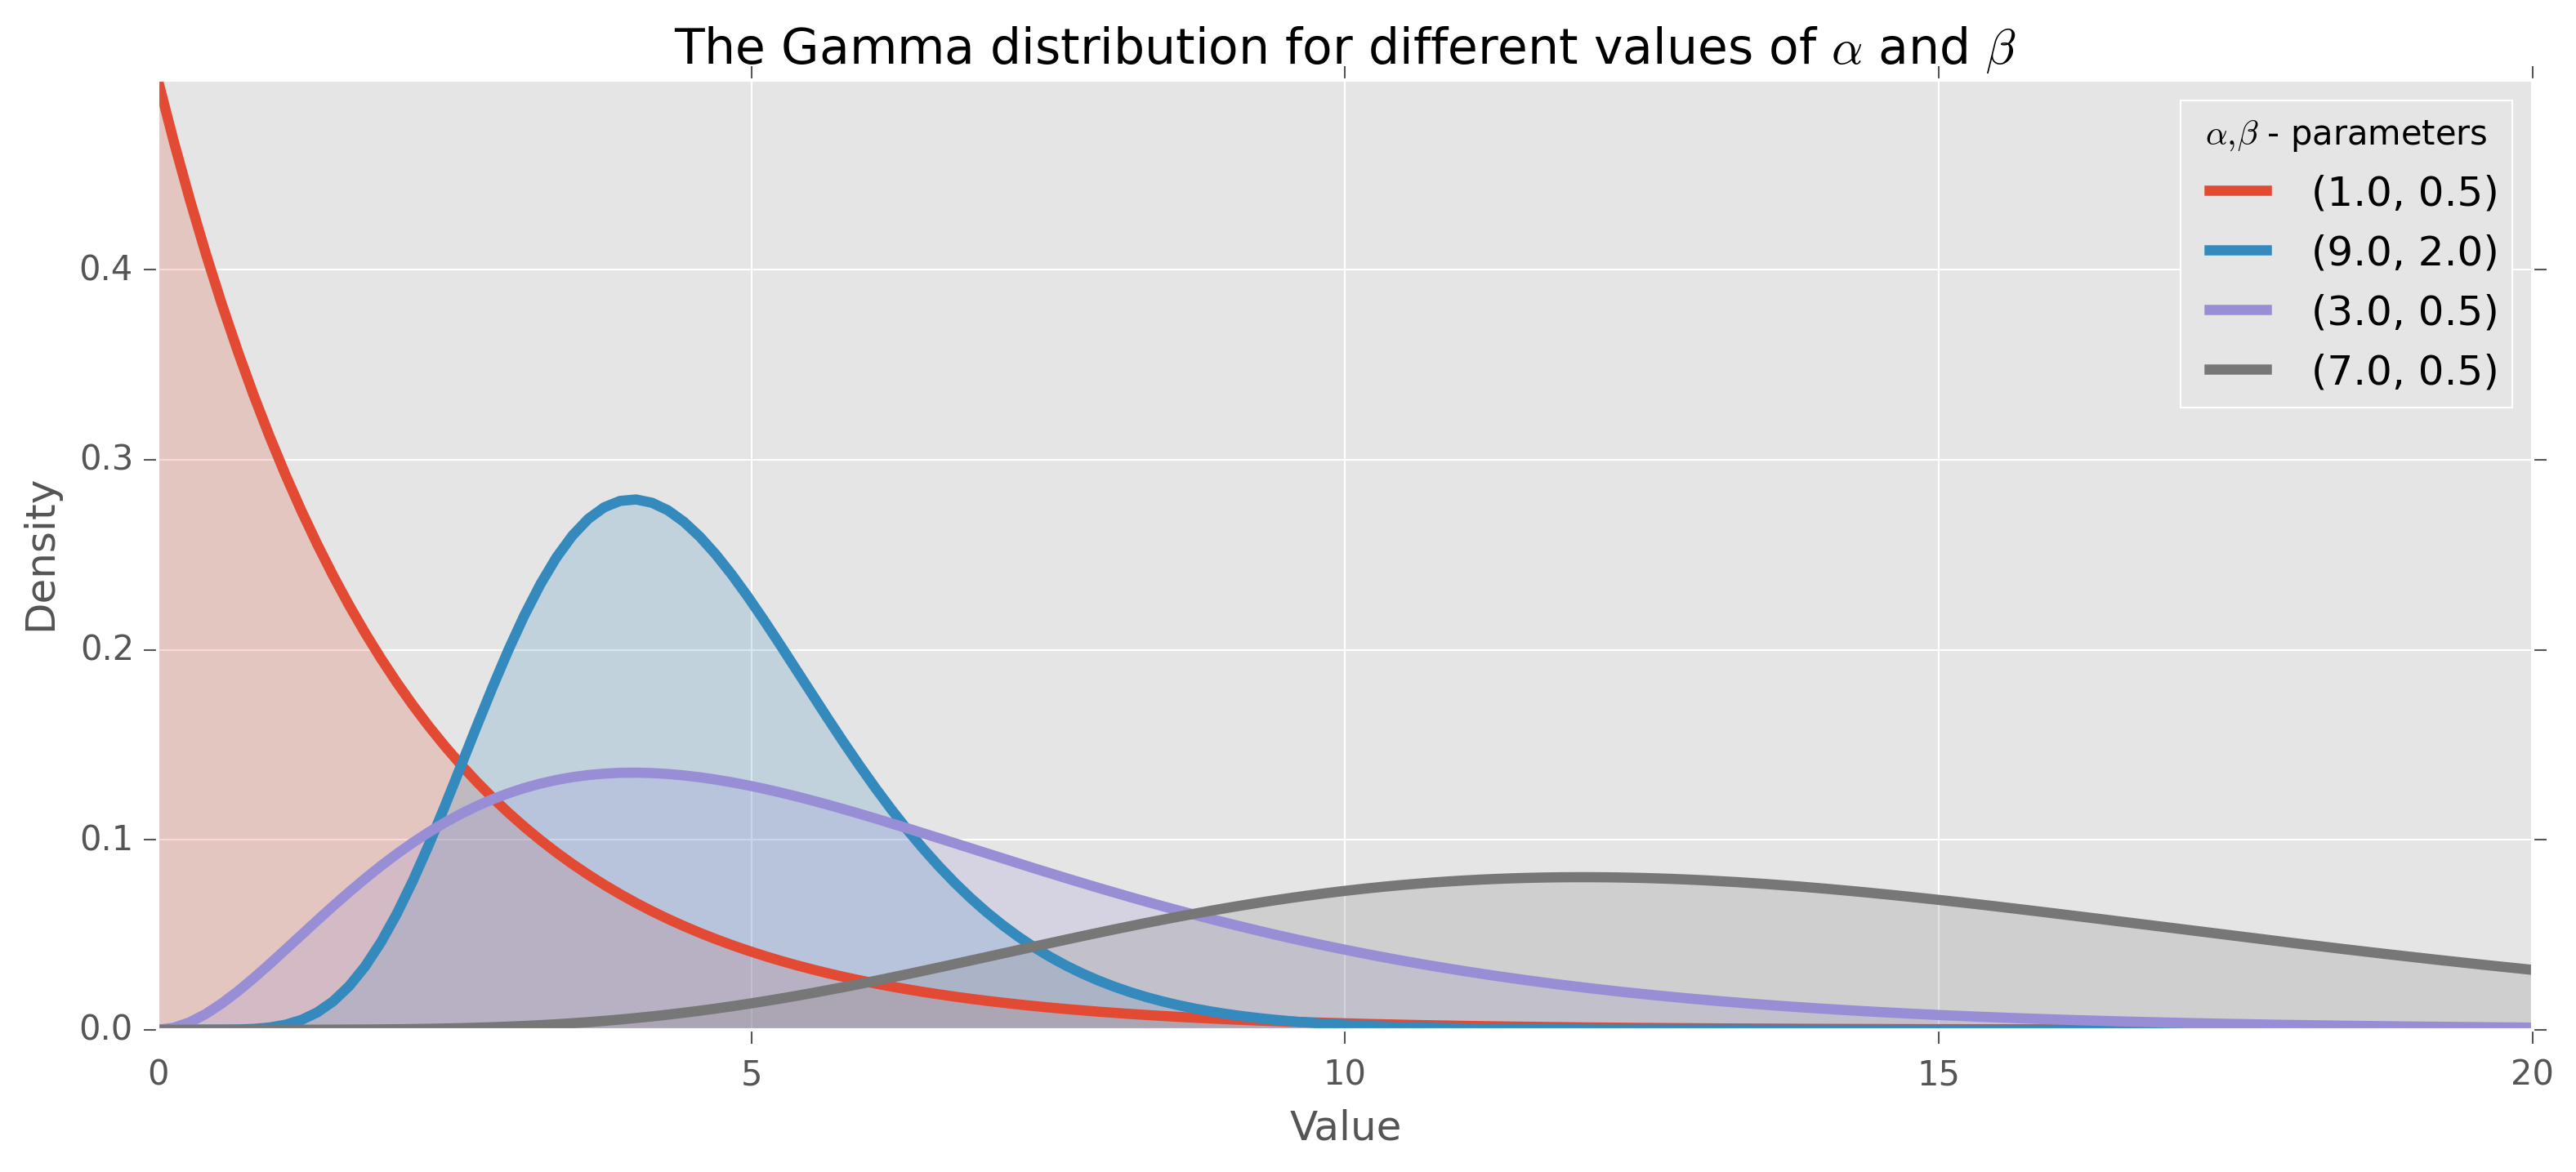

In [42]:
figsize(12.5, 5)
gamma = stats.gamma

parameters = [(1, 0.5), (9, 2), (3, 0.5), (7, 0.5)]

x = np.linspace(0.001, 20, 150)

for alpha, beta in parameters:
    y = gamma.pdf(x, alpha, scale=1./beta)
    lines = plt.plot(x, y, label="(%.1f, %.1f)" % (alpha, beta), lw=3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.legend(title=r"$\alpha, \beta$ - parameters")
plt.xlabel('Value')
plt.ylabel('Density')
plt.title(r"The Gamma distribution for different values of $\alpha$ and $\beta$")

### 6.3.3 The Beta Distribution

You may have seen the term ```beta``` in prevous code in this book. Often, I was implementing a **Beta distribution**. The Beta distribution is very useful in Bayesian statistics. A random variable $X$ has a Beta distribution, with parameters 
$(\alpha, \beta)$, if its density function is:

$
f_{X}(x | \alpha, \beta) = \frac{x^{(\alpha - 1)}(1 - x)^{(\beta - 1)}}{\mbox{B}(\alpha, \beta)}
$

In the previous equation, B is the beta function (hence the name). The Beta distribution defined random variables between 0 and 1, making it a popular choice for modeling probabilities and proportions. The values of $\alpha$ and $\beta$, both positive values, provide great flexibility in the shape of the distribution.

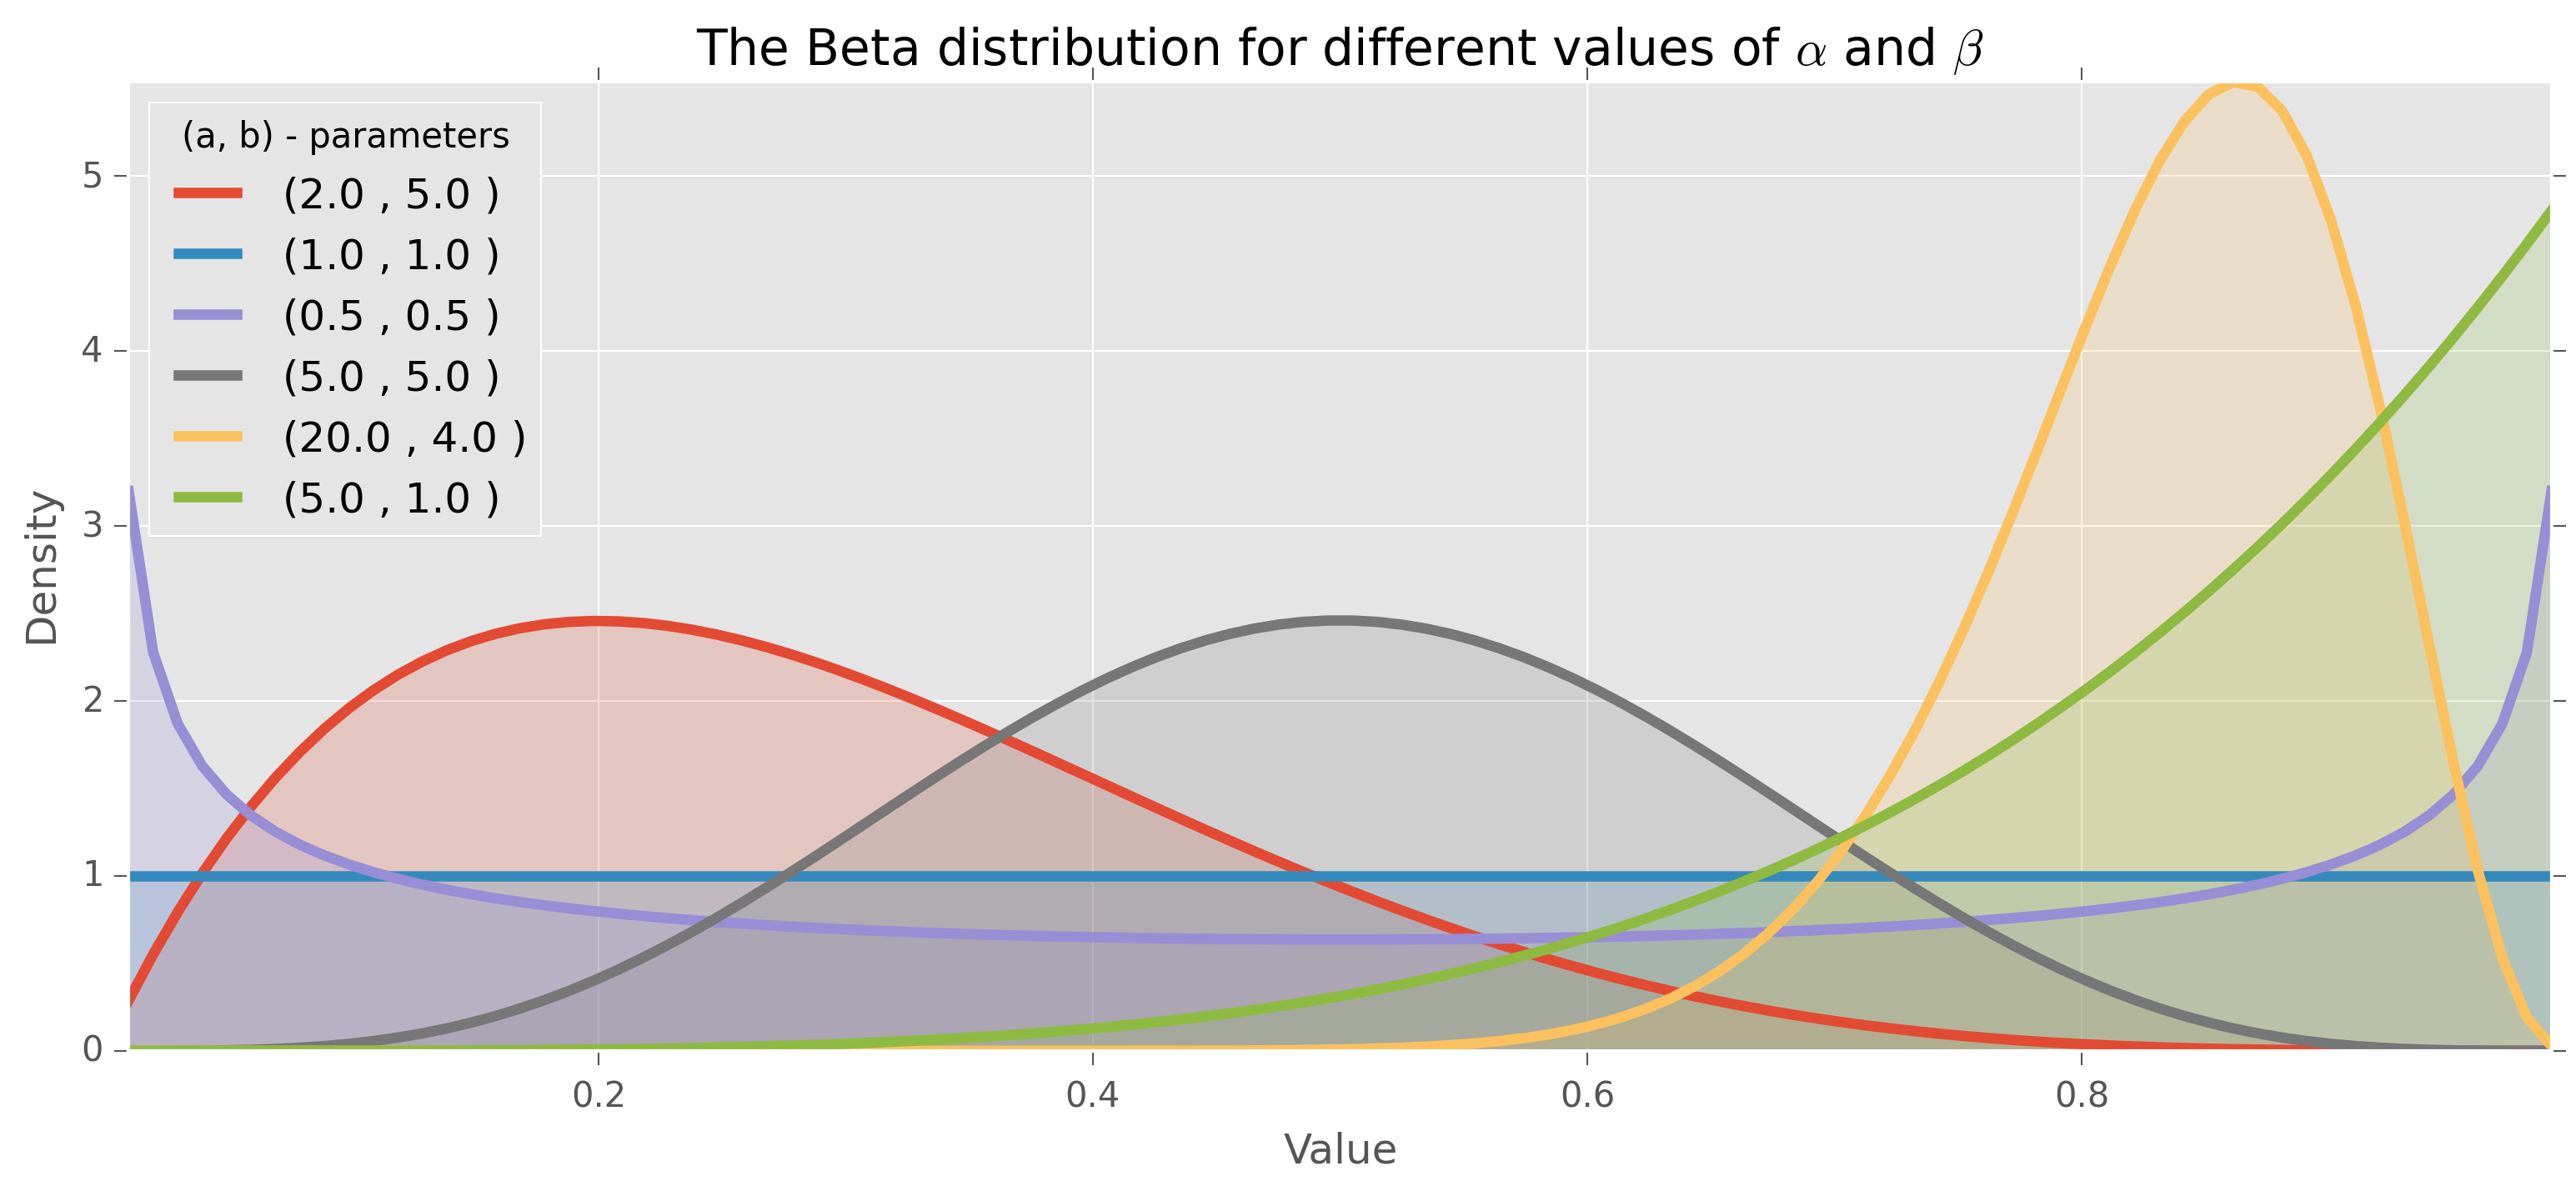

In [43]:
figsize(12.5, 5)

params = [(2,5), (1,1), (0.5, 0.5), (5,5), (20,4), (5,1)]

x = np.linspace(0.01, .99, 100)
beta = stats.beta
for a, b in params:
    y = beta.pdf(x, a, b)
    lines =  plt.plot(x, y, label="(%.1f , %.1f )" % (a, b), lw = 3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.ylim(0)
plt.legend(loc="upper left", title="(a, b) - parameters")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title(r"The Beta distribution for different values of $\alpha$ and $\beta$")

One thing I'd like the reader to notice is the presence of the flat distribution in the previous figure, specified by parameters (1,1). This is the uniform distribution. Hence, the Beta distribution is a generalization of the uniform distribution, something we will revisit many times.

There is an interesting connection between the Beta distibution and the binomial distribution.

https://en.wikipedia.org/wiki/Binomial_distribution

| Attribute | Value |
|:--------------:|:--------------------|
| Notation | B(n, p) | 
| Parameters | n $\in \mathbf{N}_{0}$ - number of trials, $p \in [0, 1]$ - success probability in each trial | 
| Support | $k \in (0, \cdots, n)$ - number of successes |
| pmf | ${n \choose k} p^{k} (1 - p)^{n-k}$ |

Suppose we are interested in some unknown proportion or probability $p$. We assign a Beta($\alpha, \beta$) prior to $p$.
We observe some data generated by a binomial process, say $X \sim \mbox{Binomial}(N, p)$, with $p$ still unknown.
Then our posterior _is again a Beta distribution_; that is, $p|X \sim \mbox{Beta}(\alpha + X, \beta + N - X)$.

Succinctly, one can relate the two: A Beta prior with binomial observations creates a Beta posterior. This is a very useful property, both computationally and heuristically.

To make this concrete, it we start with a Beta(1,1) prior on $p$ (which is a Uniform), observe data $X \sim $ Binomial(N, p), then our posterior is Beta(1 + X, 1 + N - X). For example, if we observe X = 10 successes out of N = 25 trials, then our posterior ofr $p$ is a Beta(1 + 10, 1 + 25 -10) = Beta(11, 16) distribution.

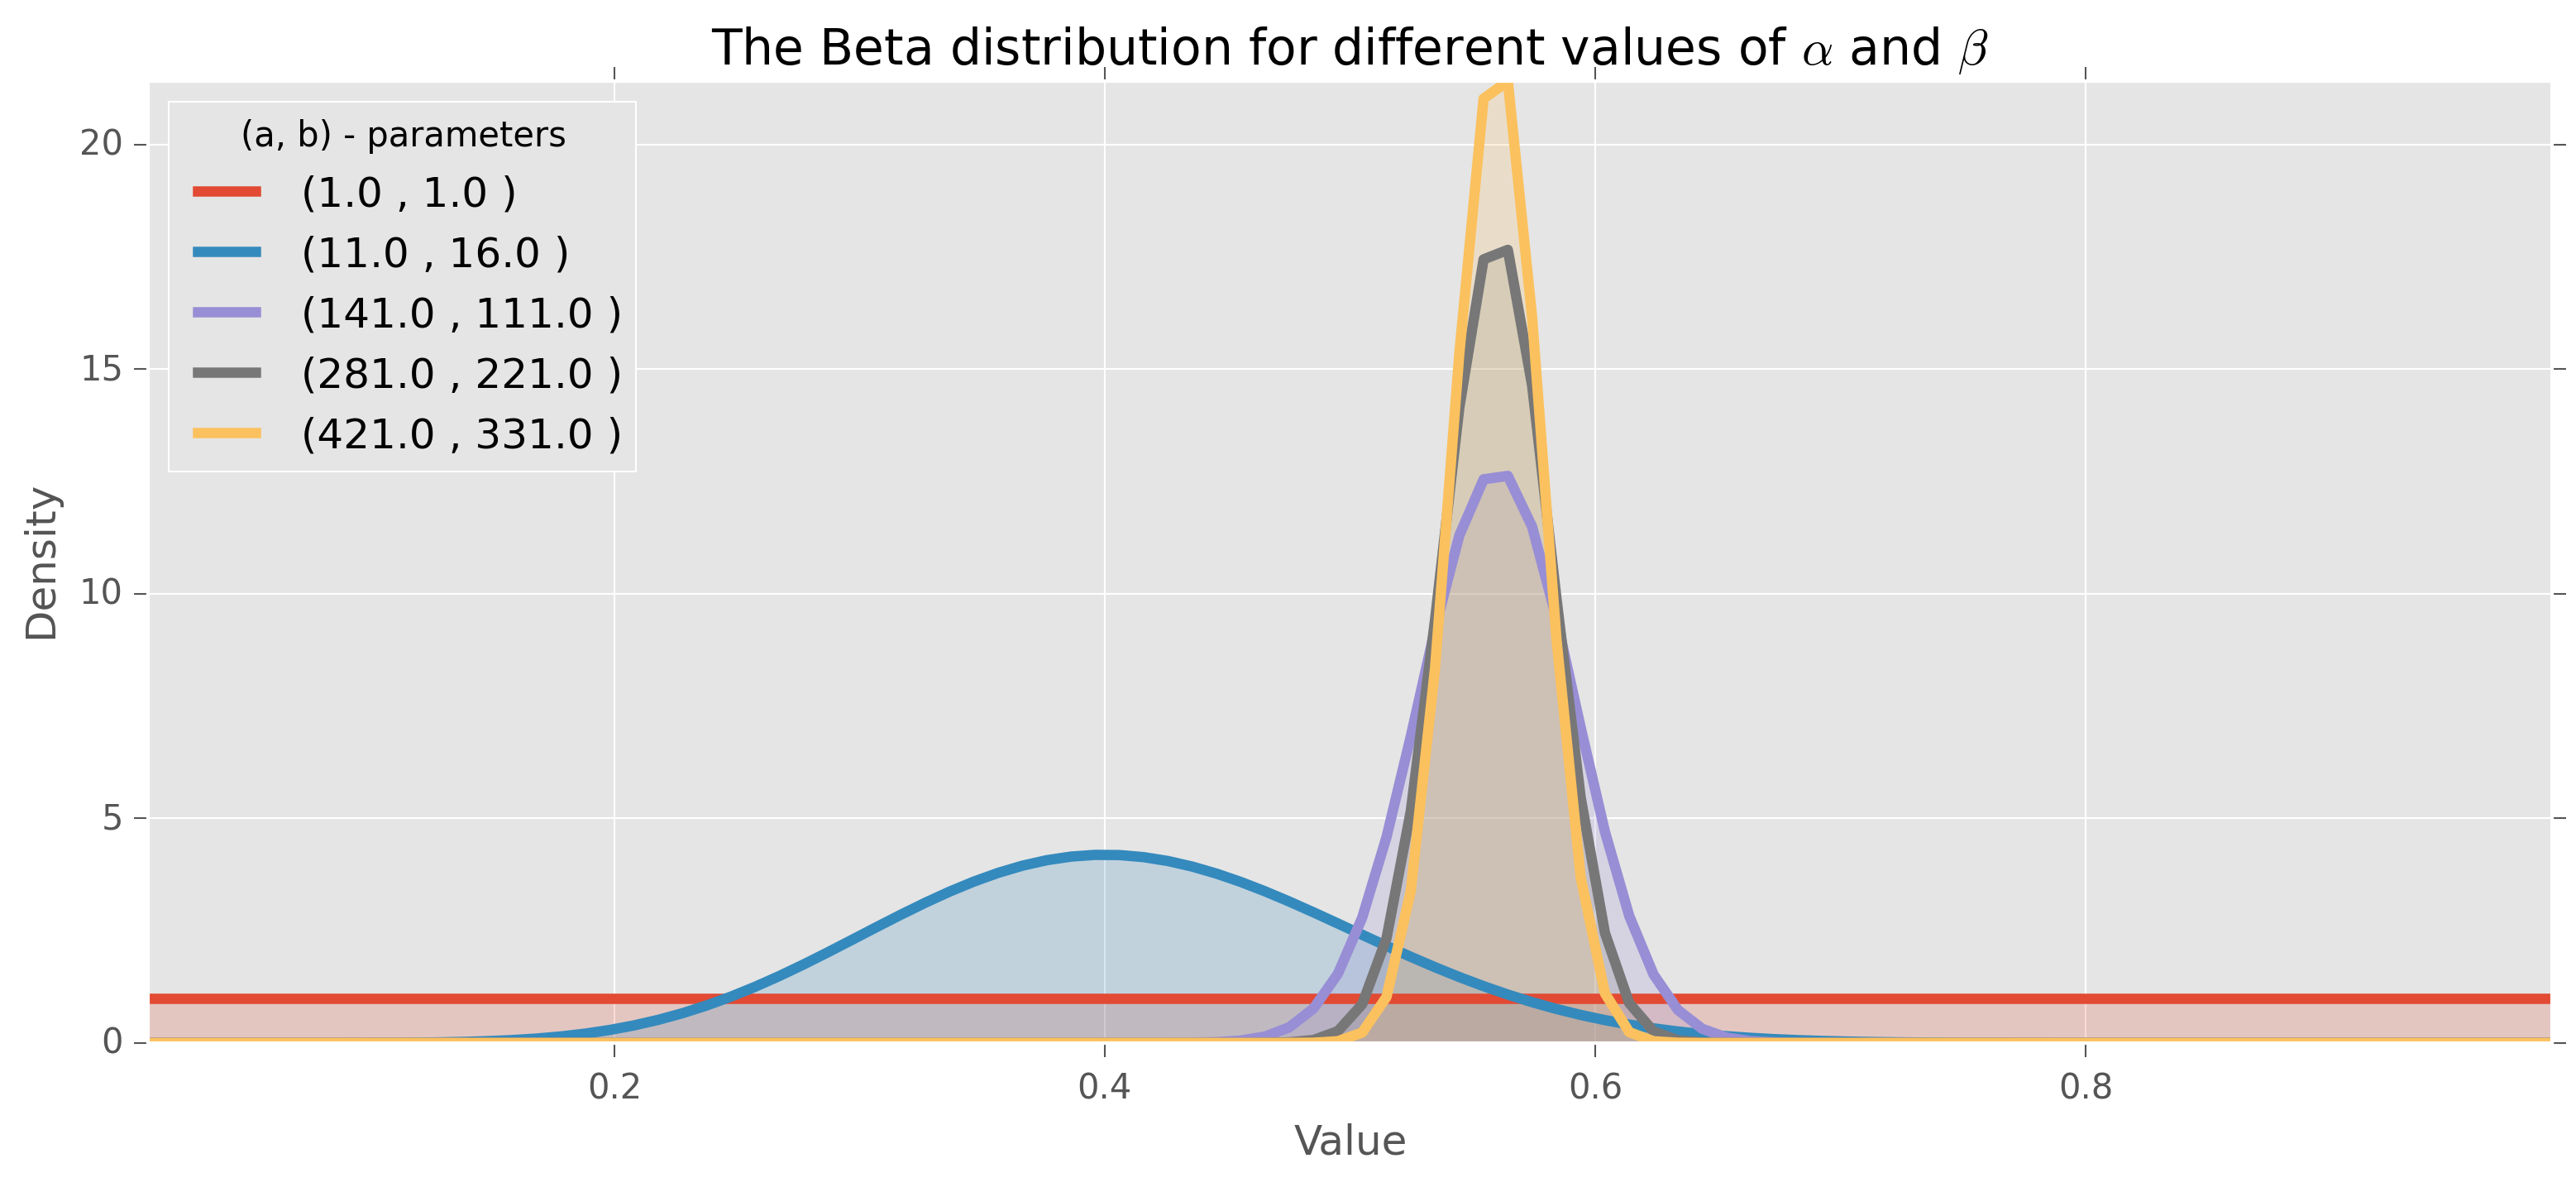

In [51]:
figsize(12.5, 5)

params = [(1,1), (11, 16), (1 + 140, 1 + 140 + 110 - 140), (141 + 140, 111 + 140 + 110 - 140),
         (281 + 140, 221 + 140 + 110 - 140)]

x = np.linspace(0.01, .99, 100)
beta = stats.beta
for a, b in params:
    y = beta.pdf(x, a, b)
    lines =  plt.plot(x, y, label="(%.1f , %.1f )" % (a, b), lw = 3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.ylim(0)
plt.legend(loc="upper left", title="(a, b) - parameters")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title(r"The Beta distribution for different values of $\alpha$ and $\beta$")

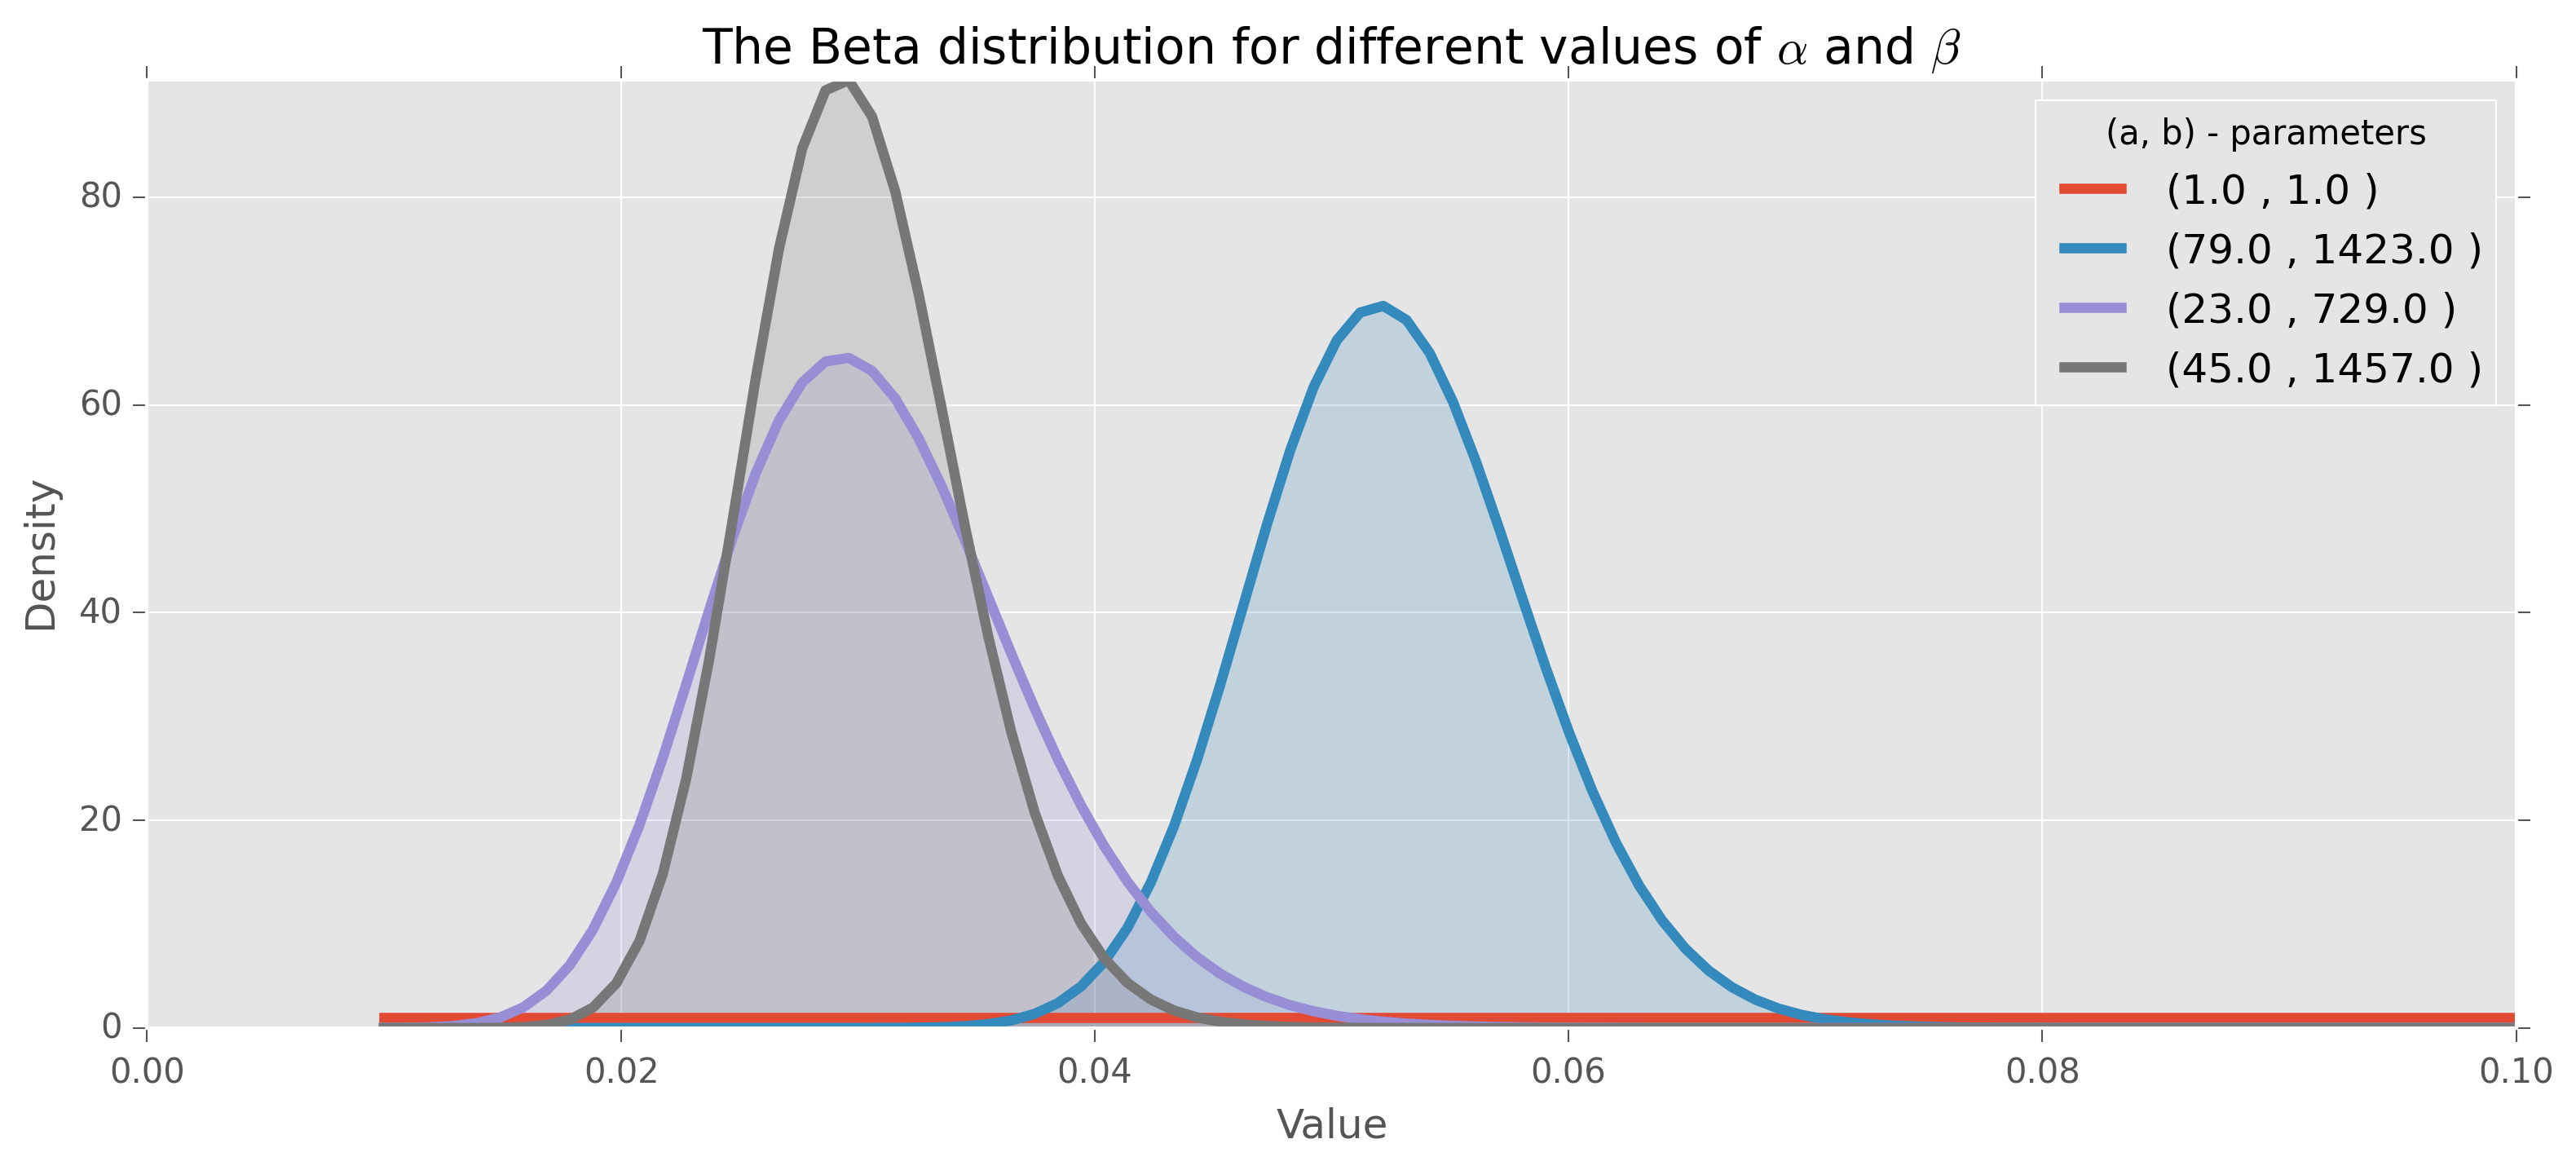

In [62]:
figsize(12.5, 5)

params = [(1,1), (1 + 78, 1 + 1500 - 78), (1 + 22, 1 + 750 -22), (23 + 22, 729 + 750 - 22)]

x = np.linspace(0.01, .99, 1000)
beta = stats.beta
for a, b in params:
    y = beta.pdf(x, a, b)
    lines =  plt.plot(x, y, label="(%.1f , %.1f )" % (a, b), lw = 3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.ylim(0)
plt.xlim(0,.1)
plt.legend(loc="upper right", title="(a, b) - parameters")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title(r"The Beta distribution for different values of $\alpha$ and $\beta$")

In [50]:
140./250

0.56

## 6.6 Conjugate Priors

Recall that a Beta prior with binomial data implies a Beta posterior. This is a reallu useful property. It allows us to avoid using MCMC, since the posterior is known in closed form. Hence inference and analytics are easy to derive. Fortunately, there is an entire family of distributions that have similar behavior.



## 7. Bayesian A/B Testing

### 7.1 Introduction

Part of a statiscian's or data scientist's goal is to be a champion of experiments, and one of the best tools for a data scientist is a well-designed split-test experiment. We've seen split-tests prevoiusly. In Chapter 2, we introduced Bayesian analysis of an A/B test on conversin rates for a Web site. This chapter will extend that analysis to new areas.


### 7.2 Conversion Testing Recap

The fundamental idea in an A/B test is that we consider a perfect counterfactual universe, where the population under study is identical but subject to some treatment, then any differences between the populations after the study must be attributed to the treatment. In practice, we can't spin up other unverses, so we rely on using large enough samles in two groups that _approximate_ a counterfactual.

Let's recall our example from Chapter 2: we have two Web site designs, called A and B. When a user lands on our Web site, we randomly show them design A or B, and record this assignment. After enough visitors have done this, we join this dataset against some metric of interest (typically, for Web sites, we are interested in a purchase or signup). For example, consider the following numbers:

In [66]:
visitors_to_A = 1300
visitors_to_B = 1275

conversions_from_A = 120
conversions_from_B = 125

What we are really interested in is the probability of a conversion, given site A or B. As a business, we want this probability to be as high as possible. So our goal is to determine which site, A or B, has a high probability of conversion.

To do this, we'll model the probability of conversion given site A, or site B. Since we are modeling a probability, a good choice for a prior distribution is the Beta distribution. (Why? It is restricted to values between 0 and 1, identical to the range that probabilities can take on.) Our number of visitors and conversion data are binomial: for site A, out of 1300 _trials_, we had 120 _successes_. You'll recall from Chapter 6 that a Beta prior and binomial observatins have a conjugate relationship: this means we don't need to perform any MCMC!

If my prior is Beta($\alpha_0, \beta_0$), and I observe N trials and X successes, then my posterior is 
Beta($\alpha_0 + X, \beta_0 + N - X)$. Using the built in ```beta``` function from scipy, we can directly sample from the posterior.

Let's suppose our prior is a Beta(1,1); recall that this is identical to a uniform distribution on [0, 1].

In [67]:
from scipy.stats import beta
alpha_prior = 1
beta_prior = 1

posterior_A = beta(alpha_prior + conversions_from_A,
                  beta_prior + visitors_to_A - conversions_from_A)

posterior_B = beta(alpha_prior + conversions_from_B,
                  beta_prior + visitors_to_B - conversions_from_B)






Next, we'd like to determine which group has a large probability of conversion. To do this, similar to MCMC, we use samples from the posterior and compare the probability that samples from the posterior of A are larger than samples from the posterior of B.
We use the ```rvs```method to generate samples.

In [84]:
samples = 2000000 # We want this to be large to get a better approximation

samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)

print (samples_posterior_A > samples_posterior_B).mean()

0.310093


So we can see here that there is a 31% chance that site A converts better than site B. (Conversely, there is a 69% chance that site B converts better than A.) This is not very significant; consider that if we reran this experiment with identical pages, it would return a probability close to 50%.

We can visualize the posterior, too, without using histograms. This is done by using the ```pdf``` method. 

(0.05, 0.15)

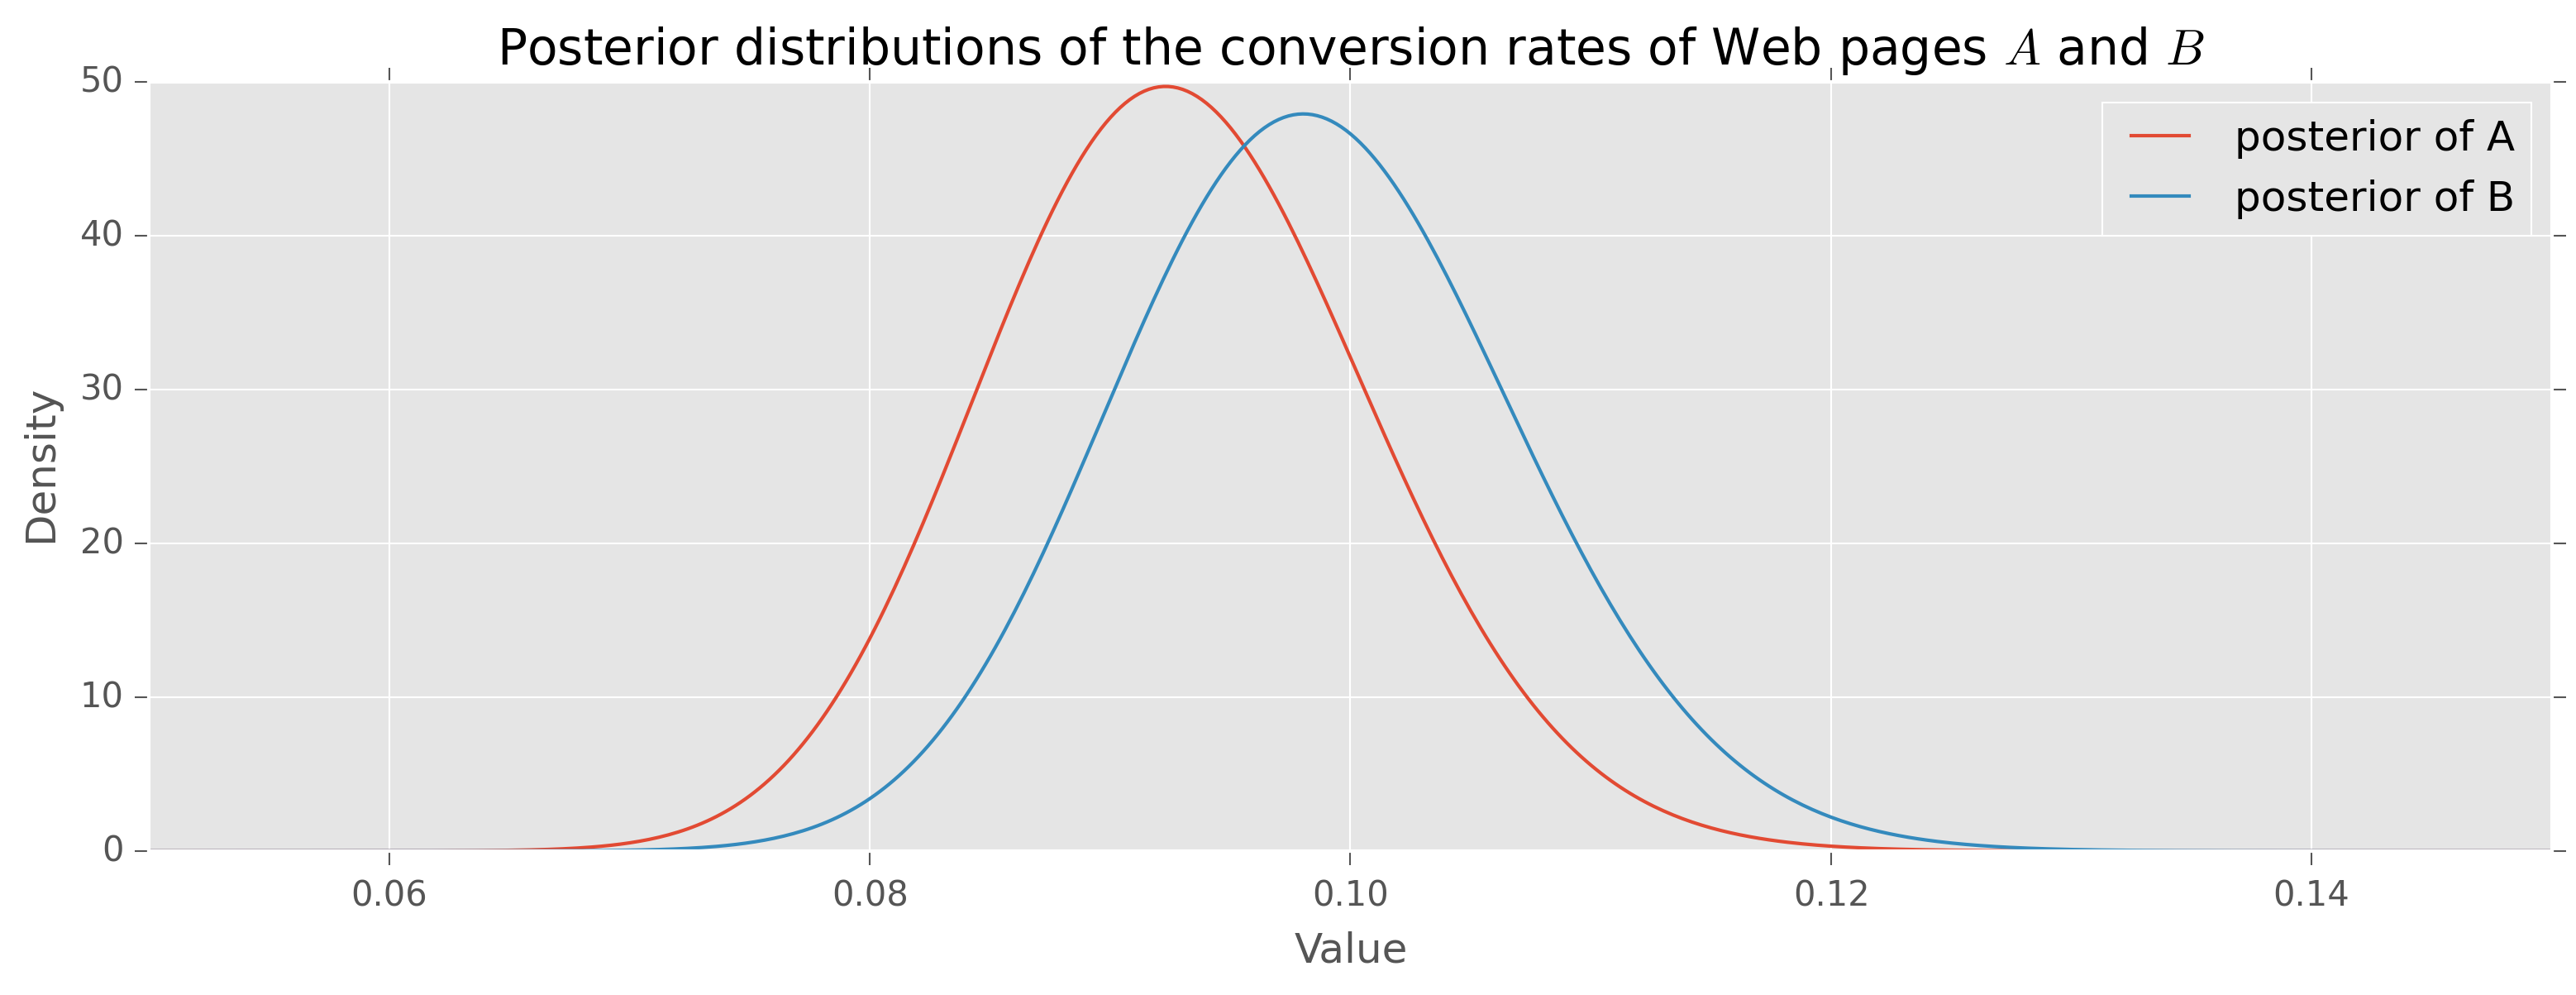

In [89]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
x = np.linspace(0,1, 5000)
plt.plot(x, posterior_A.pdf(x), label='posterior of A')
plt.plot(x, posterior_B.pdf(x), label='posterior of B')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the conversion rates of Web pages $A$ and $B$")
plt.legend()
plt.xlim(0.05,.15)

Conversion tests are popular because of their simplicty: The observable is binary and the analysis is straitforward. What happens when you have multiple paths a user could take, and there are business implications for each path? We'll explore this next.

## Comparing Coors Field with Yankee Stadium

First, let's collect the data from last year's MLB season on the total ABs and HRs in Coors Field and Yankee Stadium and see if the Bayes's posteriors of the probablity of hitting a home run show a significant difference between the two. I think this difference should be around the same as Radiation Therapy verusu Proton Therapy for some complications.


http://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=0&type=8&season=2015&month=0&season1=2015&ind=0&team=0,ts&players=0

Actually, let's compare Rockies vs Yankees   .  Half of their games are home games, so we should see an effect anyway.

Could also look at stolen bases versus caught stealing

Rockies had 186 home runs in 6071 plate appearances

Yankees had 212 home runs in 6268 plate appearances


Maybe just compare American League vs National League.  You would expect the American League to be demonstrably different because of the designated hitter.

AL :   2634 HR in 91837 PA

NL :   2275 HR in 91790 PA

OK. Lets check what percentage confidence the Bayes method with a uniform beta prior predicts the AL has more home runs. IT better be over 50% or else the method sucks.

In [93]:
AL_PA = 91837
NL_PA = 91790

AL_HR = 2634
NL_HR = 2275

from scipy.stats import beta
alpha_prior = 1
beta_prior = 1

posterior_AL = beta(alpha_prior + AL_HR, beta_prior + AL_PA - AL_HR)

posterior_NL = beta(alpha_prior + NL_HR, beta_prior + NL_PA - NL_HR)


samples = 200000

samples_posterior_AL = posterior_AL.rvs(samples)

samples_posterior_NL = posterior_NL.rvs(samples)

print (samples_posterior_AL > samples_posterior_NL).mean()

1.0


So we can say we are **certain** that the AL is **better** at hitting home runs than the NL. Great.

(0.02, 0.04)

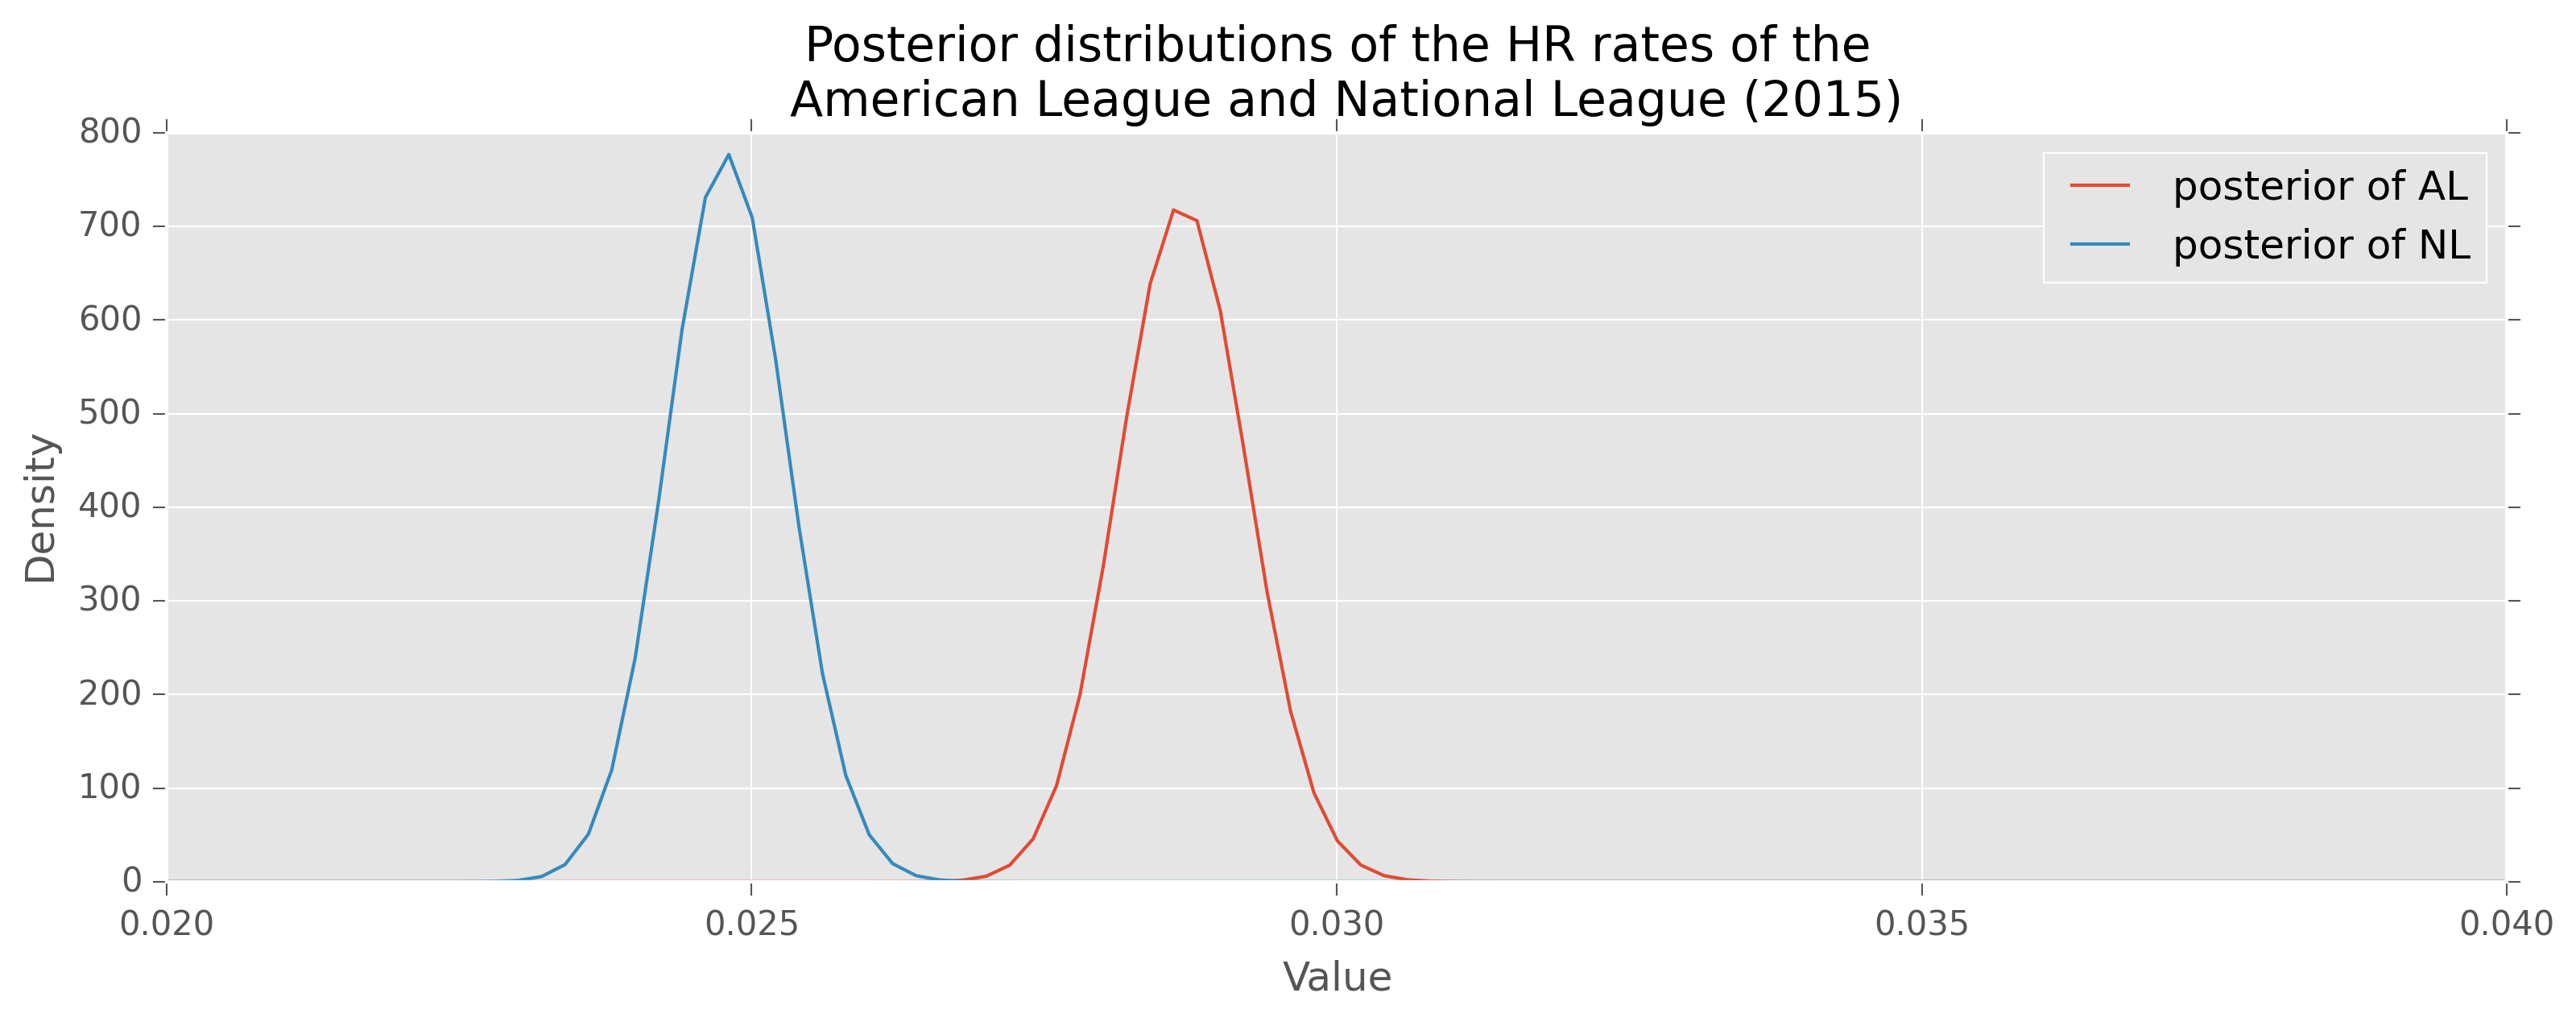

In [97]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
x = np.linspace(0,1, 5000)
plt.plot(x, posterior_AL.pdf(x), label='posterior of AL')
plt.plot(x, posterior_NL.pdf(x), label='posterior of NL')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the HR rates of the \n American League and National League (2015)")
plt.legend()
plt.xlim(0.02,0.04)

OK, but what about speed and base stealing? Its a consequence of the DH that there is less base stealing in the AL than in the NL. So we expect that the Bayeisan analsysis should also lead us to the conclusion that the National League is **better** at stealing bases than the slothful American League. Let's check. 
Much smaller numbers than in the HR / PA example above. See how it handles the small numbers:


National League:  SB: 1320,  CS: 531


American League:  SB: 1185,  CS: 533



In [100]:
NL_SB = 1320
NL_CS = 531
NL_ATTEMPTS = NL_SB + NL_CS

AL_SB = 1185
AL_CS = 533
AL_ATTEMPTS = AL_SB + AL_CS


from scipy.stats import beta
alpha_prior = 1
beta_prior = 1

posterior_AL_SB = beta(alpha_prior + AL_SB,
                    beta_prior + AL_ATTEMPTS - AL_SB)

posterior_NL_SB = beta(alpha_prior + NL_SB,
                    beta_prior + NL_ATTEMPTS - NL_SB)

samples = 2000000 # We want this to be large to get a better approximation. 
samples_posterior_AL_SB = posterior_AL_SB.rvs(samples)
samples_posterior_NL_SB = posterior_NL_SB.rvs(samples)

print (samples_posterior_NL_SB > samples_posterior_AL_SB).mean()



0.936638


So we are 93.6% certain that the National League is **better** at stealing bases than the American League, which is certainly true.

(0.6, 0.8)

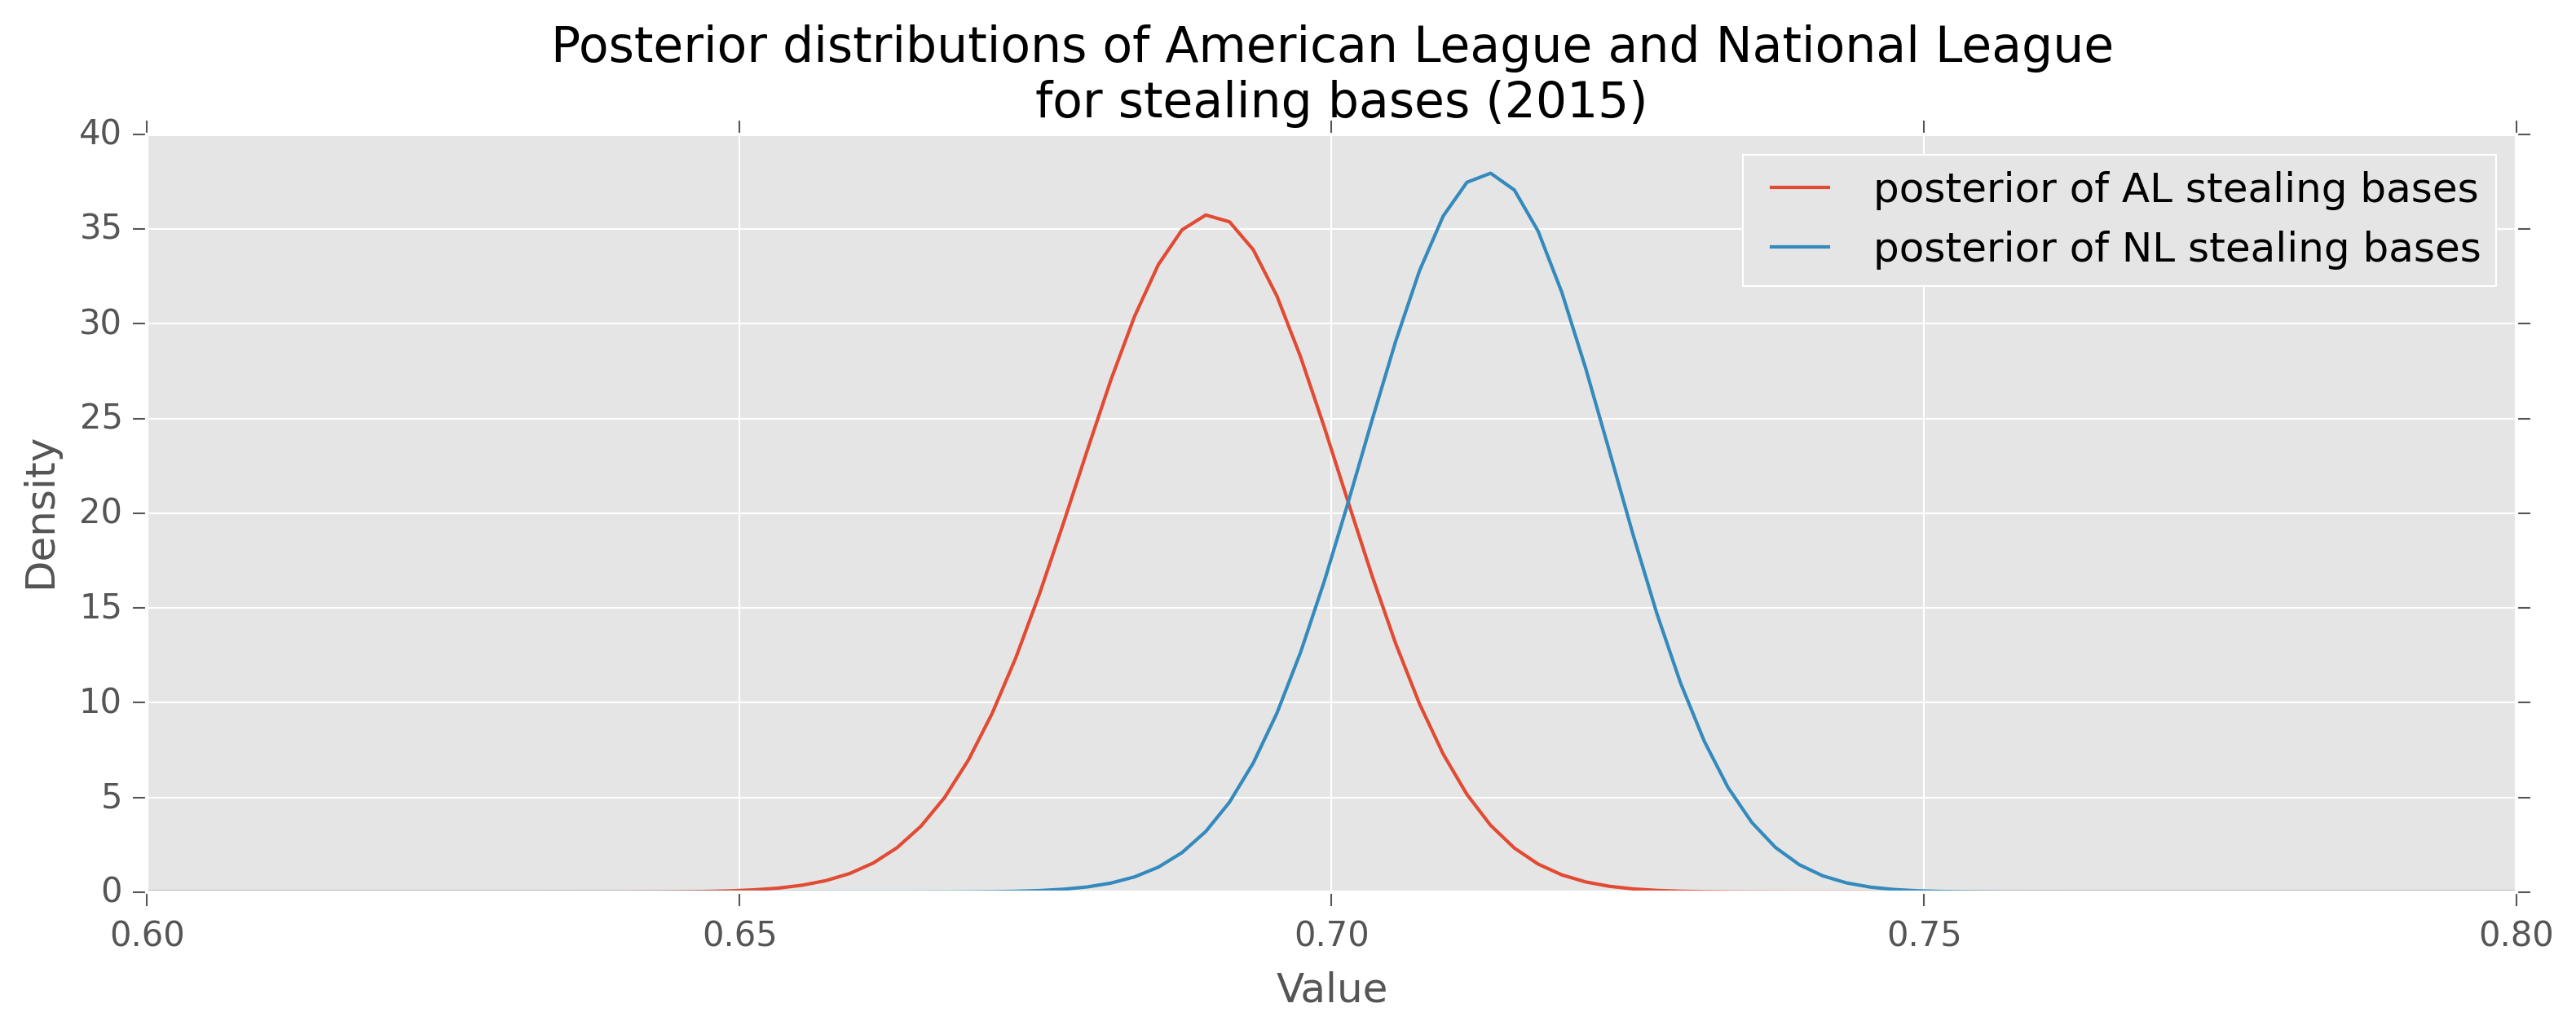

In [102]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
x = np.linspace(0,1, 500)
plt.plot(x, posterior_AL_SB.pdf(x), label='posterior of AL stealing bases')
plt.plot(x, posterior_NL_SB.pdf(x), label='posterior of NL stealing bases')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of American League and National League \n for stealing bases (2015)")
plt.legend()
plt.xlim(0.6,0.8)

Can perform the same analysis for state comparisons in the data at this Community Commons site:


http://www.communitycommons.org/maps-data/

Lets compare "Mortality - Motor Vehicle Accident" rates in Colorado (number per 100,000 population) vs those in Utah.

I'm guessing it will be lower in Utah because of the Mormon factor, and anecdotal stories of how fast people drive in Colorado.

Its under "Health Outcomes":

First get the data:

| Report Area | Total Population | Average Annual Deaths, 2007-2011 | 
|:------------:|:---------------:|:--------------------------------:|
| Colorado | 5,114,827 | 490 |
| Utah | 2,812,137 | 237 |





In [103]:
utah_pop = 2812137
utah_crash = 237

colorado_pop = 5114827
colorado_crash = 490

from scipy.stats import beta
alpha_prior = 1
beta_prior = 1

posterior_utah = beta(alpha_prior + utah_crash,
                    beta_prior + utah_pop - utah_crash)

posterior_colorado = beta(alpha_prior + colorado_crash,
                    beta_prior + colorado_pop - colorado_crash)


samples = 20000 # We want this to be large to get a better approximation. 
samples_posterior_utah = posterior_utah.rvs(samples)
samples_posterior_colorado = posterior_colorado.rvs(samples)

print (samples_posterior_colorado > samples_posterior_utah).mean()

0.94785


So we can say we are 94.7% certain that Colorado drivers are more dangerous than Utah drivers!

In [106]:
490./5114827

9.579991659541955e-05

(0, 0.0002)

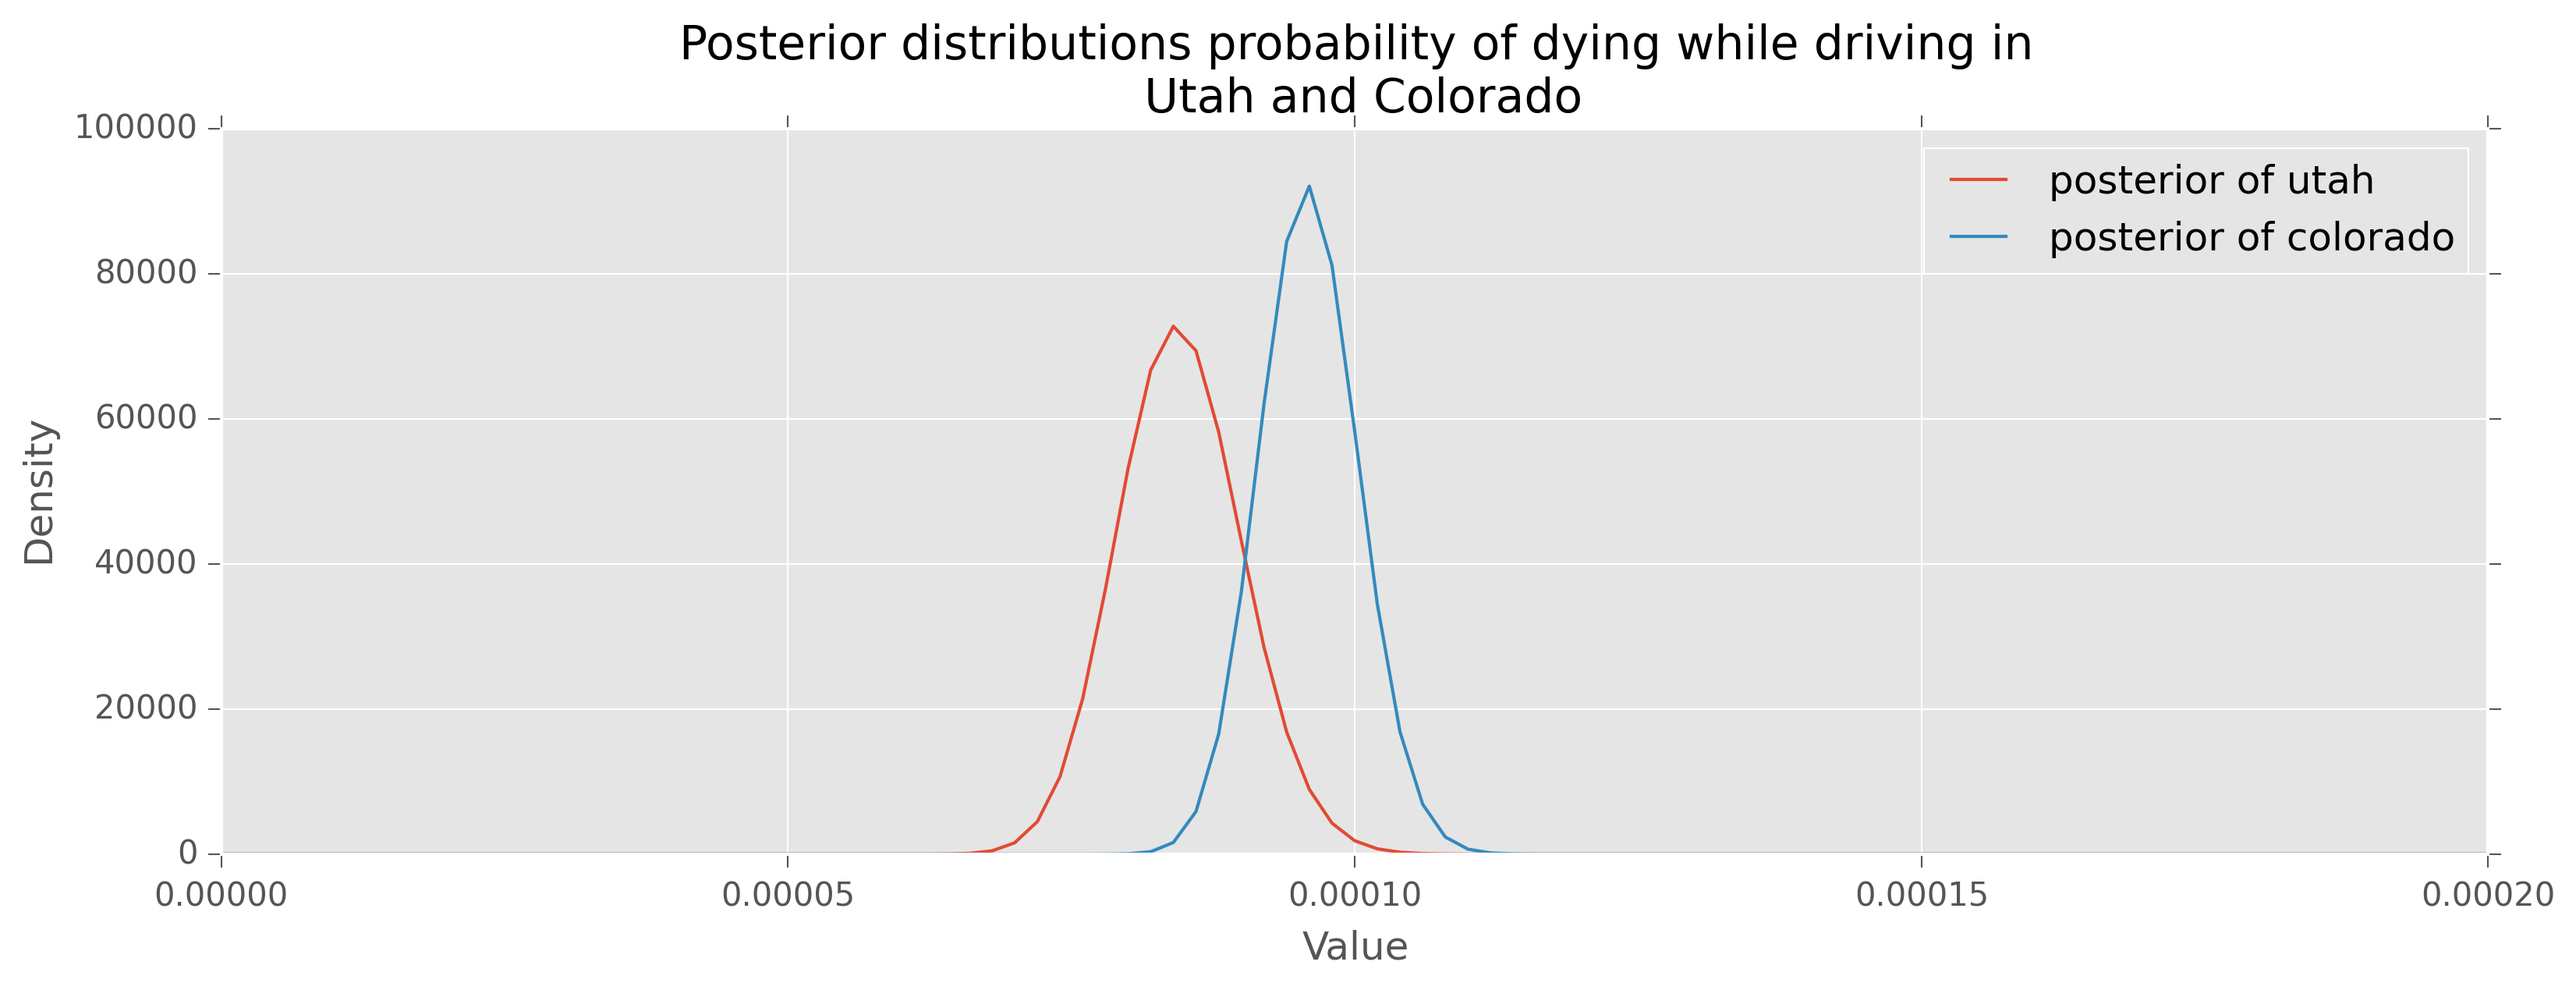

In [110]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
x = np.linspace(0,1, 500000)
plt.plot(x, posterior_utah.pdf(x), label='posterior of utah')
plt.plot(x, posterior_colorado.pdf(x), label='posterior of colorado')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions probability of dying while driving in \n Utah and Colorado")
plt.legend()
plt.xlim(0,.0002)

Conversion tests are popular because of their simplicity: The observable is binary and the analysis is straightforward. What happens when you have multiple paths a user could take, and there are business implications for each path? We'll explore this next.

## 7.3 Adding a Linear Loss Function

A common goal of Internet companies is not only to gain signups, but also to optimize which signup plan the user might select. 
For example, a business might want new customers to choose a higher-priced plan if presented with two or more plan options.

Suppose users are shown two different versins of this pricing page, and we'd like to determine the _expected revenue_ we receive per impression. Our previous A/B test analysis was only concerned with whether the user signed up or not; now, we want to know what the expected revenue to be earned is.

## 7.4 Going Beyond Conversions: t-test

Probably the most taught statistical test in classrooms is the **t-test**. The traditional t-test is a frequentist test to determine if a sample average deviates far from a predetrermined value. There is a Bayesian version of the t-test, popularized by John K. Kruschke, that will be used here. This model is called BEST, for _Bayesian EStimation Supersedes the t-test_. The orginal paper by Kruschke is very accessible, and I highly reacommend reading it.

### 7.4.1 The Setup for the t-test

Following our A/B testing theme, suppose we have data about the length of time a user is on a test page.
This data is not binary; it's continuous. For example, we'll create some artificial data with the following code:

In [111]:
N = 250
mu_A , std_A = 30, 4
mu_B, std_B = 26, 7

# create durations (seconds) users are on the pages for
durations_A = np.random.normal(mu_A, std_A, size=N)
durations_B = np.random.normal(mu_B, std_B, size=N)

Keep in mind that in real life, we do not see the parameters in the previous block of code; we just see the output

In [112]:
print durations_A[:8]
print durations_B[:8]

[ 38.01240303  28.33452739  30.19630994  30.80189082  28.47469255
  35.07418438  35.08723186  31.06652503]
[ 23.10249025  26.31902614  32.24066317  33.90188789  24.22852777
  20.94197191  28.42990369  29.11672609]


Our task is to determine on which page, A or B, users stay longer. We have five unknowns for this model, two mean parameters (denoted by $\mu$), two standard deviation parameters (denoted by $\sigma$), and one additional mode parameter unique to t-tests: $\nu$. The $\nu$ parameter sets how likely we are to see large outliers in our data. According to the BEST model, our
priors for the unknowns are as follows:

1. $\mu_A$ and $\mu_B$ come from a Normal distribution with prior mean equal to the pooled mean of data from A and B, and prior standard deviation equal to 1,000 times the pooled standard deviation. (This is a very wide, uninformative prior.)

In [113]:
import pymc as pm

pooled_mean = np.r_[durations_A, durations_B].mean()

pooled_std = np.r_[durations_A, durations_B].std()

tau = 1./np.sqrt(1000.*pooled_std)  # PyMC uses a precision parameter, 1/sigma**2

mu_A = pm.Normal("mu_A", pooled_mean, tau)
mu_B = pm.Normal("mu_B", pooled_mean, tau)



$\sigma_A$ and $\sigma_B$ come from a uniform distribution, restricted to one one-thousandth of the pooled standard deviation, to 1000 times the standard deviation (Again, a very wide uninformative prior)

In [114]:
std_A = pm.Uniform("std_A", pooled_std/1000., 1000.*pooled_std)
std_B = pm.Uniform("std_B", pooled_std/1000., 1000.*pooled_std)

## 7.5 Estimating the Increase

Decision makers, after an A/B test, are often interested in the _size_ of the increase. This is wrong, and I label this confusing the **continuous problem** with the **binary problem**. The continuous problem is trying to measure _how much better_ one is (a continuous range of possible values), and hte binary problem is trying to determine _which is better_ (only two possible values). The problem is that answering the continuous problem requires orders of magnitude more data than answering the binary problem, but businesses want to use the binary problem's anwwer to answer the continuous problem.
In fact, the most common statistical tests attempt only to answer the binary problem, which is what we have done in the preceding sections.



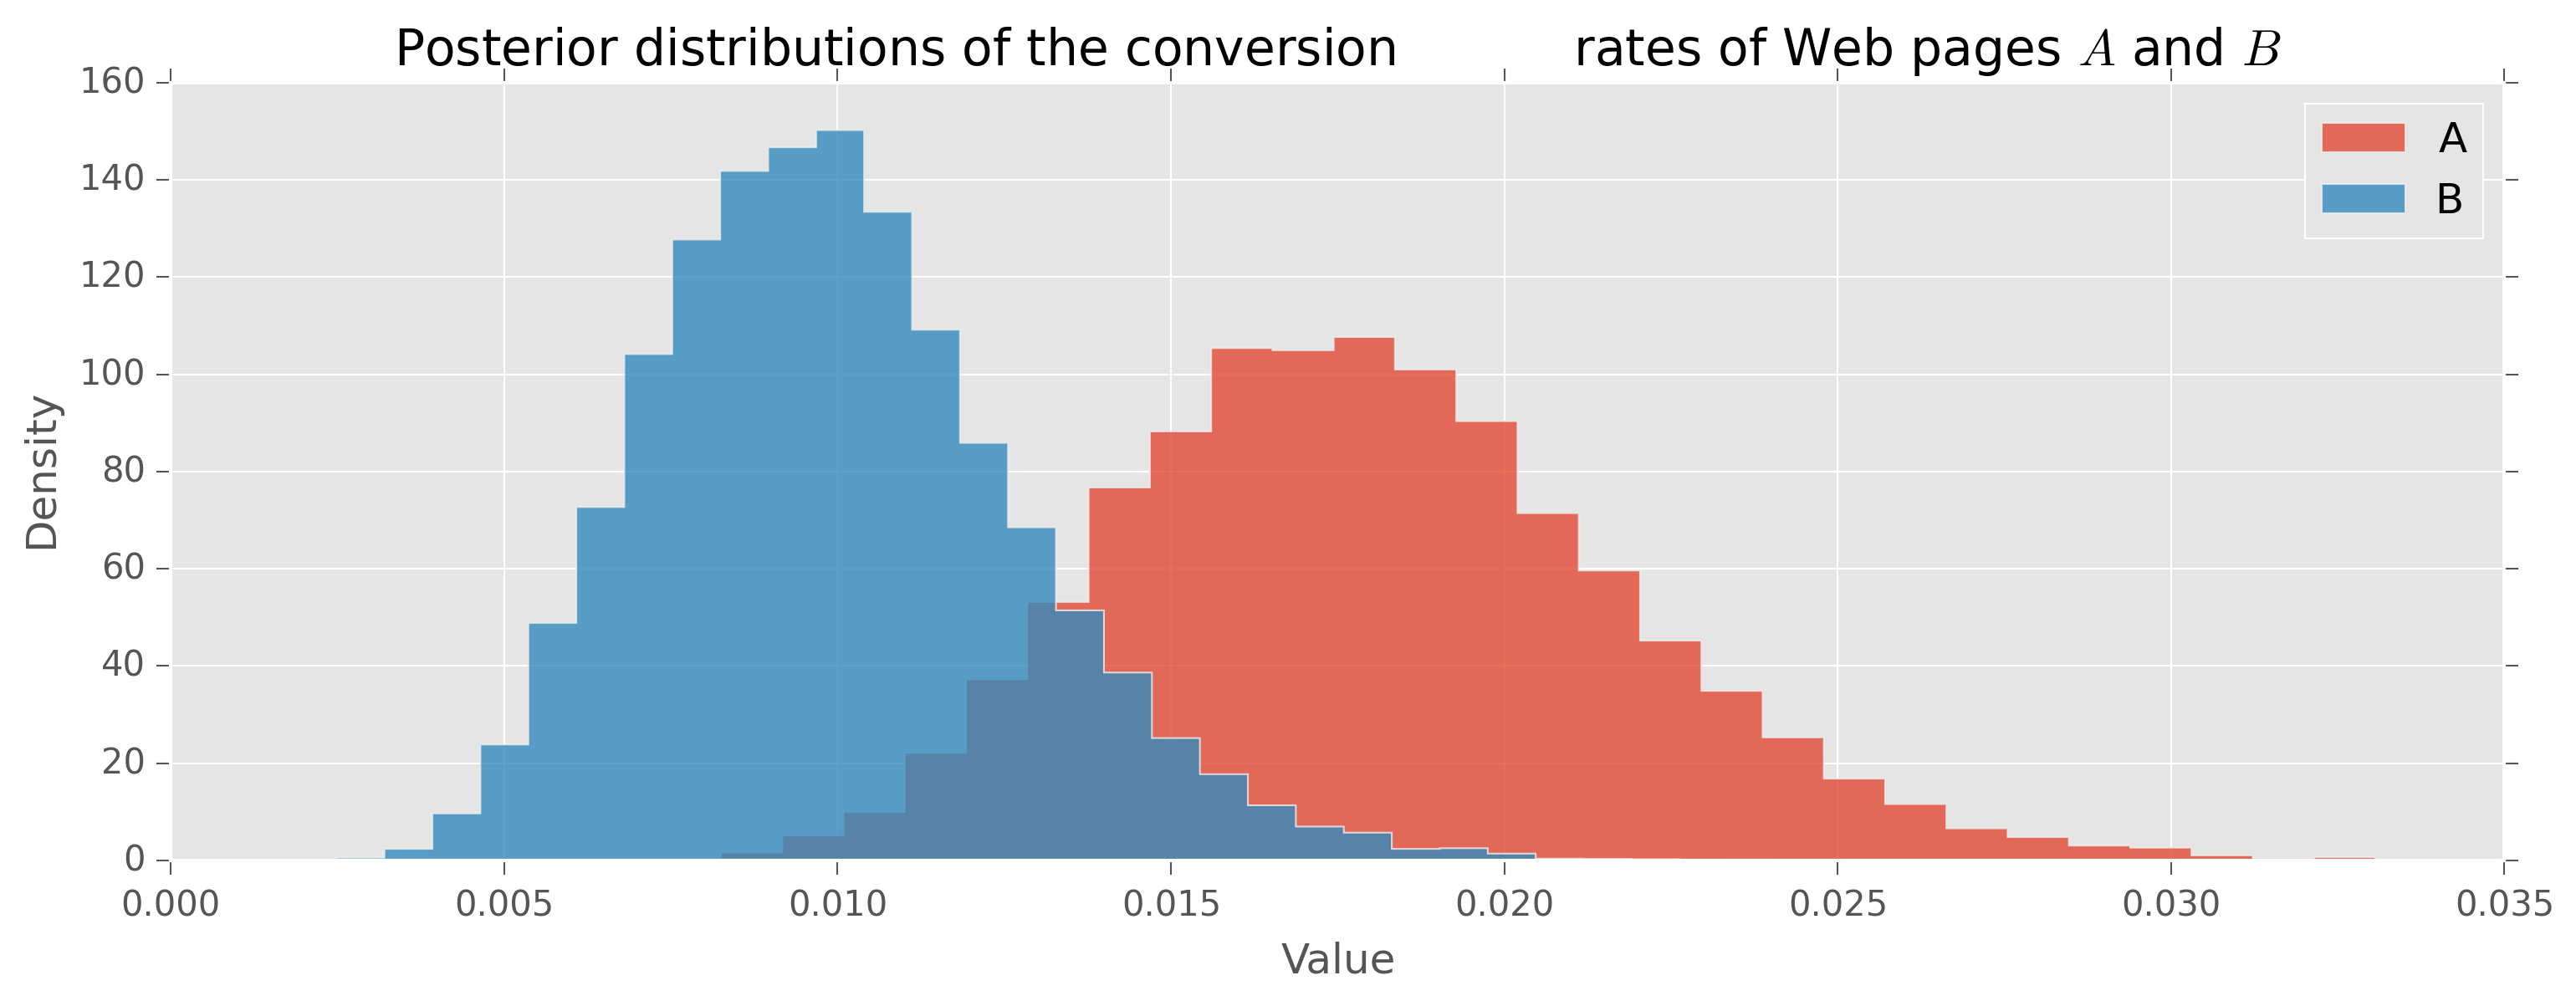

In [118]:
figsize(12,4)

visitors_to_A = 1275
visitors_to_B = 1300

conversions_from_A = 22
conversions_from_B = 12

alpha_prior = 1
beta_prior = 1

posterior_A = beta(alpha_prior + conversions_from_A,
                    beta_prior + visitors_to_A - conversions_from_A)

posterior_B = beta(alpha_prior + conversions_from_B,
                    beta_prior + visitors_to_B - conversions_from_B)


samples = 20000
samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)

#plt.hist(p_B_samples, histtype='stepfilled', bins=30, alpha=0.80,
#         label="posterior of $p_B$", color="#467821", normed=True)


plt.hist(samples_posterior_A,histtype='stepfilled', bins=30, alpha=0.80,
         label = 'A', normed=True)

plt.hist(samples_posterior_B,histtype='stepfilled', bins=30, alpha=0.80,
         label = 'B', normed=True)
#plt.hist(samples_posterior_B, 'B')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the conversion\
           rates of Web pages $A$ and $B$")
plt.legend();

We'll pass the posteriors through a function that computes the relative increase pairwise. The resulting posterior is shown below.

(array([  1.81564721e-02,   1.45453515e-01,   3.93995445e-01,
          6.17925267e-01,   6.66140788e-01,   5.99567057e-01,
          4.77313478e-01,   3.57480762e-01,   2.45717589e-01,
          1.72889962e-01,   1.15192729e-01,   7.82745687e-02,
          4.82155204e-02,   3.18746955e-02,   2.23929823e-02,
          1.49286548e-02,   9.07823605e-03,   9.48171321e-03,
          3.22781726e-03,   2.42086295e-03,   3.22781726e-03,
          4.03477158e-04,   0.00000000e+00,   4.03477158e-04,
          0.00000000e+00,   8.06954316e-04,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.01738579e-04]),
 array([-0.48319406, -0.23534856,  0.01249695,  0.26034245,  0.50818796,
         0.75603346,  1.00387897,  1.25172447,  1.49956998,  1.74741548,
         1.99526099,  2.24310649,  2.490952  ,  2.7387975 ,  2.98664301,
         3.23448851,  3.48233402,  3.73017952,  3.97802503,  4.22587053,
         4.47371604,  4.72156154,  4.96940705,  5.21725255,  5.46509806,
         5.71

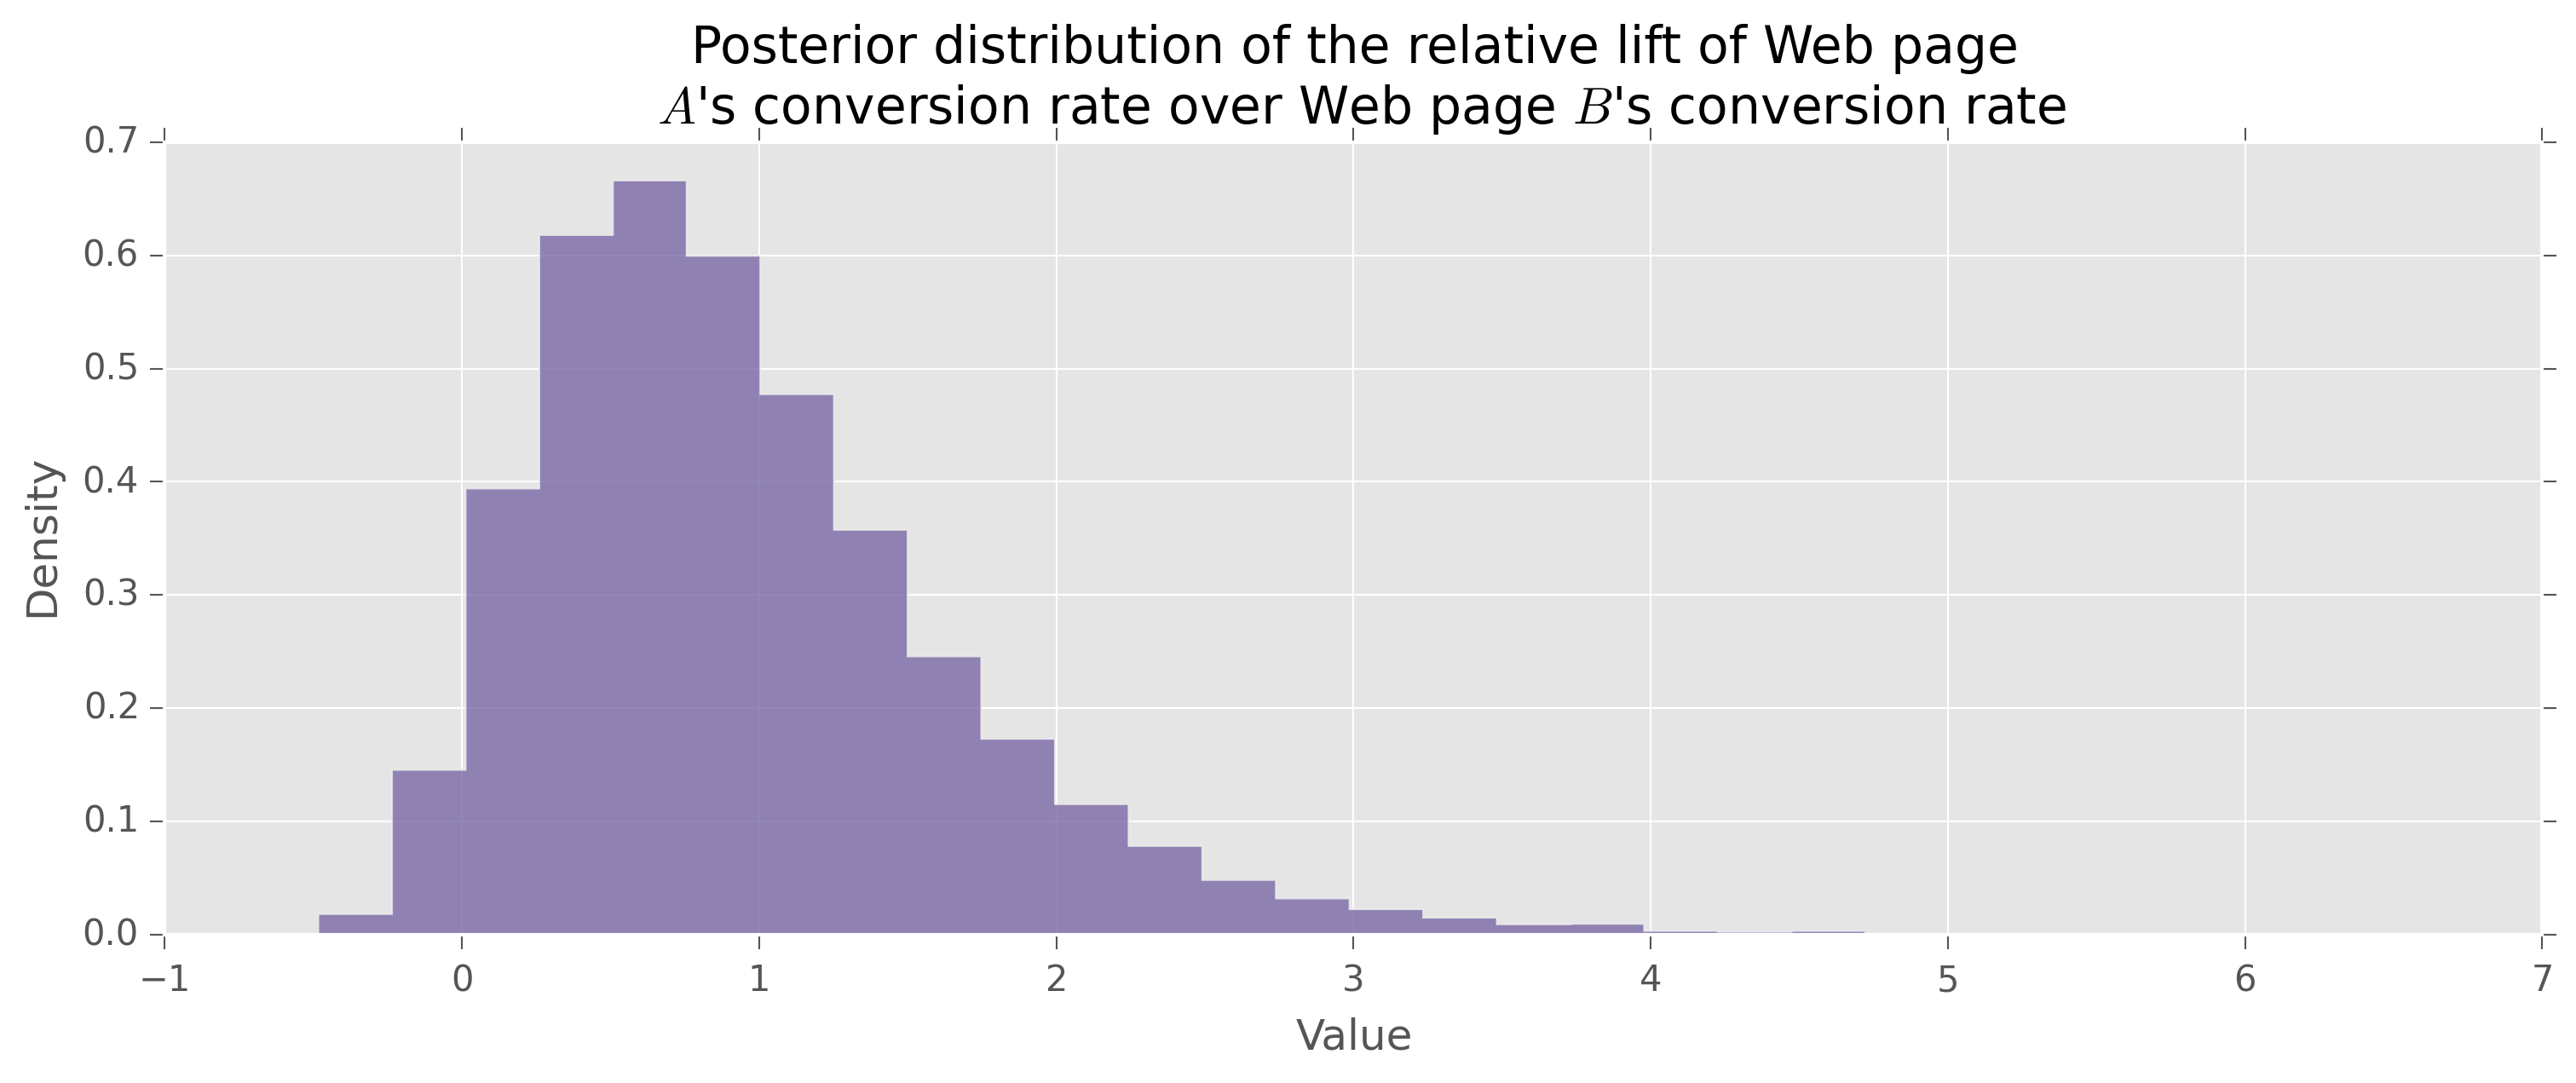

In [123]:
def relative_increase(a,b):
    return (a-b)/b

posterior_rel_increase = relative_increase(samples_posterior_A,
     samples_posterior_B)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distribution of the relative lift of Web page \n $A$'s conversion rate over Web page $B$'s conversion rate")

plt.hist(posterior_rel_increase,histtype='stepfilled', bins=30, alpha=0.80,
         label = 'relative increase',color='#7A68A6', normed=True)

From the next calculation, we can see that there is an 89% chance that the relative increase is 20% or more. Furthermore, there is a 72% chance that the increase is as great as 50%.

In [124]:
print (posterior_rel_increase > 0.2).mean()
print (posterior_rel_increase > 0.5).mean()

0.89125
0.71385


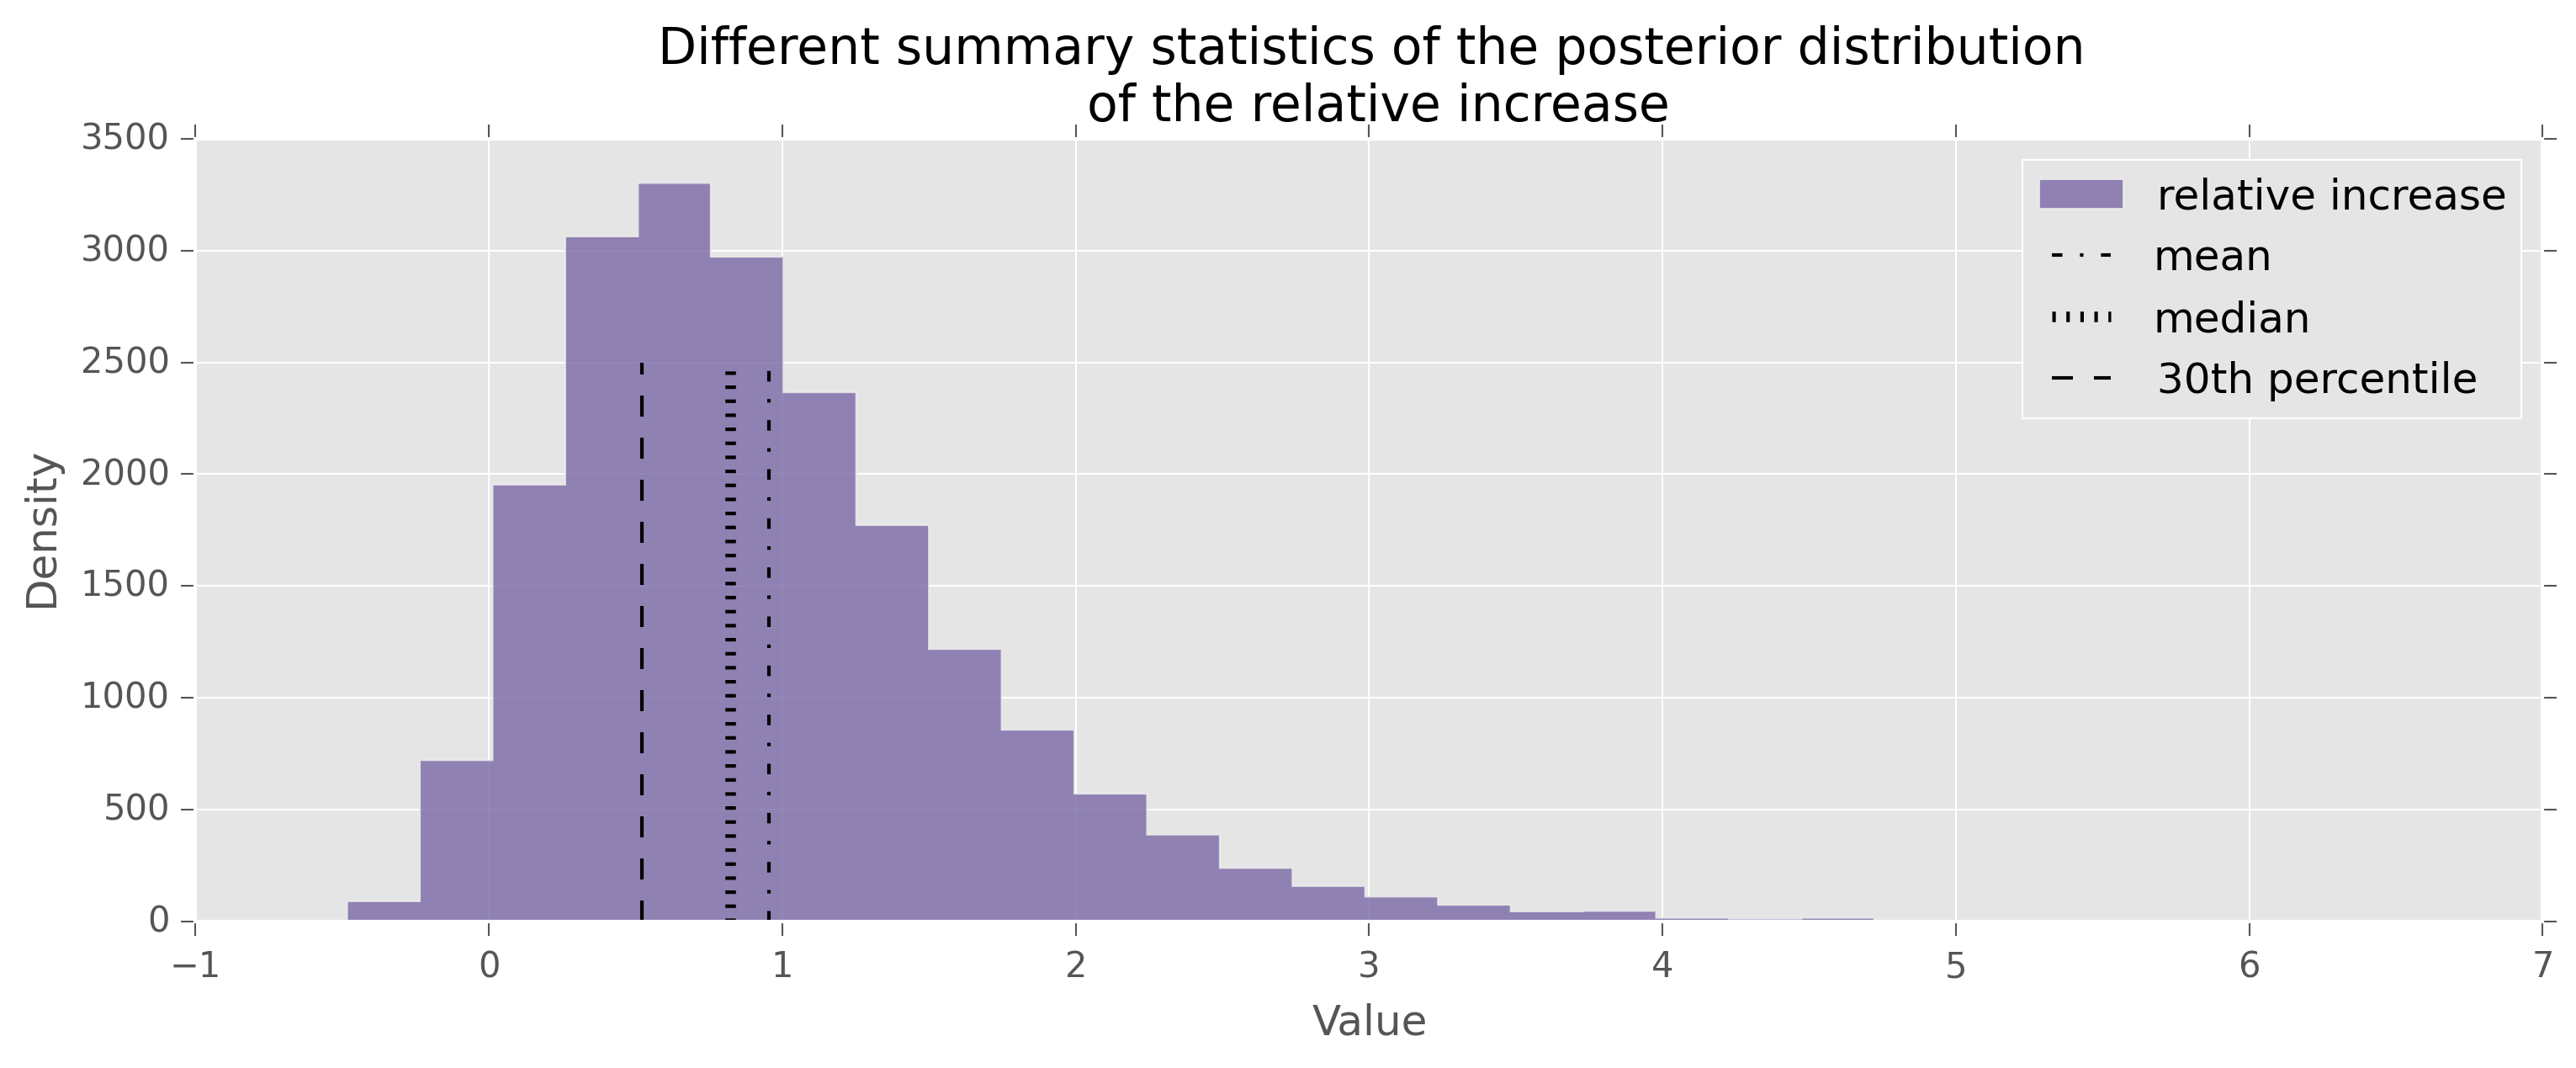

In [128]:
mean = posterior_rel_increase.mean()
median = np.percentile(posterior_rel_increase, 50)
conservative_percentile = np.percentile(posterior_rel_increase, 30)

plt.hist(posterior_rel_increase,histtype='stepfilled', bins=30, alpha=0.80,
         label = 'relative increase',color='#7A68A6', normed=False)


plt.vlines(mean, 0, 2500, linestyles='-.', label='mean')
plt.vlines(median, 0, 2500, linestyles=':', label='median', lw=3)
plt.vlines(conservative_percentile, 0, 2500, linestyles='--',
           label='30th percentile')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Different summary statistics of the posterior distribution \n of the relative increase")

plt.legend();

## now do the realative increase analysis with the baseball and driving examples:

In [129]:
utah_pop = 2812137
utah_crash = 237

colorado_pop = 5114827
colorado_crash = 490

from scipy.stats import beta
alpha_prior = 1
beta_prior = 1

posterior_utah = beta(alpha_prior + utah_crash,
                    beta_prior + utah_pop - utah_crash)

posterior_colorado = beta(alpha_prior + colorado_crash,
                    beta_prior + colorado_pop - colorado_crash)


samples = 20000 # We want this to be large to get a better approximation. 
samples_posterior_utah = posterior_utah.rvs(samples)
samples_posterior_colorado = posterior_colorado.rvs(samples)

print (samples_posterior_colorado > samples_posterior_utah).mean()



0.9471


(0, 0.0002)

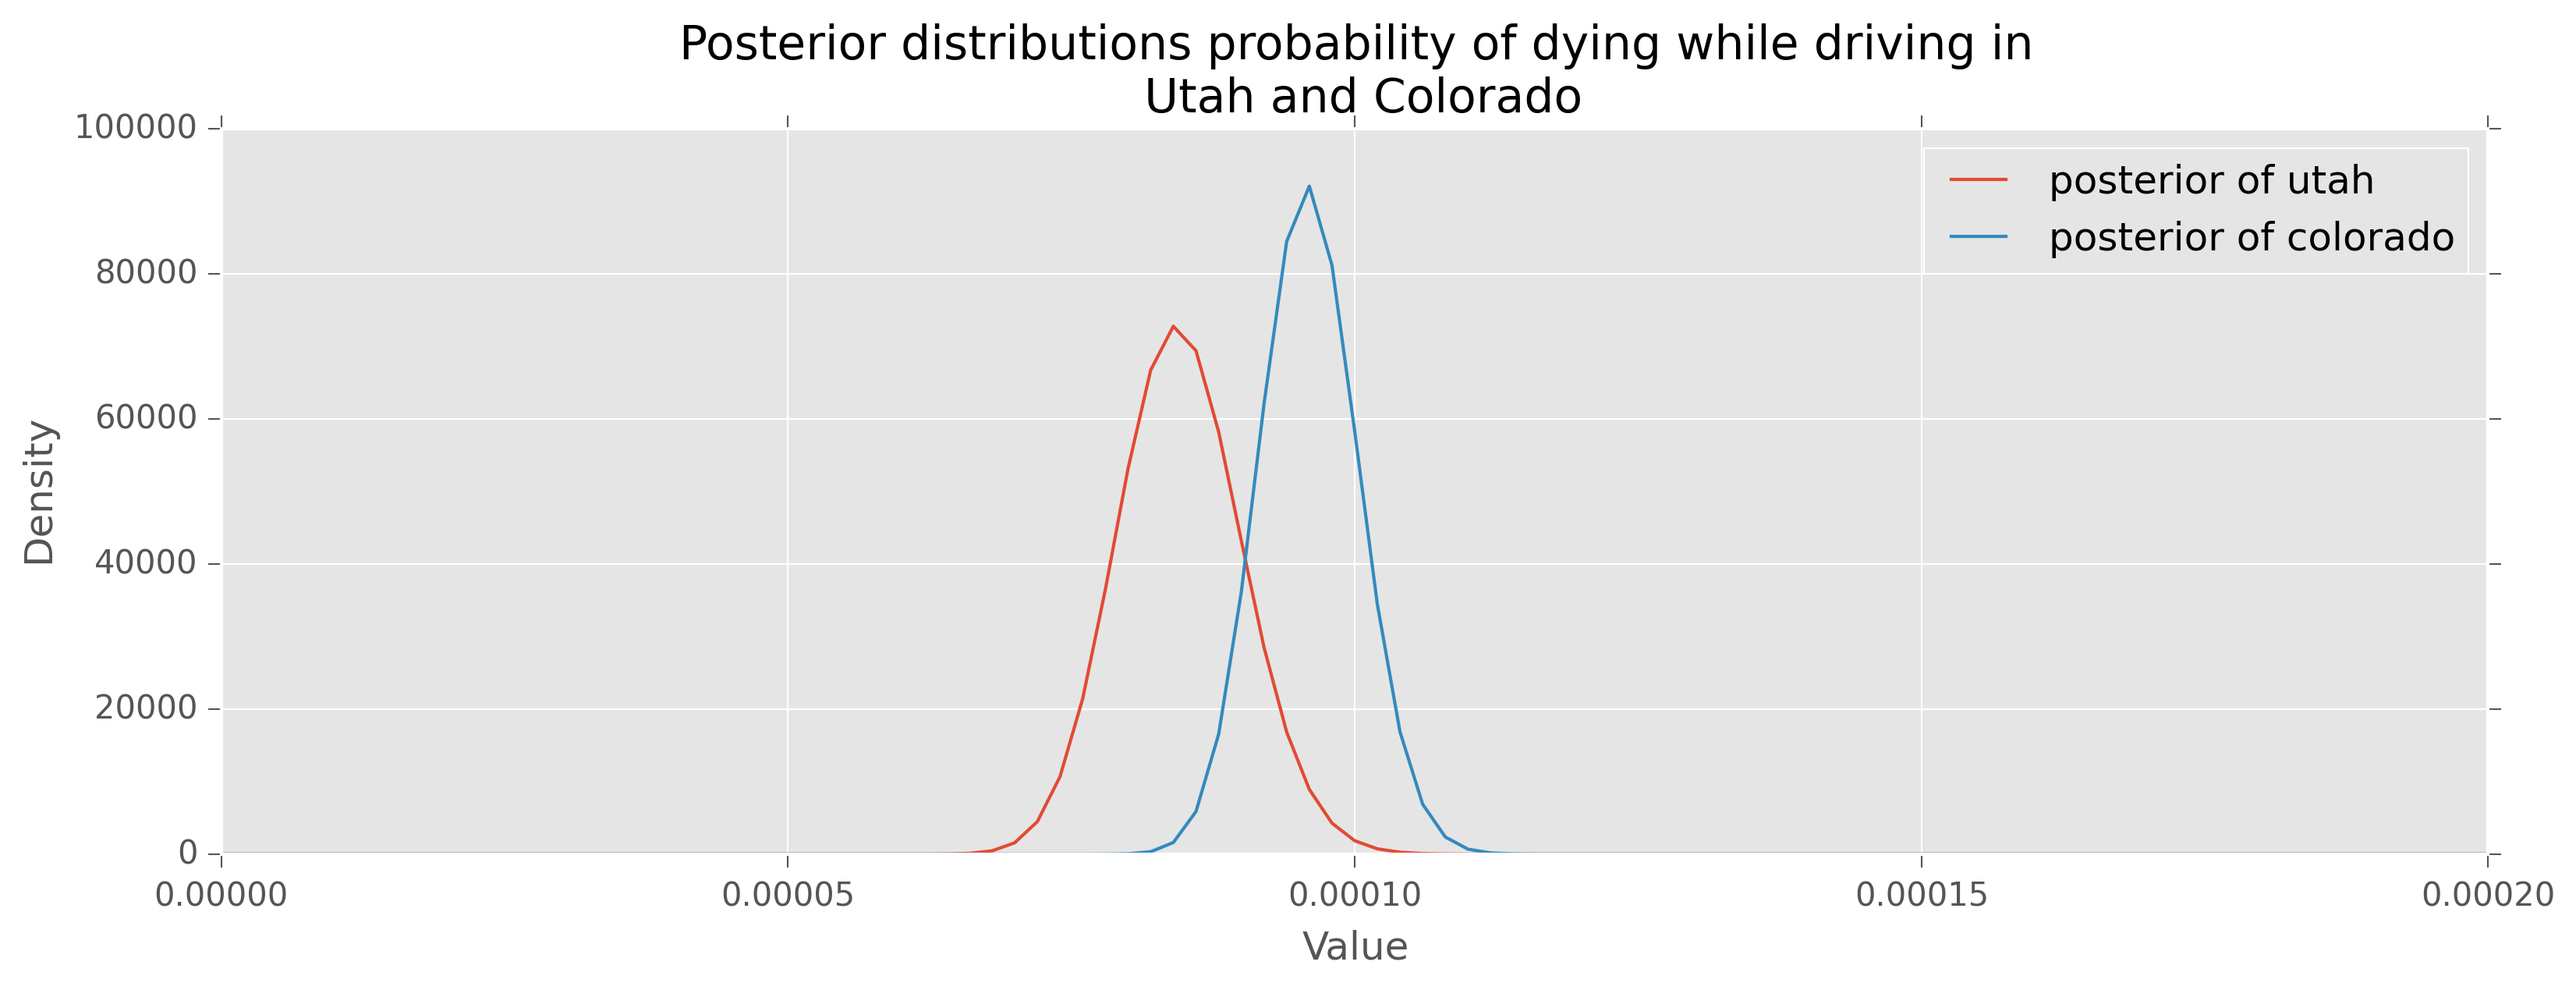

In [130]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
x = np.linspace(0,1, 500000)
plt.plot(x, posterior_utah.pdf(x), label='posterior of utah')
plt.plot(x, posterior_colorado.pdf(x), label='posterior of colorado')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions probability of dying while driving in \n Utah and Colorado")
plt.legend()
plt.xlim(0,.0002)

(array([  2.09221610e-03,   4.18443220e-03,   3.13832415e-02,
          6.90431312e-02,   1.38086262e-01,   3.26385711e-01,
          7.49013363e-01,   1.28043625e+00,   1.96249870e+00,
          2.57342580e+00,   3.50236975e+00,   4.00868604e+00,
          4.39365381e+00,   4.36436278e+00,   4.17397112e+00,
          3.55467515e+00,   3.03580556e+00,   2.38094192e+00,
          1.87671784e+00,   1.26788296e+00,   8.59900816e-01,
          5.50252834e-01,   3.07555766e-01,   1.86207233e-01,
          1.15071885e-01,   6.06742669e-02,   3.76598898e-02,
          1.25532966e-02,   1.46455127e-02,   4.18443220e-03]),
 array([-0.18543189, -0.16153378, -0.13763568, -0.11373757, -0.08983947,
        -0.06594136, -0.04204326, -0.01814515,  0.00575295,  0.02965106,
         0.05354916,  0.07744727,  0.10134537,  0.12524348,  0.14914158,
         0.17303969,  0.19693779,  0.2208359 ,  0.244734  ,  0.26863211,
         0.29253021,  0.31642832,  0.34032642,  0.36422453,  0.38812263,
         0.41

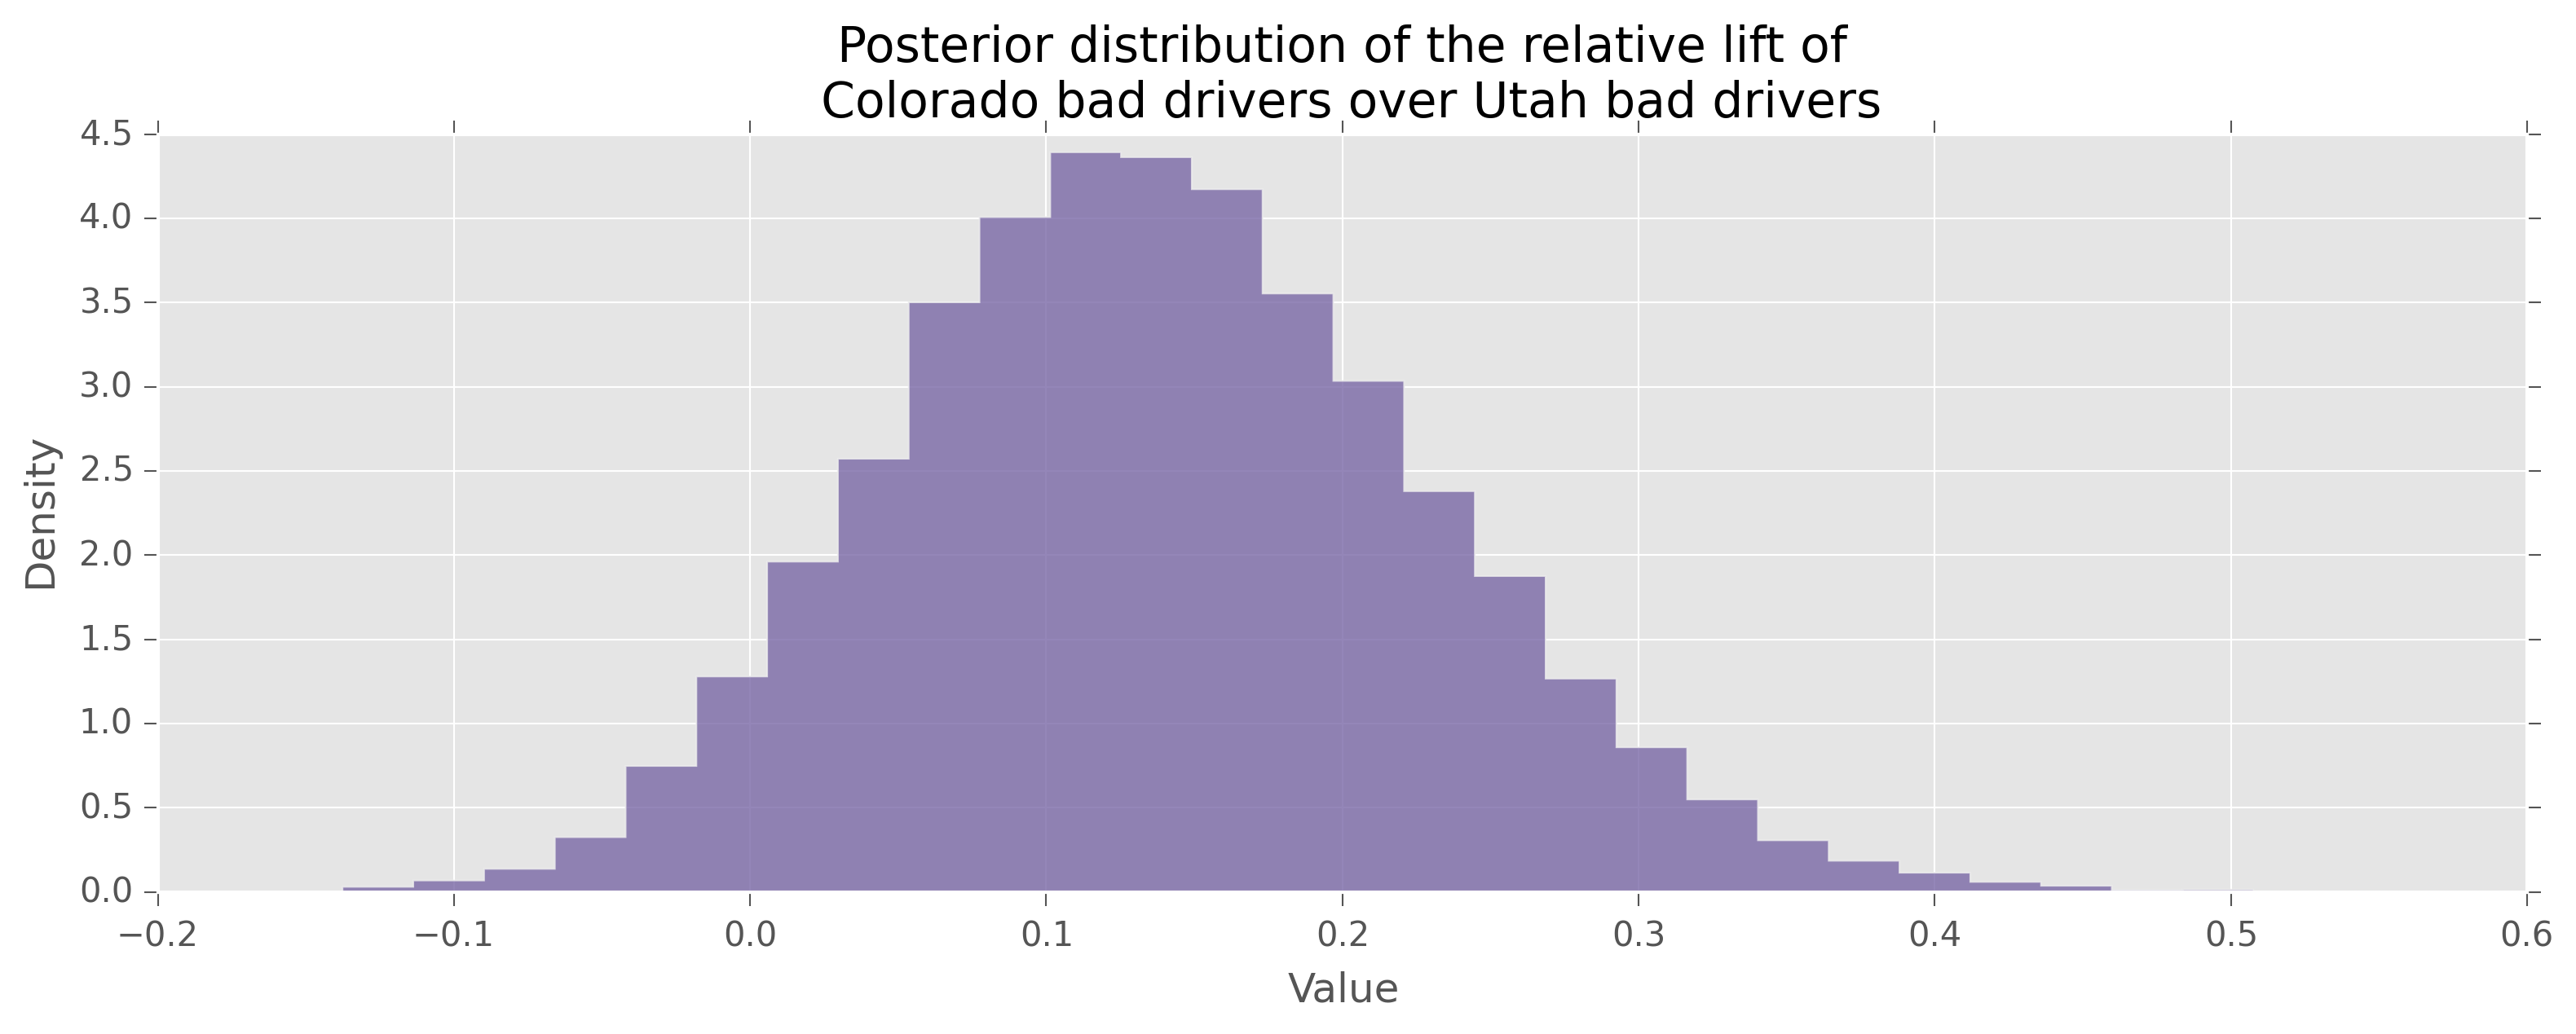

In [131]:
def relative_increase(a,b):
    return (a-b)/b

posterior_rel_increase = relative_increase(samples_posterior_colorado,
     samples_posterior_utah)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distribution of the relative lift of \n Colorado bad drivers over Utah bad drivers")

plt.hist(posterior_rel_increase,histtype='stepfilled', bins=30, alpha=0.80,
         label = 'relative increase',color='#7A68A6', normed=True)

In [132]:
print (posterior_rel_increase > 0.2).mean()
print (posterior_rel_increase > 0.5).mean()

0.2459
0.0002


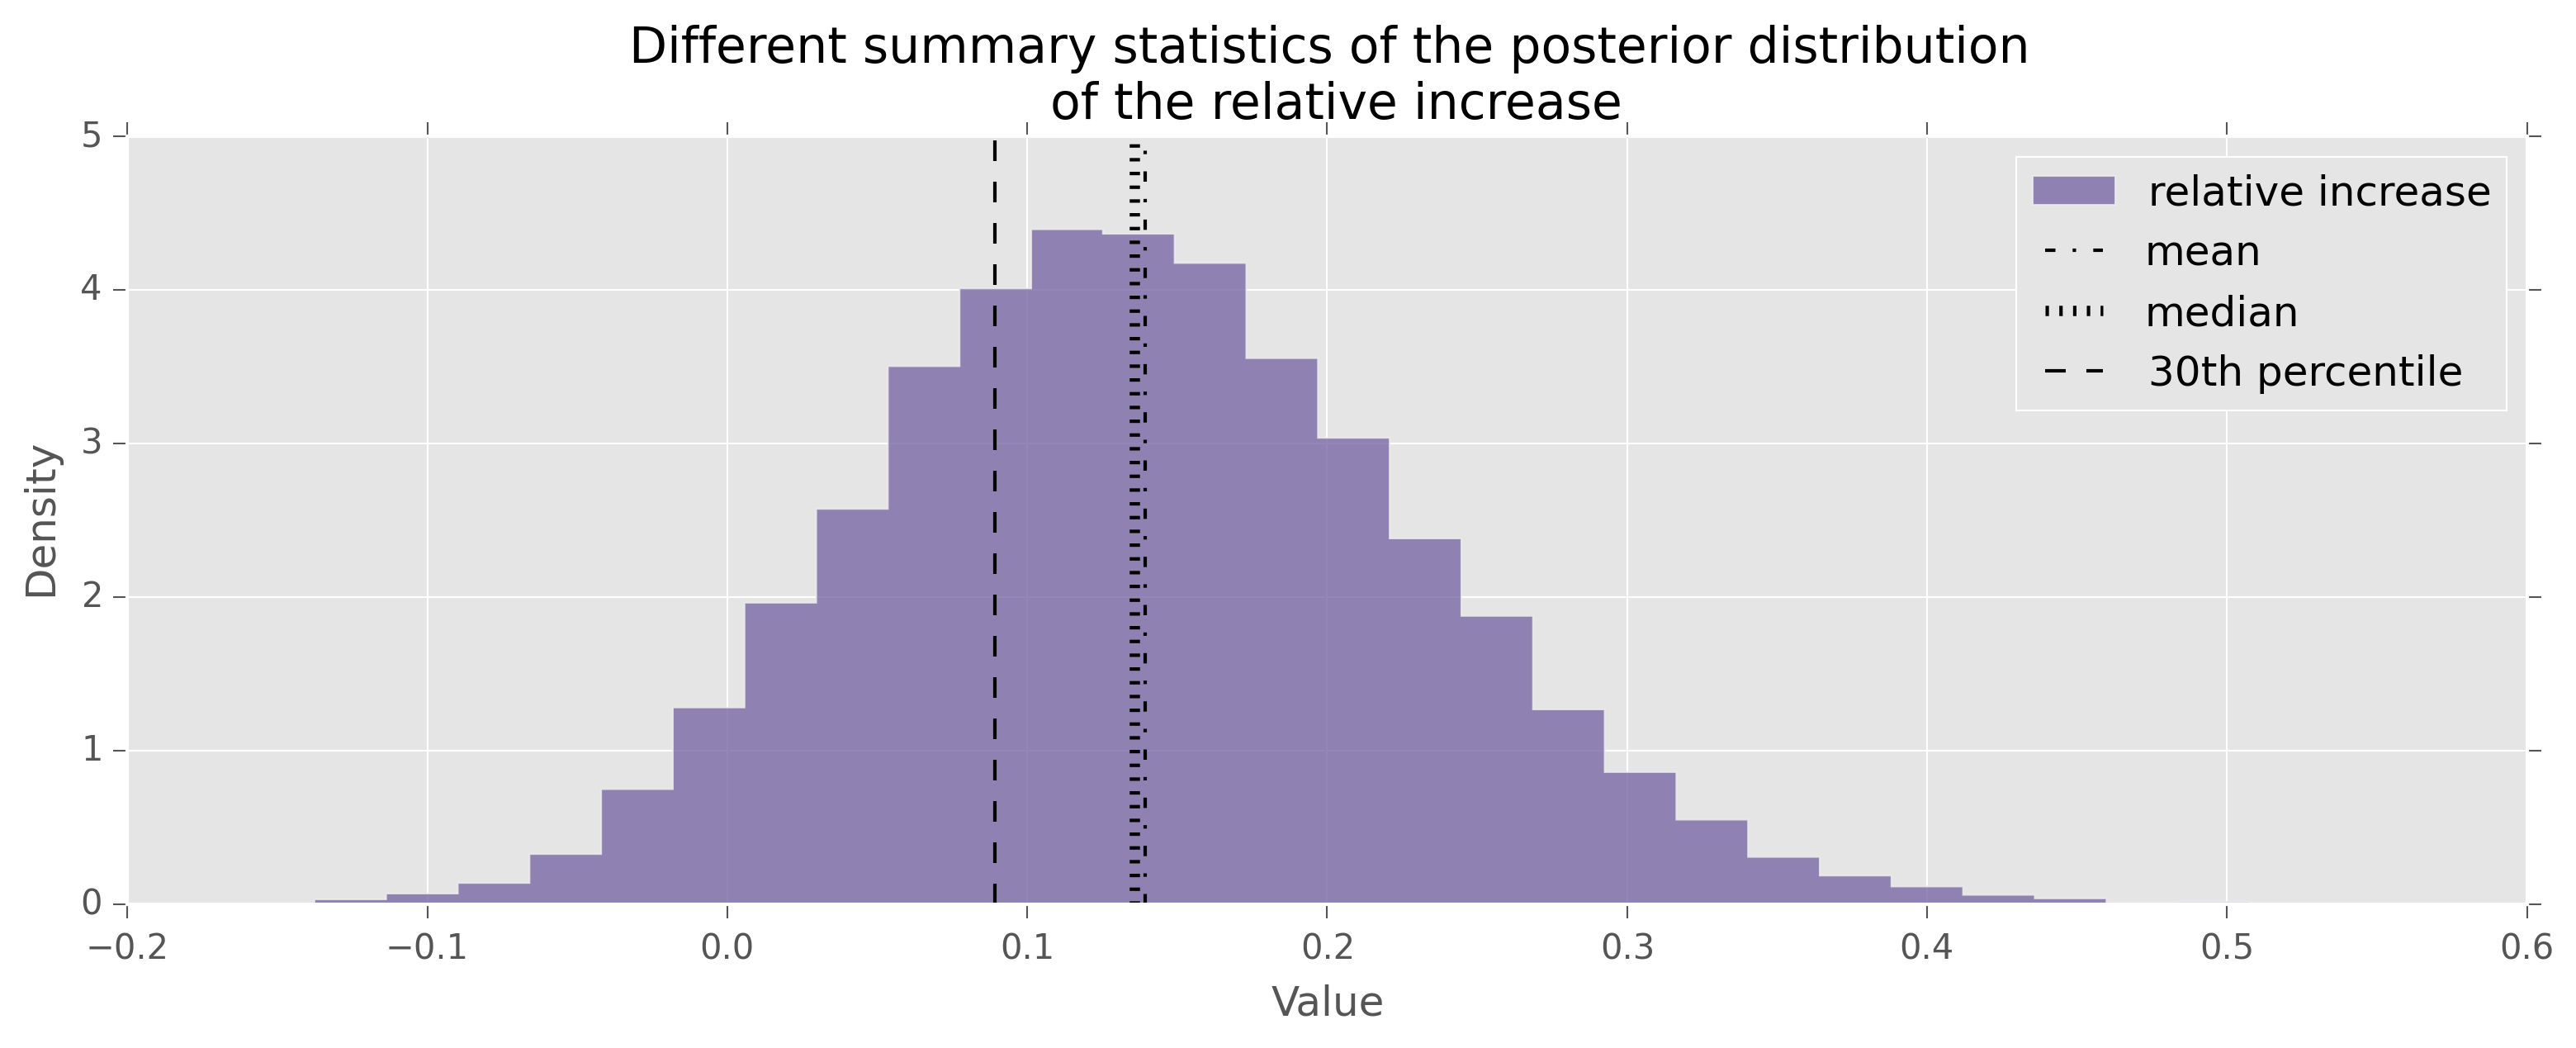

In [134]:
mean = posterior_rel_increase.mean()
median = np.percentile(posterior_rel_increase, 50)
conservative_percentile = np.percentile(posterior_rel_increase, 30)

plt.hist(posterior_rel_increase,histtype='stepfilled', bins=30, alpha=0.80,
         label = 'relative increase',color='#7A68A6', normed=True)


plt.vlines(mean, 0, 5, linestyles='-.', label='mean')
plt.vlines(median, 0, 5, linestyles=':', label='median', lw=3)
plt.vlines(conservative_percentile, 0, 5, linestyles='--',
           label='30th percentile')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Different summary statistics of the posterior distribution \n of the relative increase")

plt.legend();

So Colorado drivers are definitely WORSE, but only 15% worse.

## American League vs National League Home Runs

In [141]:
AL_PA = 91837
NL_PA = 91790

AL_HR = 2634
NL_HR = 2275

from scipy.stats import beta
alpha_prior = 1
beta_prior = 1

posterior_AL = beta(alpha_prior + AL_HR, beta_prior + AL_PA - AL_HR)

posterior_NL = beta(alpha_prior + NL_HR, beta_prior + NL_PA - NL_HR)


samples = 2000000

samples_posterior_AL = posterior_AL.rvs(samples)

samples_posterior_NL = posterior_NL.rvs(samples)

print (samples_posterior_AL > samples_posterior_NL).mean()

1.0


(0.02, 0.04)

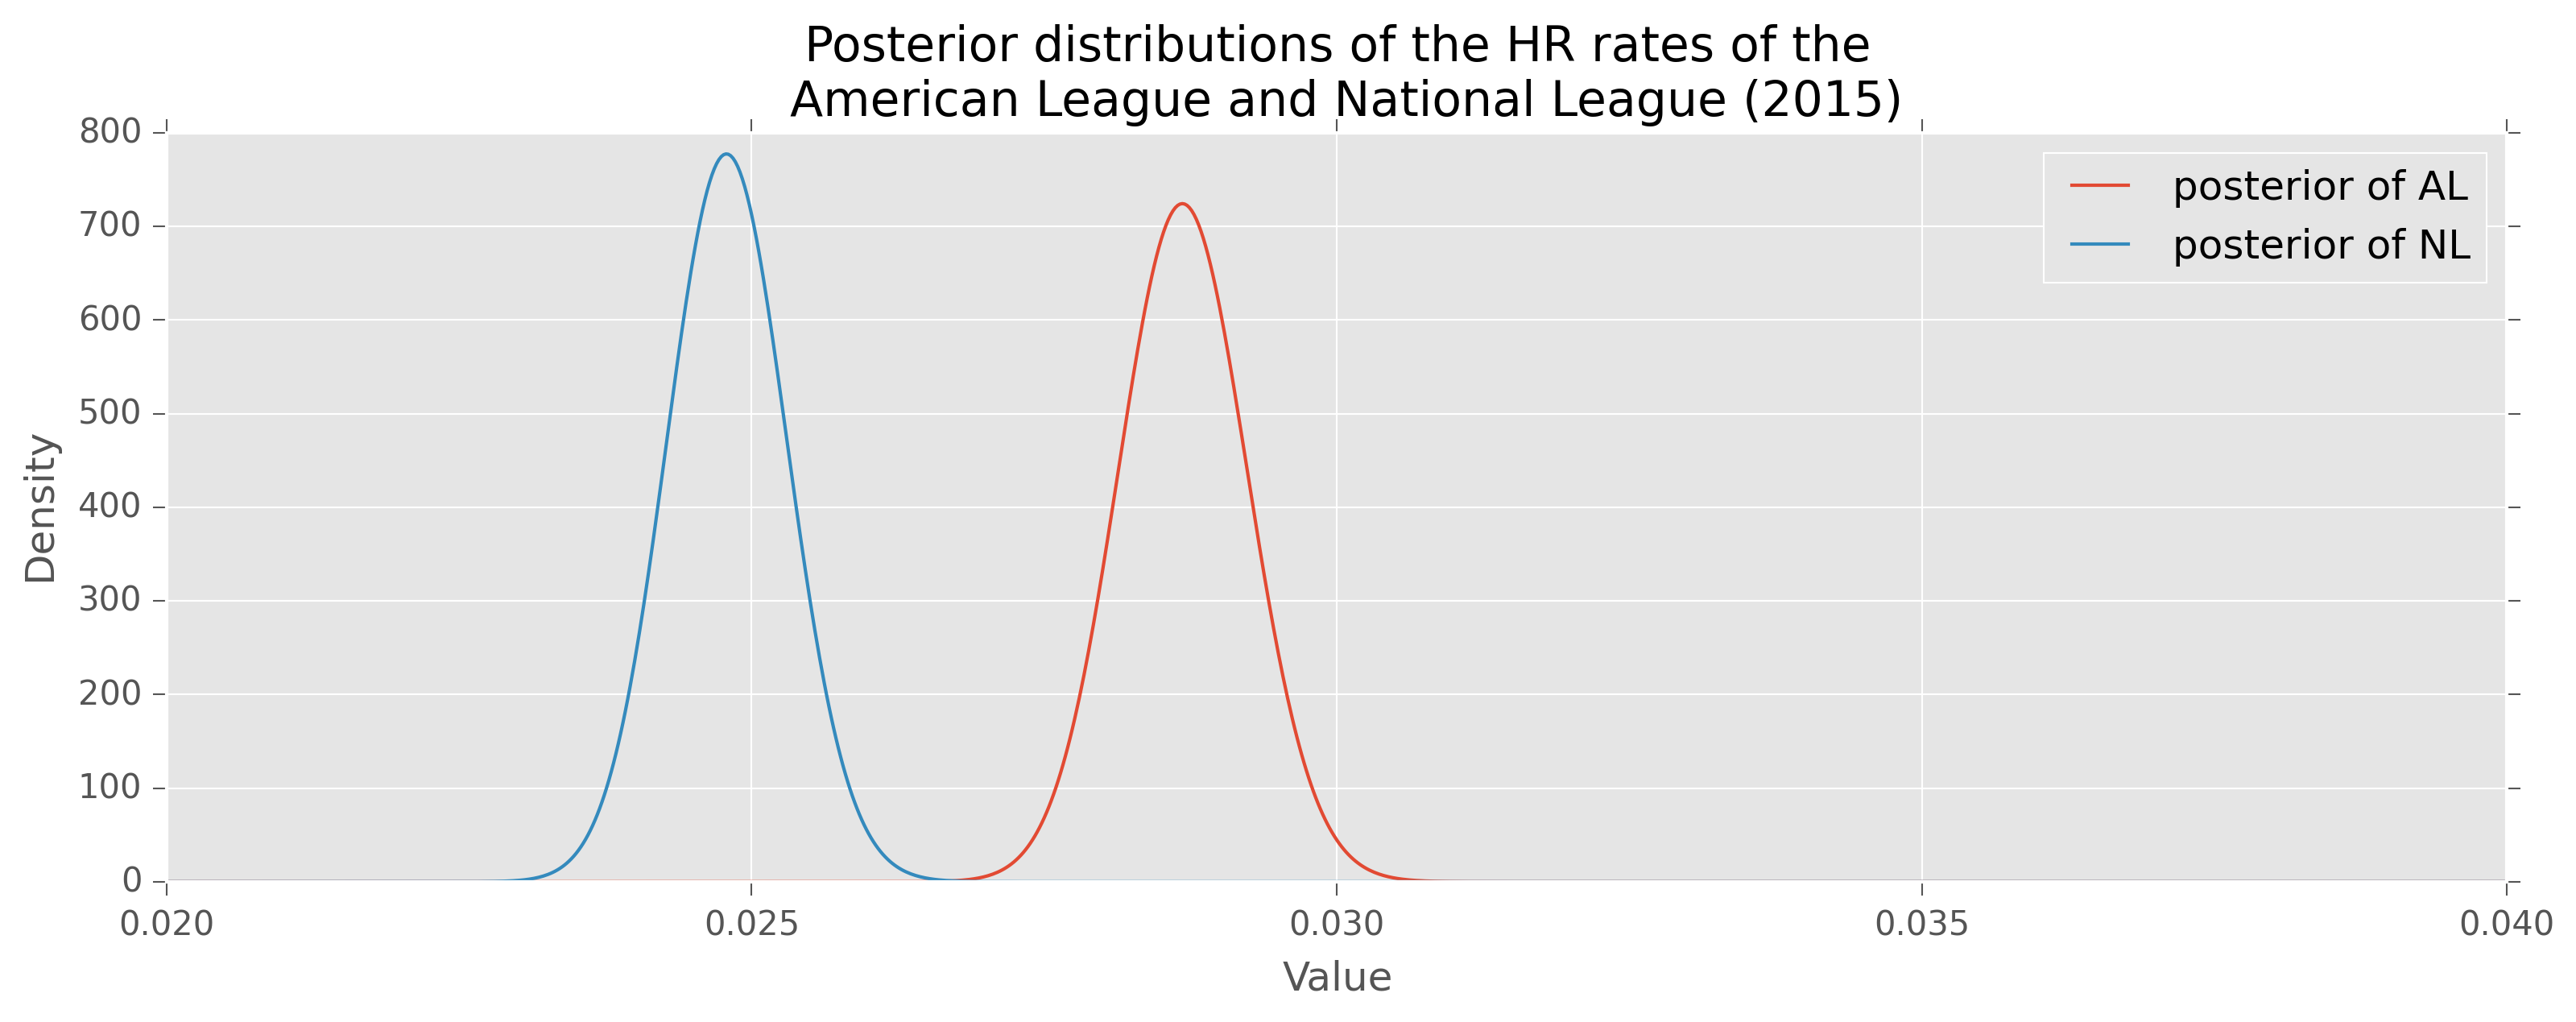

In [142]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300
x = np.linspace(0,1, 50000)
plt.plot(x, posterior_AL.pdf(x), label='posterior of AL')
plt.plot(x, posterior_NL.pdf(x), label='posterior of NL')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the HR rates of the \n American League and National League (2015)")
plt.legend()
plt.xlim(0.02,0.04)

(array([  3.69042212e-04,   6.45823872e-04,   2.12199272e-03,
          2.95233770e-03,   6.36597816e-03,   1.28242169e-02,
          2.39877438e-02,   4.75141848e-02,   8.81088282e-02,
          1.52137652e-01,   2.54731387e-01,   3.91646048e-01,
          6.43794139e-01,   9.55911590e-01,   1.41564593e+00,
          1.99965523e+00,   2.75296264e+00,   3.65785415e+00,
          4.73554967e+00,   5.94573134e+00,   7.13257110e+00,
          8.40512091e+00,   9.59740403e+00,   1.06792513e+01,
          1.14406776e+01,   1.19880595e+01,   1.21567118e+01,
          1.20076187e+01,   1.16508472e+01,   1.08997540e+01,
          1.00020588e+01,   8.88589065e+00,   7.74305918e+00,
          6.53739827e+00,   5.35932327e+00,   4.34279649e+00,
          3.39435801e+00,   2.63597626e+00,   1.97003959e+00,
          1.43289865e+00,   1.04162164e+00,   7.20647180e-01,
          5.06418176e-01,   3.28263048e-01,   2.13583180e-01,
          1.37837266e-01,   8.61713566e-02,   5.42492052e-02,
        

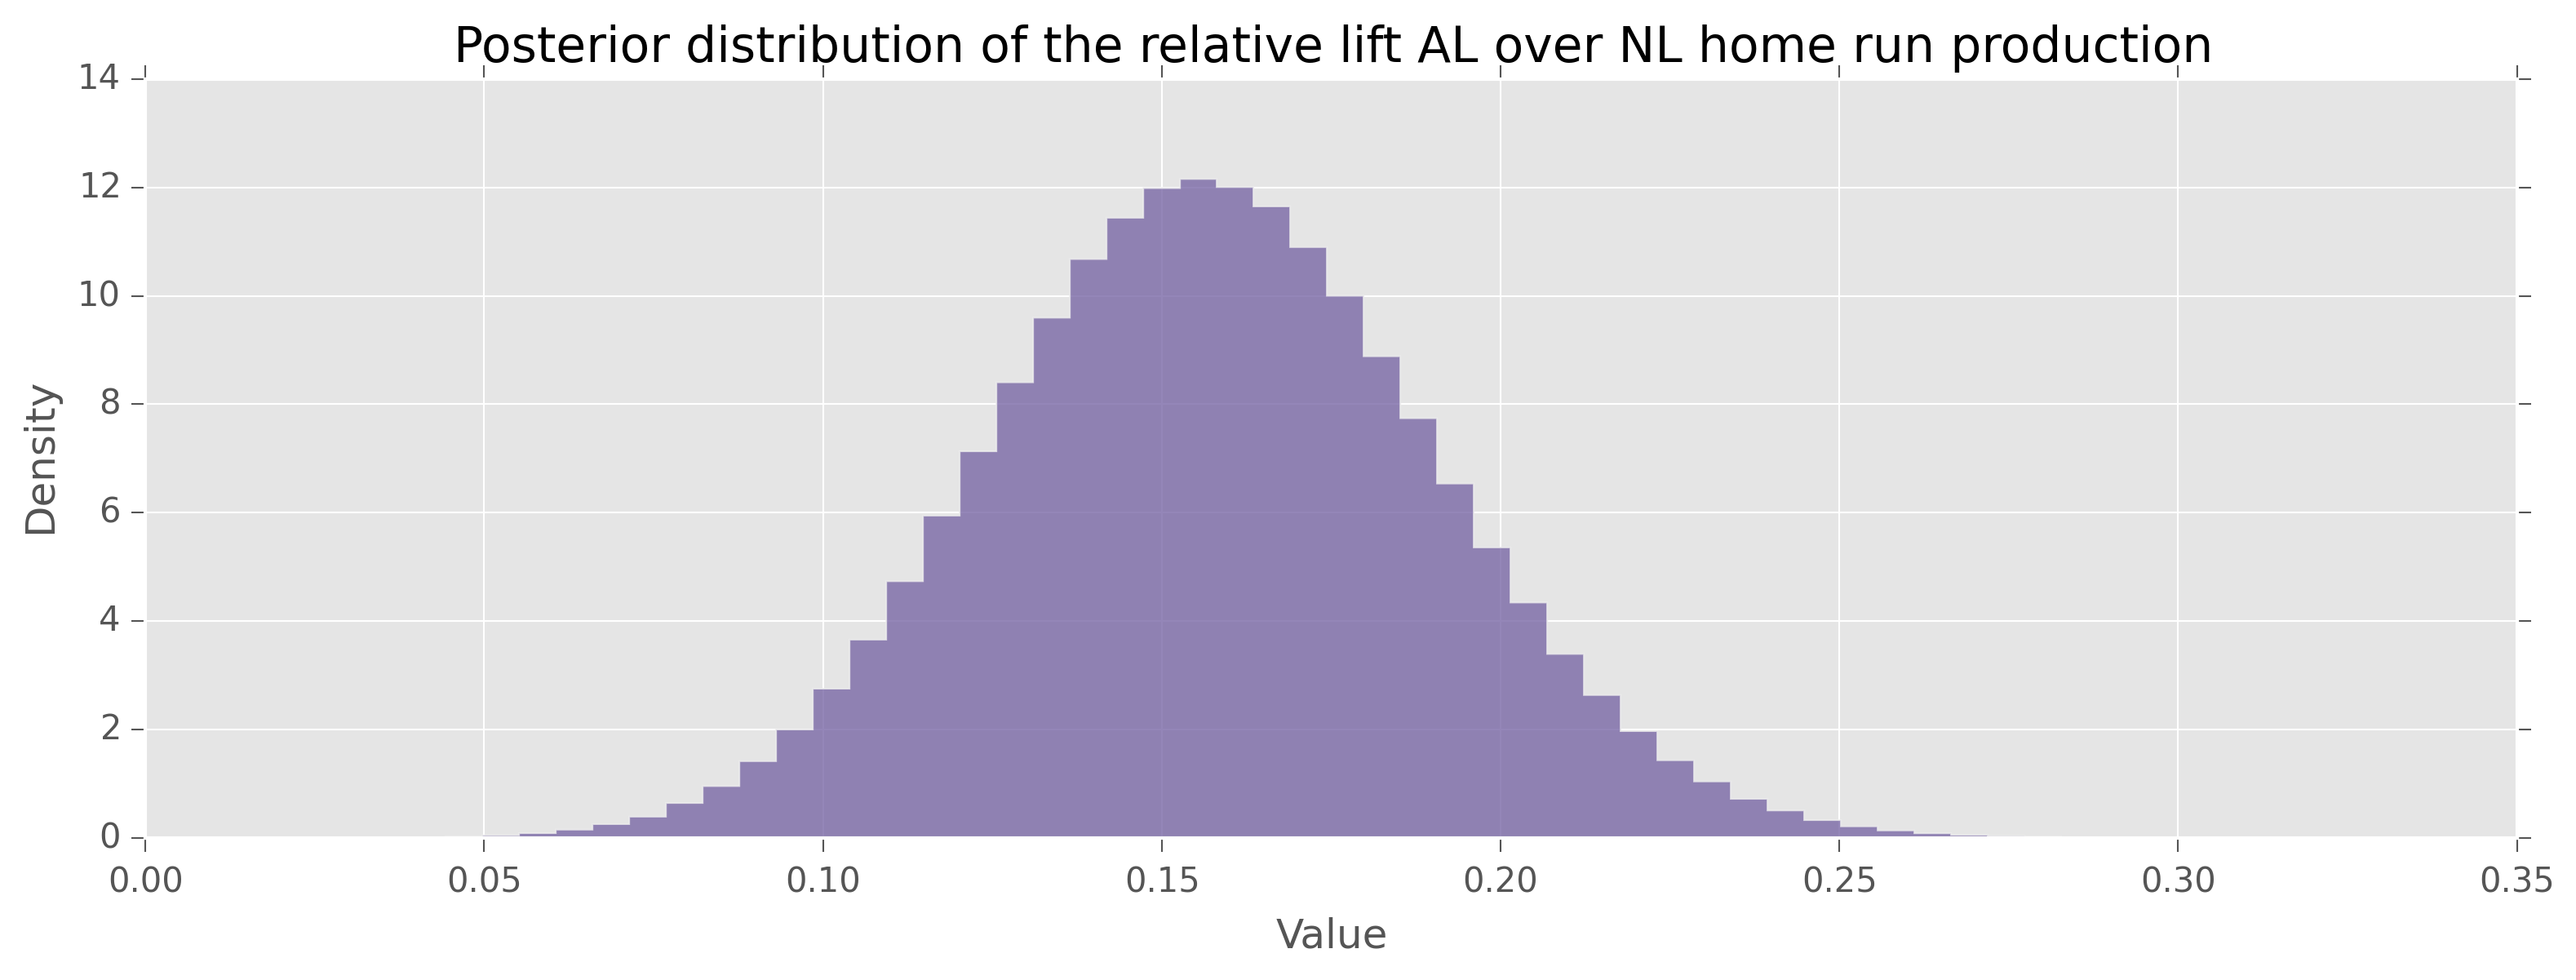

In [144]:
def relative_increase(a,b):
    return (a-b)/b

posterior_rel_increase = relative_increase(samples_posterior_AL,
     samples_posterior_NL)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distribution of the relative lift AL over NL home run production")

plt.hist(posterior_rel_increase,histtype='stepfilled', bins=60, alpha=0.80,
         label = 'relative increase',color='#7A68A6', normed=True)

In [145]:
print (posterior_rel_increase > 0.2).mean()
print (posterior_rel_increase > 0.5).mean()

0.099127
0.0


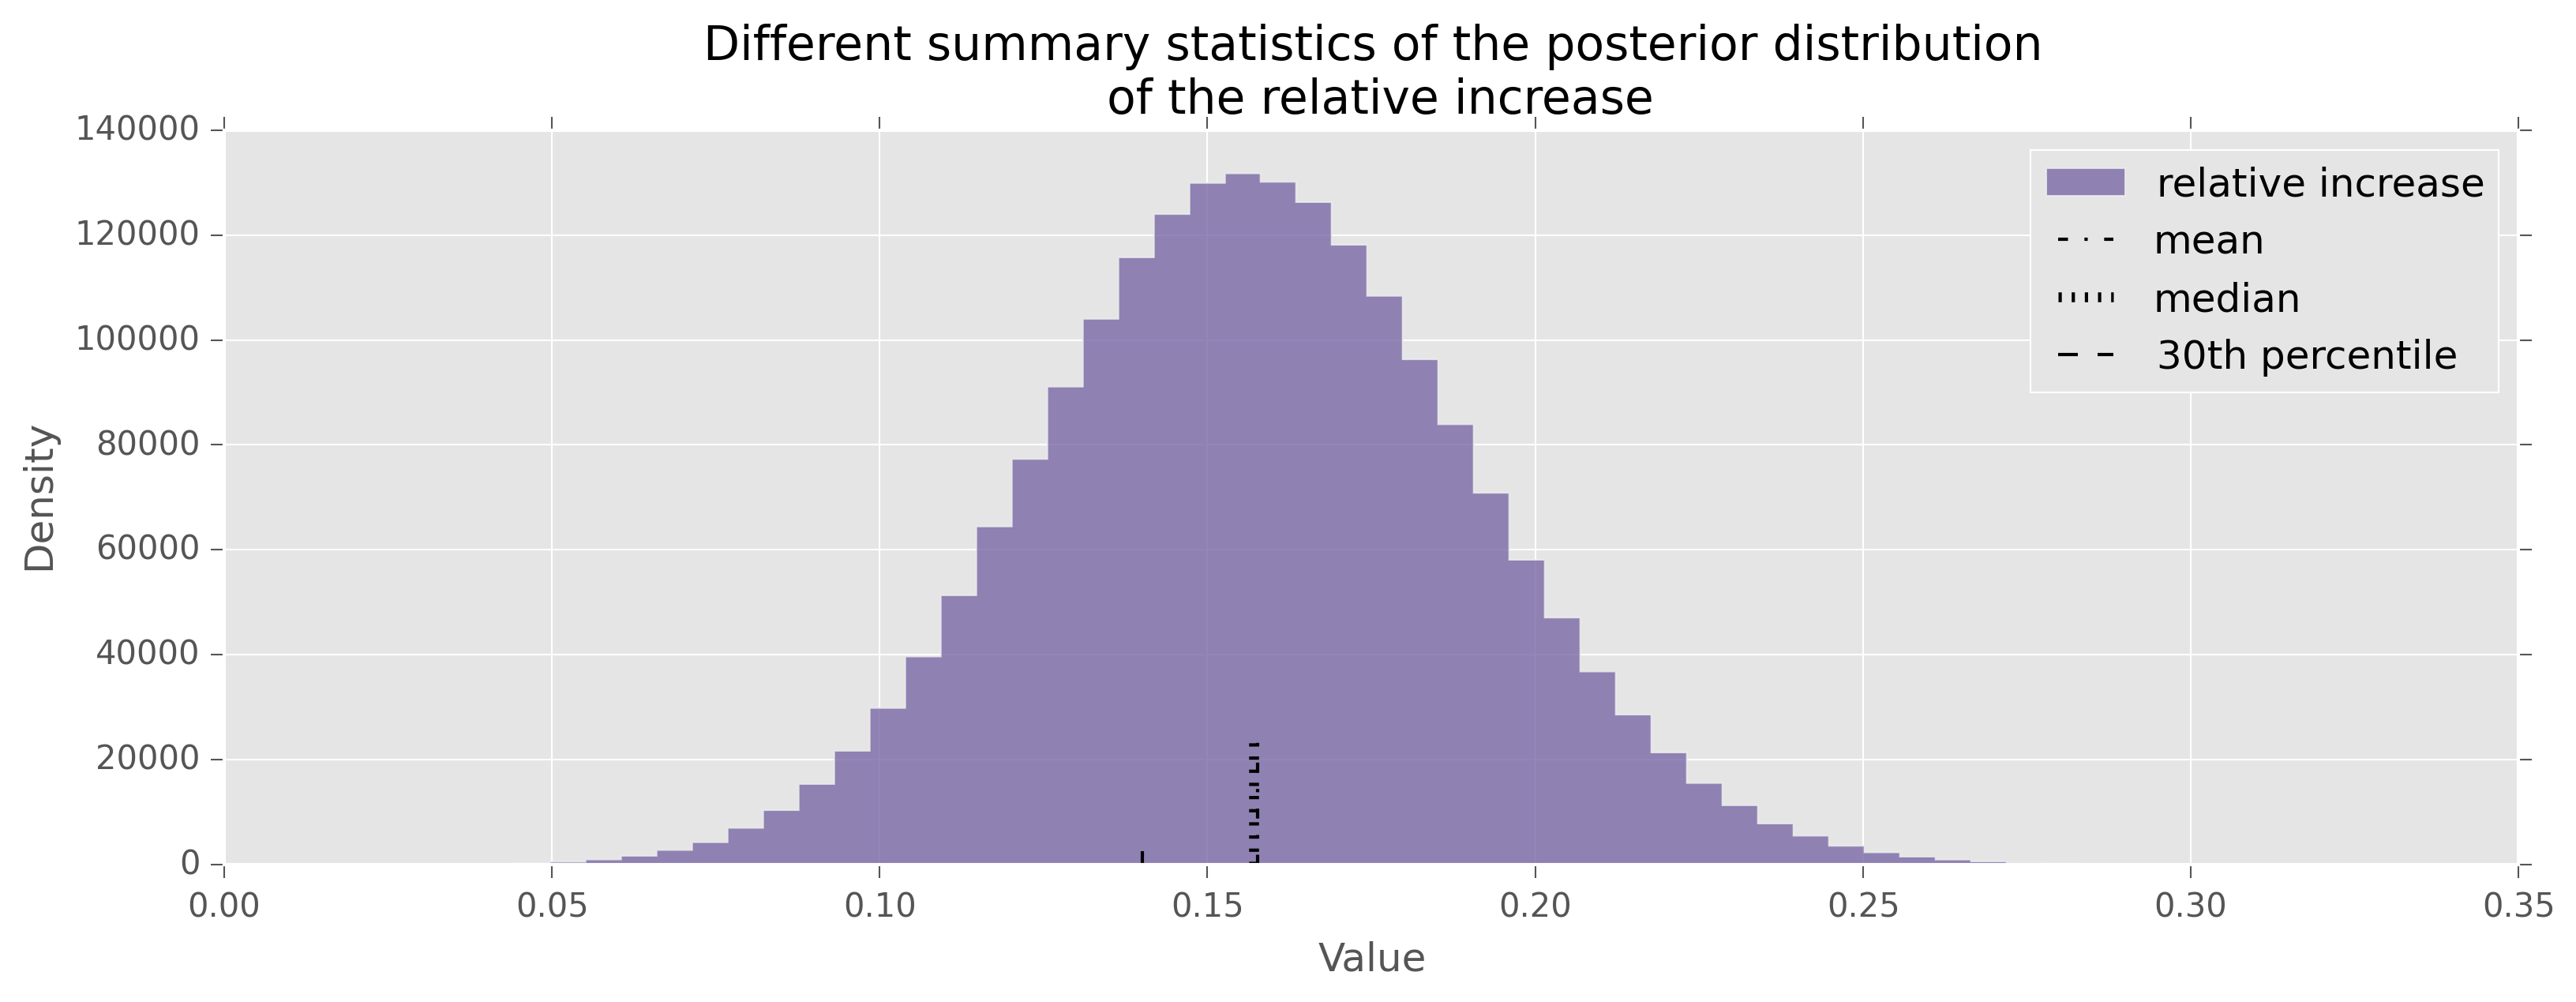

In [146]:
mean = posterior_rel_increase.mean()
median = np.percentile(posterior_rel_increase, 50)
conservative_percentile = np.percentile(posterior_rel_increase, 30)

plt.hist(posterior_rel_increase,histtype='stepfilled', bins=60, alpha=0.80,
         label = 'relative increase',color='#7A68A6', normed=False)


plt.vlines(mean, 0, 25000, linestyles='-.', label='mean')
plt.vlines(median, 0, 25000, linestyles=':', label='median', lw=3)
plt.vlines(conservative_percentile, 0, 2500, linestyles='--',
           label='30th percentile')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Different summary statistics of the posterior distribution \n of the relative increase")

plt.legend();

So the relative increase is about 16%; again the AL is **definitely** better than the NL at hitting home runs (becuase of the pitchers), but the relative amount of **better** is only $\sim 15\%$

## Combining tests for one answer to which treatment is better? Multinomial and Dirichlet




In [152]:
samples_posterior_AL

array([ 0.08503015,  0.09066414,  0.09123013, ...,  0.08472869,
        0.07492494,  0.09649142])

Not appliable to our case; the adverse advents of interest are not mutually exclusive (the probabilites do not need to add up to one for each group; it makes more sense to just use a Beta/Binomial model for each probability).

### 7.3 Adding a Linear Loss Function

A common goal of Internet companies is not only to gain signups, but also to optimize which signup plan the user might select. 
For example, a business might want new customers to choose a higher-priced plan if presented with two or more plan options.
Suppose users are shown two different versions of this pricing page, and we'd like to determine the _expected revenue_ we receive per impression. Our prevous A/B test was only concerned with whether the user signed up or not; now, we want to know what the expected revenue to be earned is.

### 7.3.1 Expected Revenue Analysis

For the moment, ignore the A/B test and consider the analysis for a single Web page style. In a completely transparent world, where we knew everything, we could calculate this expected value for this fictional company:

$
E[R] = 79 p_{79} + 49 p_{49} + 25 p_{25} + 0 p_{0}
$

where $p_{79}$ is the probability of selecting the \$79 pricing plan, and so on. I've also included a fictional \$0 pricing plan for someone who _doesn't_ pick a plan. This is added so that the probabilities sum to 1.:

$
p_{79} + p_{49} + p_{25} + p_{0} = 1
$

The next step is to estimate these probabilities. We can't use a Beta/binomial model for each probability, as the probabilities are correlated; they must sum to 1. For example, if $p_79$ is high, then the other probabilities must be low. We need to model all the probabilities together.

There is a generalization of the binomial distribution called the multinomial distribution. It's available in both PyMC and NumPy, but I'll use the latter. In the following code, I set a probablity vector, denoted by ```P```, that specfies what the probability is than an individual would fall into that bucket. If we set the length of ```P``` to 2 (and make sure the values inside sum to 1), then we recover the familiar binomial distribution.


In [153]:
from numpy.random import multinomial
P = [0.5, 0.2, 0.3] 
N = 1
print multinomial(N,P)

[1 0 0]


In [154]:
N = 10
print multinomial(N,P)

[5 2 3]


In probability theory, the **multinomial distribution** is a generalization of the binomial distribution. For example it models the probability of counts for rolling a k sided die n times. For n independent trials each of which leads to a success for exactly one of k categories, with each category having a given fixed success probability, the **multinomial distribution** gives the probability of any particular combination of numbers of successes for the various categories.

When n is 1 and k is 2 the multinomial distribution is the Bernoulli distribution. When k is 2 and number of trials are more than 1 it is the Binomial distribution. When n is 1 it is the categorical distribution.

The Bernoulli distribution is the probability distribution of whether a Bernoulli trial is a success. In other words it models the number of heads from flipping a coin one time. The binomial distribution generalizes this to the number of heads from doing n independent flips of the same coin. For the multinomial distribution the analog to the Bernoulli Distribution is the categorical distribution. Instead of flipping one coin, the categorical distribution models the roll of one k sided die. So the multinomial distribution can model n independent rolls of a k sided die.

Let k be a fixed finite number. Mathematically, we have k possible mutually exclusive outcomes, with corresponding probabilities p1, ..., pk, and n independent trials. Note that since the k outcomes are mutually exclusive and one must occur we have pi ≥ 0 for i = 1, ..., k and $\sum_{i=1}^k p_i = 1$. Then if the random variables Xi indicate the number of times outcome number i is observed over the n trials, the vector X = (X1, ..., Xk) follows a multinomial distribution with parameters n and p, where p = (p1, ..., pk). While the trials are independent, their outcomes X are dependent because they must be summed to n.

Note that, in some fields, such as natural language processing, the categorical and multinomial distributions are conflated, and it is common to speak of a "multinomial distribution" when a categorical distribution is actually meant. This stems from the fact that it is sometimes convenient to express the outcome of a categorical distribution as a "1-of-K" vector (a vector with one element containing a 1 and all other elements containing a 0) rather than as an integer in the range 1 \dots K; in this form, a categorical distribution is equivalent to a multinomial distribution over a single trial.

For our signup page, our observables follow a multinomial distribution, where we do not know the values of the probability vector ```P```.

There is a generalization of the Beta distribution as well. It is called the _Dirichlet distribution_. It returns a vector of positive values that sum to 1. The length of this vector is determined by the length of an input vector, and this input vector's values are analogous to a parameter in a prior. 

In [155]:
from numpy.random import dirichlet
sample = dirichlet([1,1])  # [1,1] is equivalent to a Beta(1,1) distribution
print sample
print sample.sum()

[ 0.03146817  0.96853183]
1.0


In [156]:
sample = dirichlet([1,1,1,1])
print sample
print sample.sum()

[ 0.08618538  0.14191114  0.66571265  0.10619084]
1.0


In [157]:
sample = dirichlet([1,10,1,1])
print sample
print sample.sum()

[ 0.01811277  0.61779592  0.33326218  0.03082913]
1.0


Luckily, we have a relationship between the Dirichlet and multinomial distributions similar to that between the Beta and the binomial distributions. The Dirichlet distribution is a conjugate prior to the multinomial distribution! This means we have exact formulas for the posteriors of the unknown probabilities. If our prior is Dirichlet(1,1,...,1), and our 
observables are $N_1,N_2,\cdots,N_m$, then our posterior is

Dirichlet(1+$N_1$,1 + $N_2, \cdots, 1 + N_m$)

Samples from this posterior will always sum to 1, so we can use these samples in the expected value formula 
MAYBE WE CAN USE IT CAUSE OF DEATH IN THE SEER DATA FOR DIFFERENT A, B GROUPS!

Let's try this with some sample data. Suppose 1,000 people view the page, and we have the following signups:

In [160]:
N = 1000      # number of people who died
N_79 = 10     # number of people who died via process 1
N_49 = 46     #  number of people who died via process 2
N_25 = 80
N_0 = N - (N_79 + N_49 + N_25)    # number of people who did NOT die yet

# Maybe break out the SEER data into 2 groups; those that received some form of radiation and those that have not.
# then collect numbers anallgous to those above        ; ok

observations = np.array([N_79, N_49, N_25, N_0])

prior_parameters = np.array([1,1,1,1])     # analagous to uniform priors on the p's
posterior_samples = dirichlet(prior_parameters + observations, size=100000)

print "Two random samples from the posterior:"

print posterior_samples[0]
print posterior_samples[1]

Two random samples from the posterior:
[ 0.01158197  0.04215452  0.06418652  0.882077  ]
[ 0.01113566  0.03289635  0.08694781  0.86902018]


We can plot the probability density function of this posterior, too:

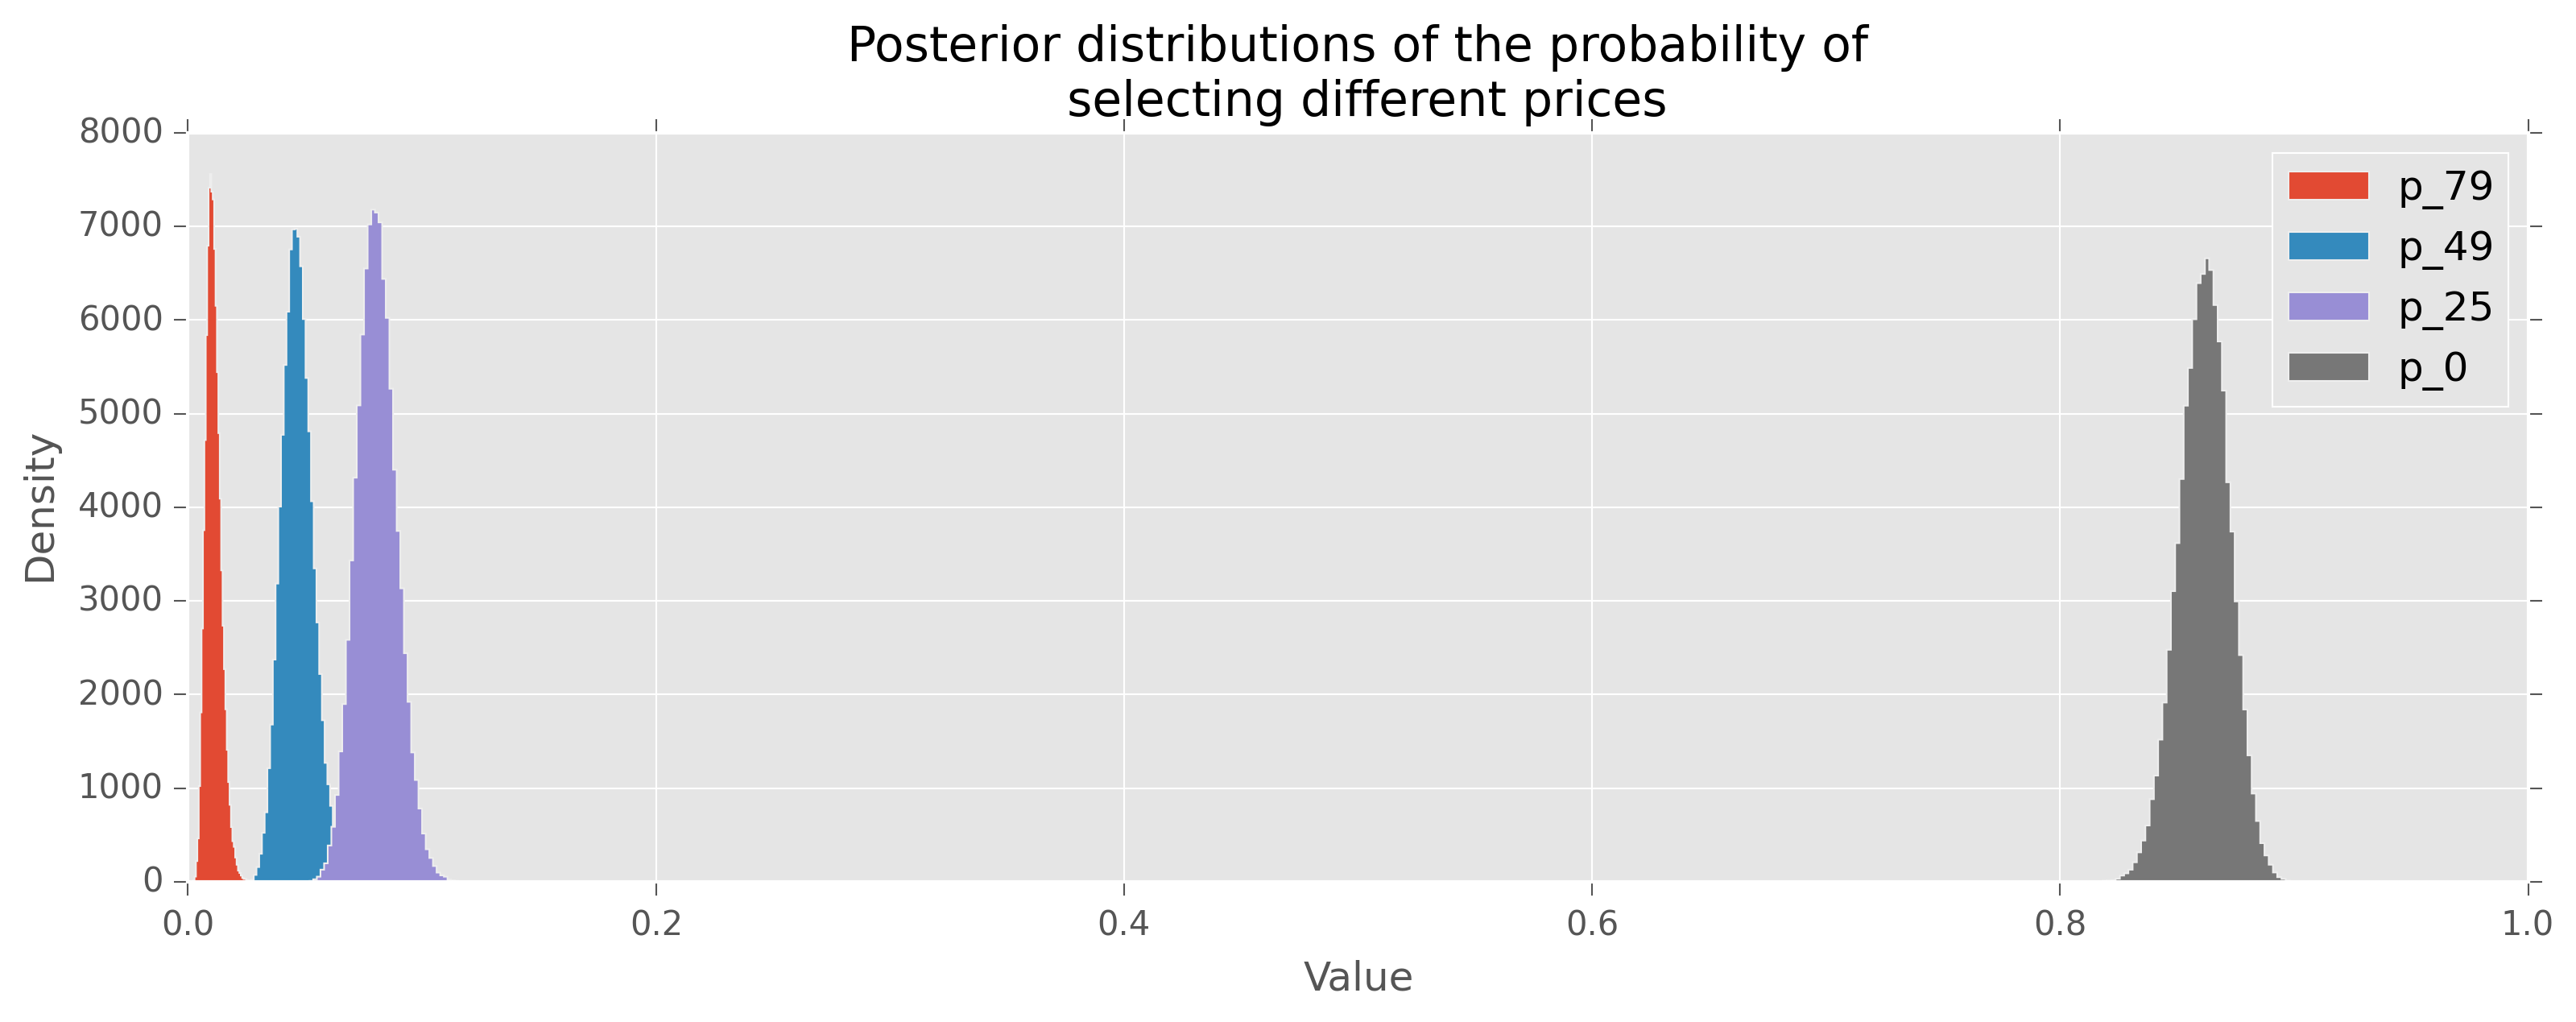

In [161]:
for i, label in enumerate(['p_79', 'p_49', 'p_25', 'p_0']):
    ax = plt.hist(posterior_samples[:,i], bins=50, label=label,histtype='stepfilled')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the probability of \n selecting different prices")
plt.legend()    

As you can see, there is still uncertainty in what we think the probbilities might be, so there will also be uncertainty in our expected value. That's okay; what we get is a posterior of our expected value. We do this by passing each sample from the Dirichlet posterior through the following ```expected revenue``` function:
This approach should feel a lot like using a loss function, as that is essentially what we are doing: We are estimating parameters, then passing them through a loss function to relate them back to the real world.

In [163]:
def expected_revenue(P):
    return 79*P[:,0] + 49*P[:,1] + 25*P[:,2] + 0*P[:,3]

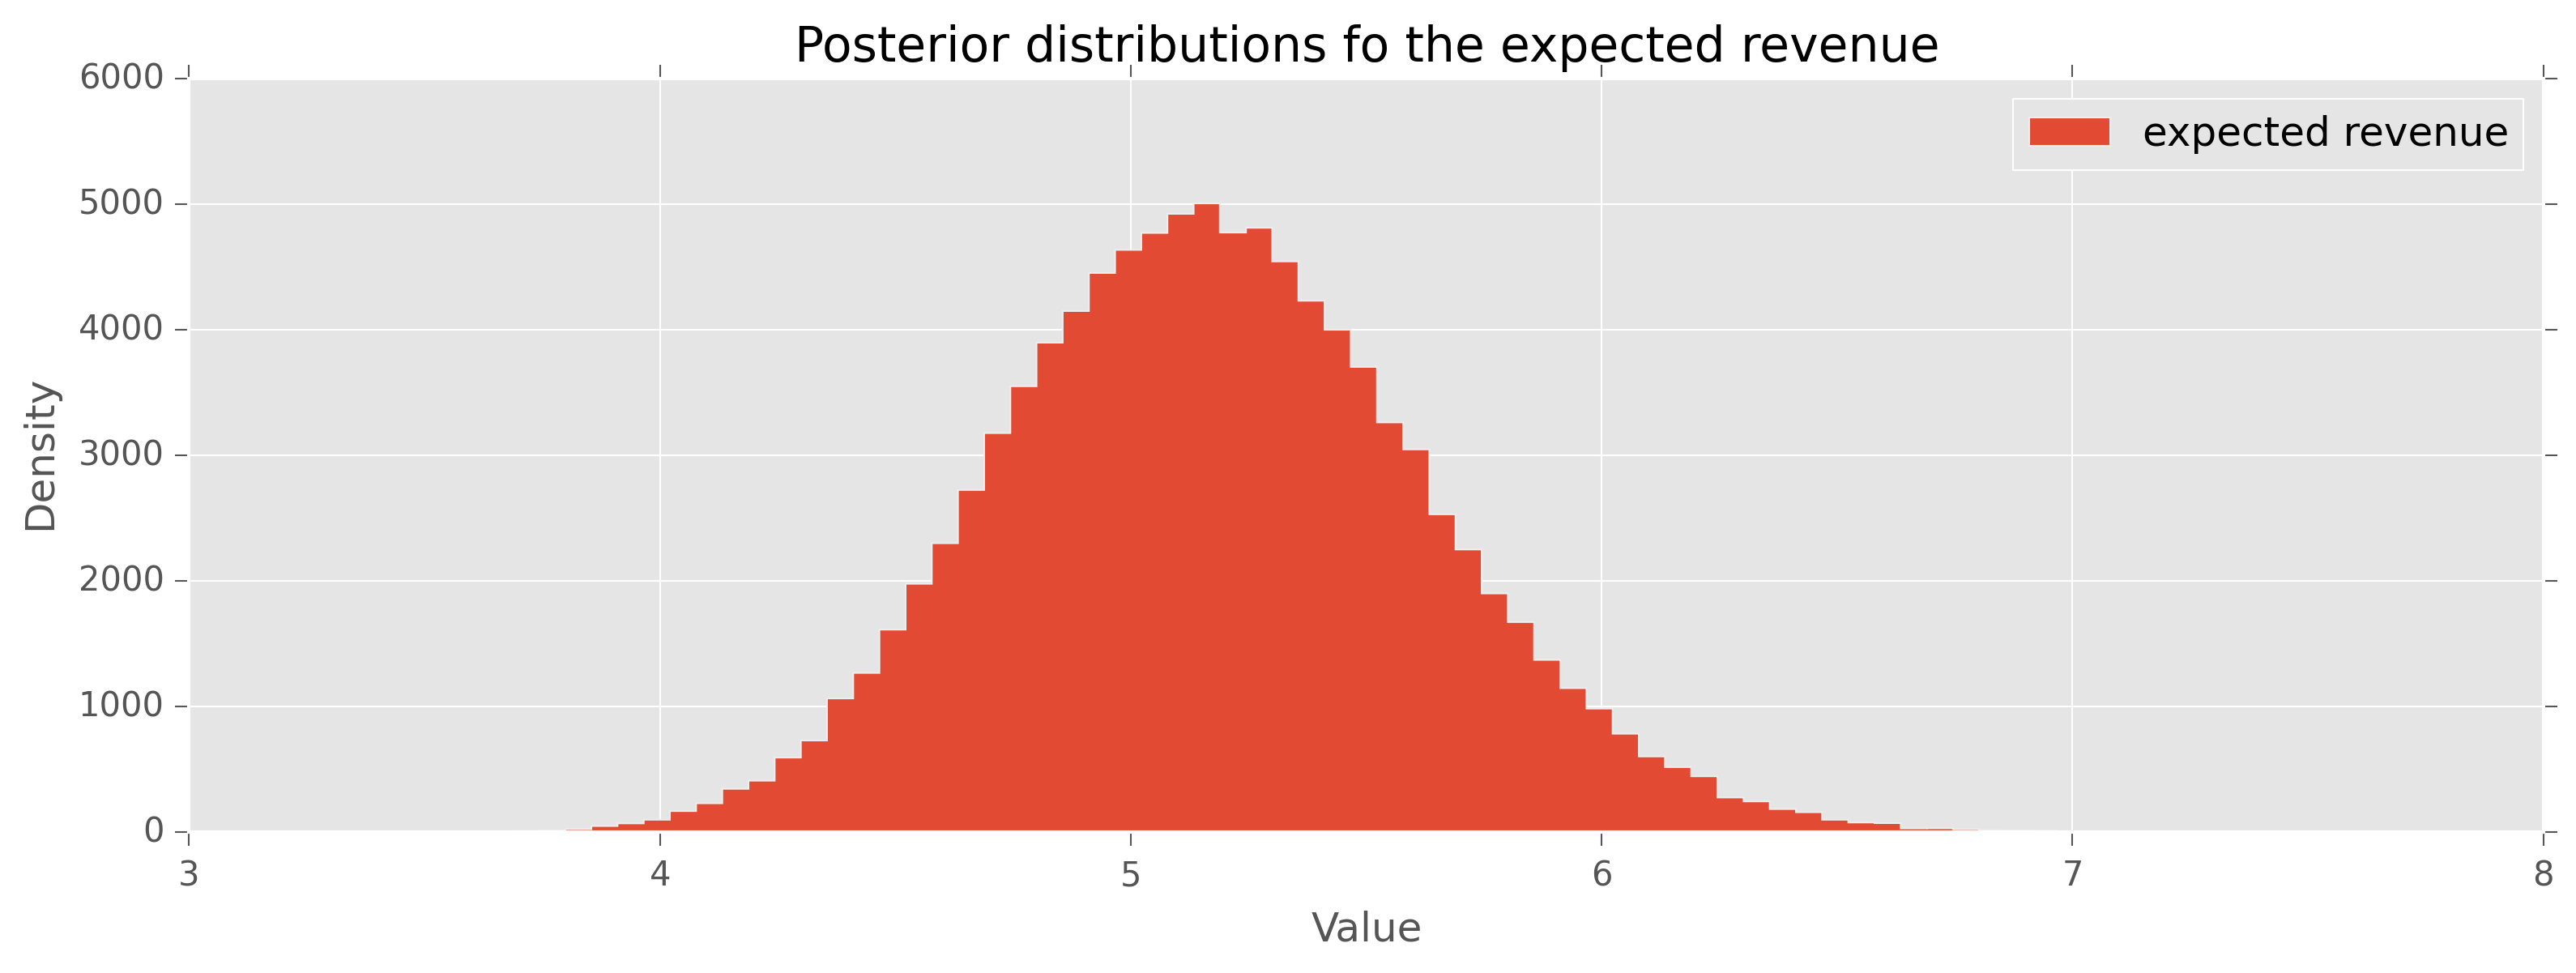

In [167]:
posterior_expected_revenue = expected_revenue(posterior_samples)


plt.hist(posterior_expected_revenue, histtype='stepfilled',label='expected revenue', bins=80)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions fo the expected revenue")
plt.legend()

We can see from the figure above that the expected revenue is likely between \$4 and \$6, and unlikely to be outside this range.

### 7.3.2 Extending to an A/B Experiment

Let's try this analysis with two different Web pages, denoted site A and B, for which I've created some artificial data:




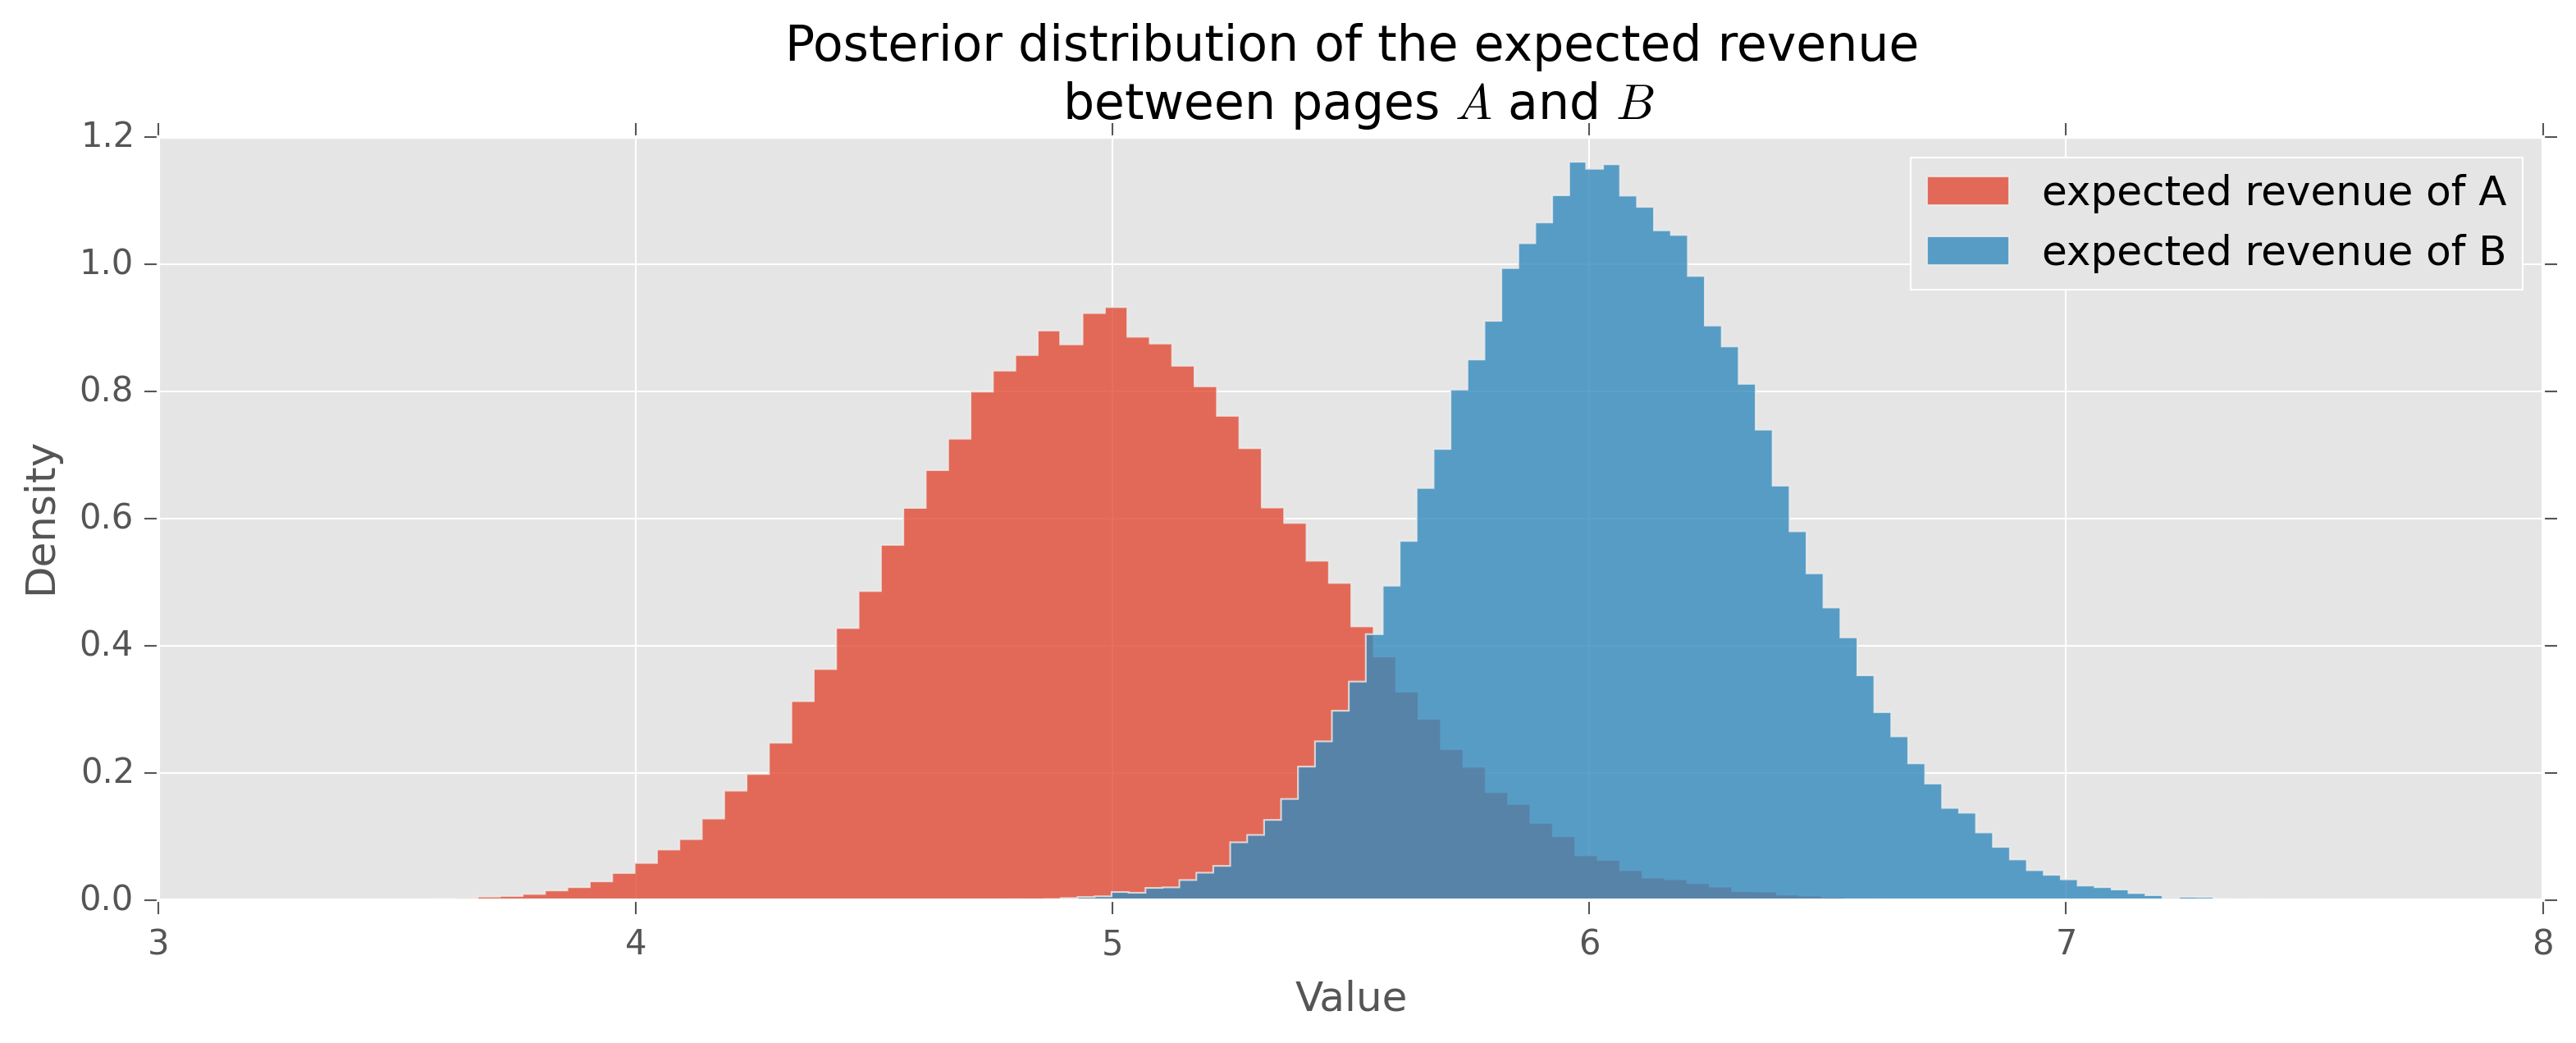

In [169]:
N_A    = 1000
N_A_79 = 10
N_A_49 = 46
N_A_25 = 80
N_A_0  = N_A - (N_A_79 + N_A_49 + N_A_49)
observations_A = np.array([N_A_79, N_A_49, N_A_25, N_A_0])


N_B    = 2000
N_B_79 = 45
N_B_49 = 84
N_B_25 = 200
N_B_0  = N_B - (N_B_79 + N_B_49 + N_B_49)
observations_B = np.array([N_B_79, N_B_49, N_B_25, N_B_0])


prior_parameters = np.array([1,1,1,1])

posterior_samples_A = dirichlet(prior_parameters + observations_A,
                                size=100000)
posterior_samples_B = dirichlet(prior_parameters + observations_B,
                                size=100000)


posterior_expected_revenue_A = expected_revenue(posterior_samples_A)
posterior_expected_revenue_B = expected_revenue(posterior_samples_B)

plt.hist(posterior_expected_revenue_A, histtype='stepfilled',
         label='expected revenue of A', bins=80,normed=True,alpha=0.8)
plt.hist(posterior_expected_revenue_B, histtype='stepfilled',
         label='expected revenue of B', bins=80, alpha=0.8,normed=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distribution of the expected revenue \n between pages $A$ and $B$")
plt.legend();


Notice how far apart the two posteriors are, sugesting a significant difference in the Web page's performance. The average expected revenue for page A is about \$1 less than page B's. (That might not seem like much, but this is _per page view_, which can really add up.) To confirm this difference exists, we can look at the probability that the revenue for page B is larger than page A's, similar to what we performed in the previous conversion analysis.

In [171]:
p = (posterior_expected_revenue_B > posterior_expected_revenue_A).mean()
print "Probability that page B has a higher revenue than page A: %.3f " %p

Probability that page B has a higher revenue than page A: 0.968 


This value is high enough to be significant, so the business shold choose page B going forward. Another interesting plot to look at is the posterior difference in revenue between the pages. We get this for free since we are using Bayesian analysis; we simply look at the histogram of the differences of the two expected revenue posteriors.

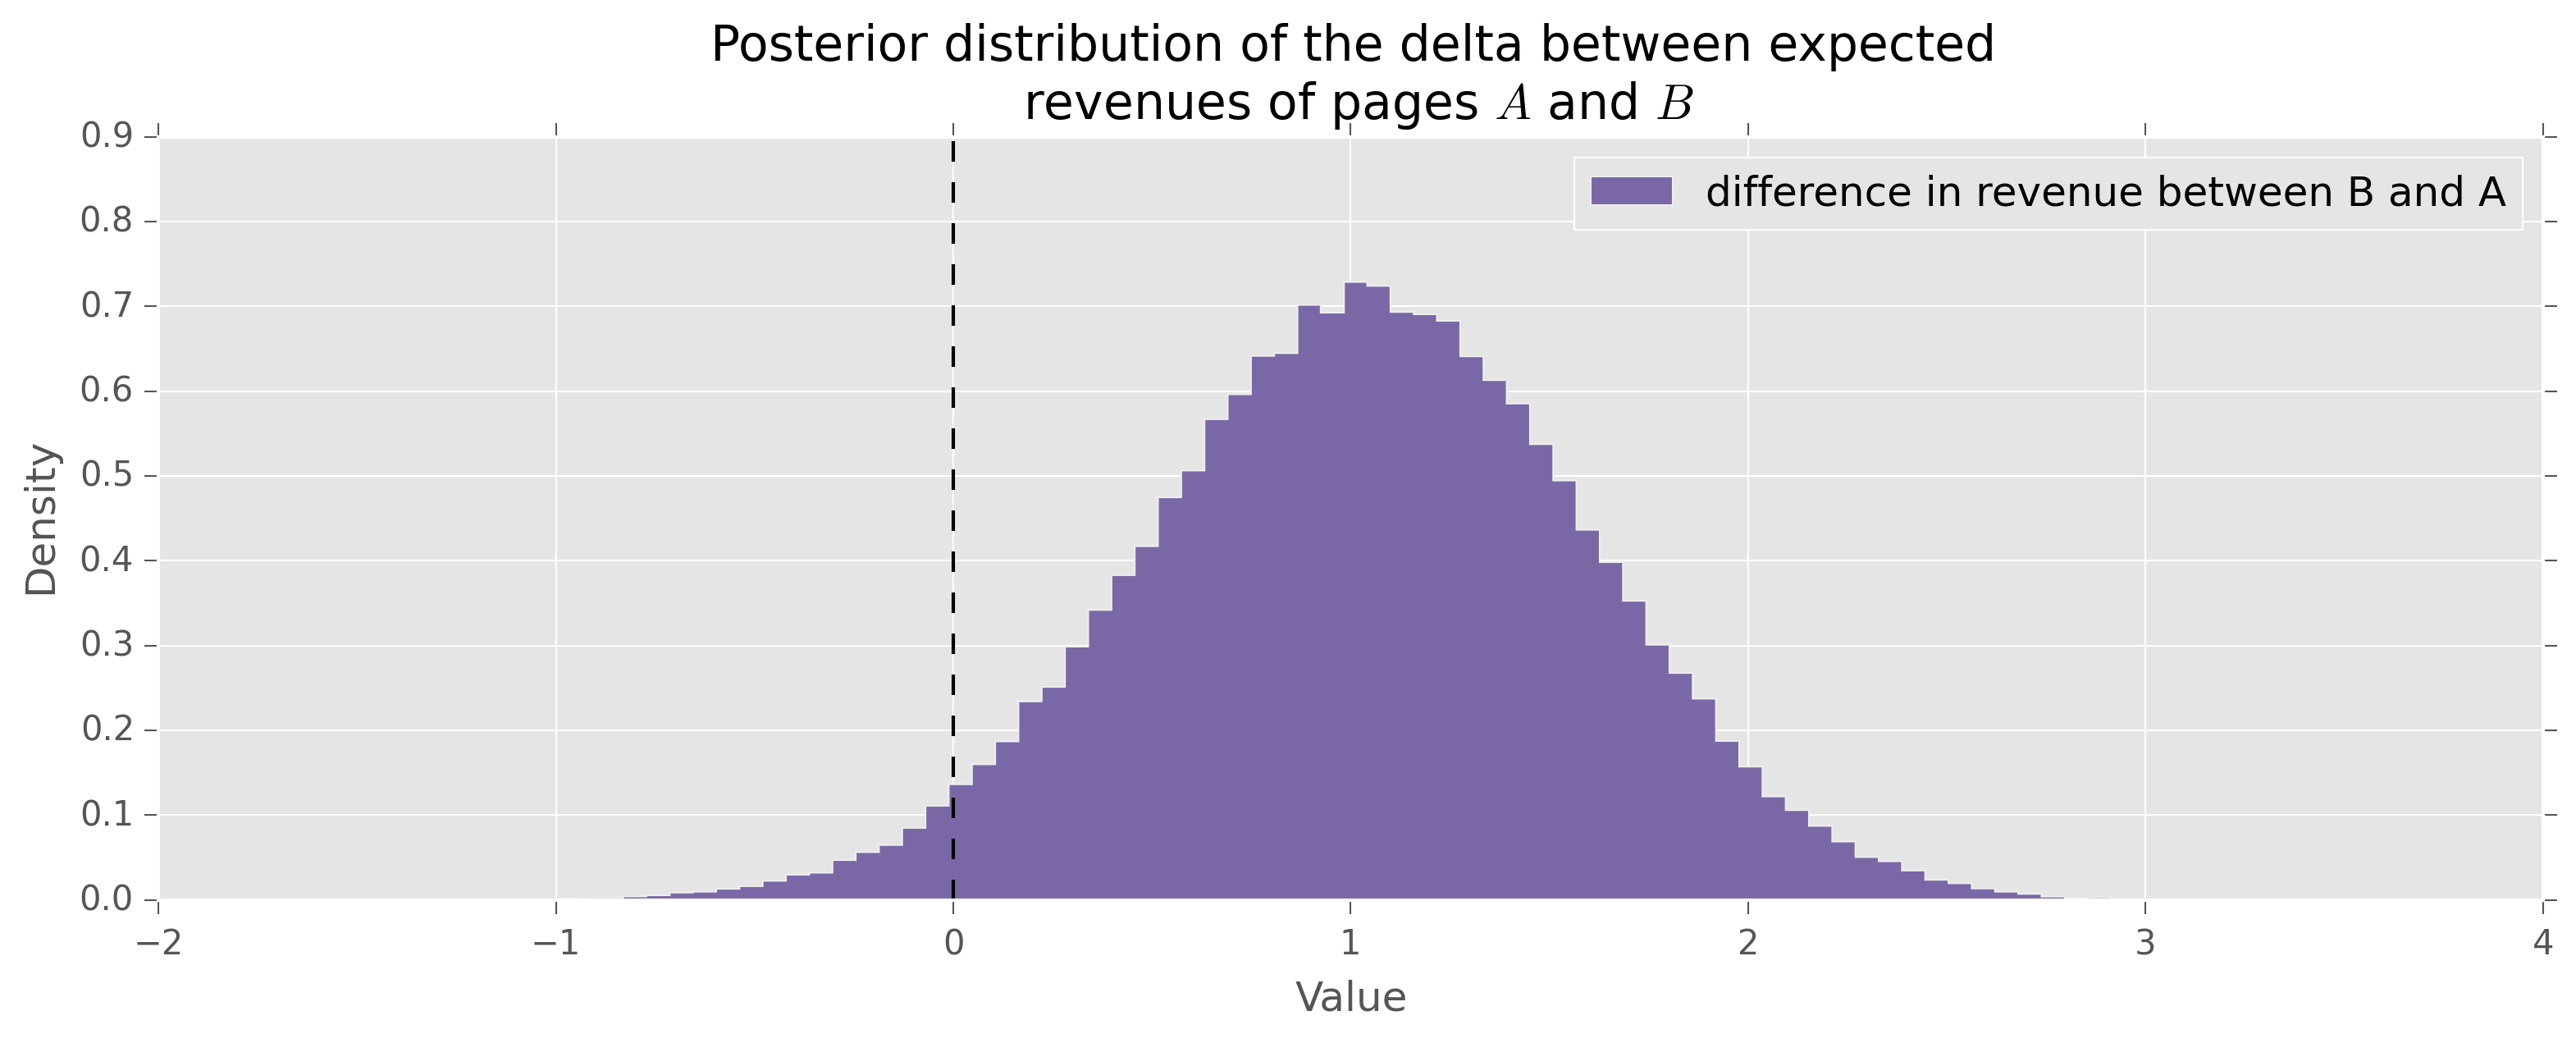

In [177]:
posterior_diff = posterior_expected_revenue_B - posterior_expected_revenue_A

plt.hist(posterior_diff, histtype='stepfilled', color='#7A68A6',
         label='difference in revenue between B and A', bins=80, normed=True)
plt.vlines(0, 0, .9, linestyles='--')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distribution of the delta between expected \n revenues of pages $A$ and $B$")
plt.legend();

Looking at this posterior, we see that there is about a 50% chance that the difference is _more_ than 1\$, and possibly even larger than 2\$. And if we are wrong about our choice of B (which is possible), we probably won't lose much: the distribution doesn't extend much past -\$0.50 .